In [46]:
import os
import pickle
import pprint
import itertools
import pathos
import functools
from functools import partial
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.feature_selection import mutual_info_regression as MI

import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('/home/leonardo/git/bayesian_bss')
from src import MMSEMetropolisHastingsEstimator, InstantaneousMixtureModel, MCMCGraphPlotter

np.random.seed(2000)

In [47]:
# Whether or not to create folder structure
CREATE_FOLDER_STRUCTURE=False

# Whether or not to save graphs
SAVE_GRAPHS=False

# Whether or not to save source and mixture signals
SAVE_SIGNALS=False

# Whether or not to execute sampling
EXECUTE_SAMPLING=False

# Number of sources and observations
NSOURCES=2
NOBS=20000

# Execution hyperparameters
N_INITIALIZATIONS = 30
N_WORKERS = os.cpu_count()

# Define initial conditions for optimizations
initial_B = np.random.normal(
    0,1,
    (NSOURCES, NSOURCES, N_INITIALIZATIONS)
)

# MCMC configs
EXPLORATION_VAR=1E-4
N_SAMPLES=20000
BURN_IN=0.5

# Plot configs
NBINS=20

# Variável para armazenar erros de estimação em cada caso
errors = {
    'perfect_model': {},
    'slightly_misspecified_model': {}
}

In [48]:
# Folder which will contain output directory tree
OUTPUT_DIR='./output'
base_output_path=Path(OUTPUT_DIR)

# Experiment params
EXPERIMENT_NAME='nobs_20k'
EXPERIMENT_DESCRIPTION="""
    Runs perfect model and slightly misspecified model with 20k observations and 20k Metropolis-Hastings steps.
"""

# Create experiment directory tree, if so specified
experiment_dir = base_output_path / EXPERIMENT_NAME
perfect_model_dir = experiment_dir / 'perfect_model'
slightly_misspecified_model_dir = experiment_dir / 'slightly_misspecified_model'
if CREATE_FOLDER_STRUCTURE:
    if not experiment_dir.is_dir():
        experiment_dir.mkdir()
    if not perfect_model_dir.is_dir():
        perfect_model_dir.mkdir()
    if not slightly_misspecified_model_dir.is_dir():
        slightly_misspecified_model_dir.mkdir()

# Write experiment description
if EXECUTE_SAMPLING:
    with (experiment_dir/'experiment_description.txt').open('w') as f:
        f.write(EXPERIMENT_DESCRIPTION)

# ENSAIO - MARKOV CHAIN MONTE CARLO - ALGORITMO METROPOLIS-HASTINGS

#### Objetivos:
#### - Implementar o algoritmo Metropolis para obter amostras da distribuição a posteriori da matriz de separação B;
#### - Estimar a matriz de separação B, variando a escolha de distribuição a priori a configuração de casamento entre estatística das fontes e modelo. Estimações são feitas para critério MMSE, onde se toma o valor esperado da distribuição a posteriori;
#### - Avaliar qualidade de estimações nos vários casos;
#### - Avaliar desempenho de algoritmo Metropolis: convergência das amostras, custo computacional, influência de pontos de inicialização, qualidade de estimativas;

#### Para tal:
####  - Executa-se algoritmo de amostragem, obtendo estimativa MMSE via simulação de Monte Carlo.
####  - Avalia-se a convergência da distribuição do processo estocástico resultante do algoritmo Metropolis, bem como da log-posteriori resultante;
####  - Observam-se as distribuições a posteriori dos coeficientes da matriz B individualmente;
####  - Utilizam-se as amostras obtidas para estimar matriz B, a qual é utilizada para recuperar as fontes não-observadas;
#### 

# Estimação Pontual Bayesiana via critério Minimum Mean Square Error (MMSE)

#### De Paulino, Turkman e Murteira (2003): estimativa $\hat{B}_{MMSE}$ é obtida como sendo a média (valor esperado) da distribuição a posteriori. Considerando $\mathcal{B}$ como sendo o conjunto de todas as matrizes B possíveis:

$$\hat{B}_{MMSE}=E[B]=\int_{\mathcal{B}}B \cdot P(B|X) dB$$ 


#### Demonstra-se, de maneira simples, que este critério coincide com a minimização do erro quadrático médio, sendo portanto chamado de MMSE. Considera-se que o erro quadrático médio para uma estimativa qualquer $\hat{B}$ seja dada por:

$$ MSE = \int_{\mathcal{B}} (\hat{B}-B)^{2} \cdot P(B|X) dB $$

#### 
# Simulação de Monte Carlo

#### De Brémaud (2020): quando não possível ou muito complexa em termos de resolução analítica, a integral para estimação de $\hat{B}_{MMSE}$ pode ser aproximada gerando-se amostras $B_{i}$ de B segundo a distribuição $P(B|X)$, e computando a média destas amostras. A Lei Forte dos Grandes Números garante a convergência.

$$\hat{B}_{MMSE}=E[B]=\int_{\mathcal{B}}B \cdot P(B|X) dB= \lim_{N \to \infty} \sum_{i=1}^{N}B_{i}$$

#### Há, ainda, o desafio de se obter amostras $B_{i}$ distribuídas de acordo com $P(B|X)$. Para este fim, utilizam-se os métodos MCMC.

#### 

# Métodos de Monte Carlo via Cadeia de Markov (Markov Chain Monte Carlo - MCMC)

#### De Paulino, Turkman e Murteira (2003): 

#### "A ideia básica por detrás desses métodos é a da transformar o problema estático em consideração num problema de natureza dinâmica, construindo para o efeito um processo estocástico temporal, artificial, que seja fácil de simular, e que convirja, fracamente, para a distribuição original. Este processo temporal é, em geral, uma cadeia de Markov homogênea cuja distribuição de equilíbrio é a distribuição que se pretende simular. Para implementar este método há necessidade de saber construir cadeias de Markov com distribuições de equilíbrio específicas."

#### 

# Algoritmo Metropolis-Hastings

#### De Mira (2005): no caso de se desejar obter amostras da distribuição a posteriori $P(B|X)$, o algoritmo Metropolis-Hastings (Metropolis et al., 1953; Hastings, 1970) se constitui pela aplicação sequencial da seguinte regra:



#### 1. Dado B_{i}, o valor de B num instante qualquer i, uma movimentação para B_{i+1} é proposta segundo uma distribuição $Q(B_{i},B_{i+1})$. Por exemplo, Q pode ser uma distribuição normal centrada em $B_{i}$, e com variância pré-determinada.

#### 2. O valor proposto de $B_{i+1}$ será aceito com probabilidade $\alpha(B_{i}, B_{i+1})$, onde:

$$ \alpha(B_{i}, B_{i+1})= \min \left[ \; 1, \; \frac{P(B_{i+1}|X) \cdot Q(B_{i},B_{i+1})}{P(B_{i}|X) \cdot Q(B_{i},B_{i+1})} \; \right] $$

#### 3. Caso não seja aceito o novo valor, faz-se $B_{i+1}=B_{i}$.

#### 

#### Obs: caso a função Q seja simétrica, como por exemplo uma distribuição normal, tem-se que $Q(B_{i},B_{i+1})=Q(B_{i+1},B_{i})$. Neste caso, a expressão da probabilidade de aceite se reduz a:

$$ \alpha(B_{i}, B_{i+1})= \min \left[ \; 1, \; \frac{P(B_{i+1}|X)}{P(B_{i}|X)} \; \right] $$

#### Este é o algoritmo originalmente proposto em Metropolis et al. (1953), com a generalização para funções Q não simétricas tendo sido proposta em Hastings, 1970. Neste ensaio, utiliza-se Q normal, e portanto simétrica.

#### 

# Cálculo de $\alpha(B_{i}, B_{i+1})$

#### Uma vez que as probabilidades a posteriori envolvidas no cálculo de $\alpha(B_{i}, B_{i+1})$ são muito pequenas, faz-se uma adaptação das equações envolvidas para que estejam expressas em termos das log-posterioris:

$$ \log \alpha(B_{i}, B_{i+1})= \min \left[ 0, \; \log P(B_{i+1}|X) - \log P(B_{i}|X) \; \right] $$

Portanto, tem-se:

$$ \alpha(B_{i}, B_{i+1})= \exp \left( \min \left[ 0, \; \log P(B_{i+1}|X) - \log P(B_{i}|X) \; \right] \right)$$

#### Utiliza-se a equação da log-posteriori de Djafari (2000):
$$ \log P(\boldsymbol{B}|X) = T \log |det({B})| + \sum_{t} \sum_{i} \log p_{i}(x_{i}(t)) + \log P(\boldsymbol{B}) + cte$$

# Pseudocódigo Algoritmo
<code>
    ** 1) Inicialização **
    B(i) ~ N(0,1)
    B_samples = lista_vazia
    ** 2) Loop principal **
    para i de 1:N_PASSOS
        ** Gera novo candidato a amostra do processo, baseado na função probabilística Q **
        B(i+1) ~ Q(B(i), B(i+1))
        ** Calcula probabilidade de aceite alpha(B(i), B(i+1)) **
        alpha(i+1) <- alpha(B(i), B(i+1))
        ** Obtém variável uniforme u, para acolher nova amostra com probabilidade alpha(B(i), B(i+1)) **
        u ~ U(0,1)
        ** Acolhe nova amostra de acordo com u e alpha(B(i), B(i+1)) **
        se u < alpha(i+1):
            B(i+1) <- B(i+1)
        se u >= </alpha>alpha(i+1):
            B(i+1) <- B(i)
        ** Registra nova amostra **
        B_samples.append(B(i+1))
    retorna B_samples
        
        
<code>

# 1. PERFECT MODEL

In [49]:
model_dir = perfect_model_dir

## 1.1. Initialize Sources

In [50]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_generator(
    nsources,
    nobs,
    mu
):
    return np.random.logistic(
        loc=mu,
        scale=1,
        size=(nsources, nobs)
    )

In [51]:
MU=0.0

s = source_generator(
    nsources=NSOURCES,
    nobs=NOBS,
    mu=MU
)

print('-'*100)
print('NÚMERO DE FONTES: {}'.format(NSOURCES))
print('TAMANHO DOS SINAIS DAS FONTES: {}'.format(NOBS))
for i in range(s.shape[0]):
    print(
        'CURTOSE s{}: {}'.format(
            i,
            st.kurtosis(a=s[i,:])
        )
    )
    
print('-'*100)

----------------------------------------------------------------------------------------------------
NÚMERO DE FONTES: 2
TAMANHO DOS SINAIS DAS FONTES: 20000
CURTOSE s0: 1.0628396785103567
CURTOSE s1: 1.2726001053056777
----------------------------------------------------------------------------------------------------


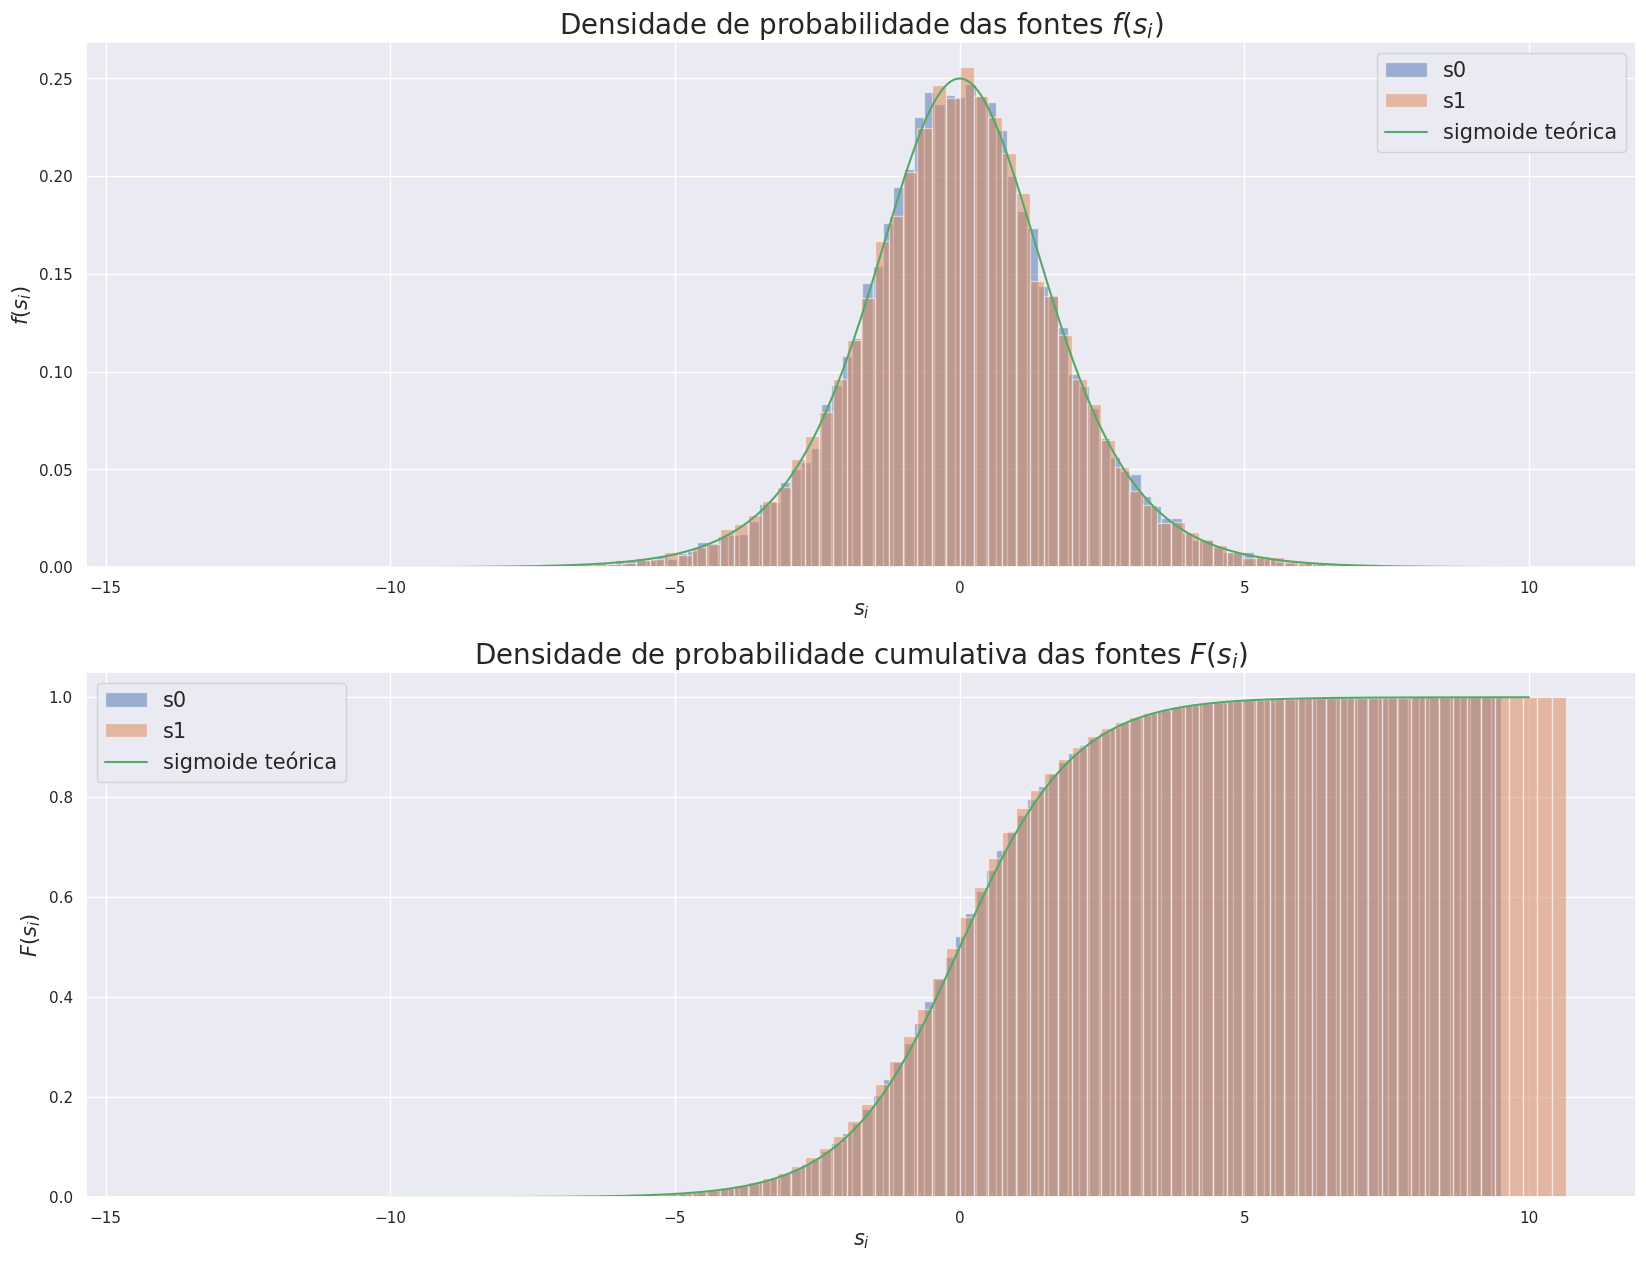

In [52]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)


for i in range(1, NSOURCES+1):
    ax1.hist(
        x=s[i-1,:],
        bins=100,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=s[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    
ax1.plot(
    np.linspace(-10,10,1000),
    [source_pdf(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)


ax2.plot(
    np.linspace(-10,10,1000),
    [source_cumulative(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)

ax1.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(s_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidade de probabilidade das fontes $f(s_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(s_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidade de probabilidade cumulativa das fontes $F(s_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 1.2. Mix sources and generate observations

In [53]:
# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])
print('MIXING MATRIX A:')
print(A)

MIXING MATRIX A:
[[ 1.   1. ]
 [-0.5  0.5]]


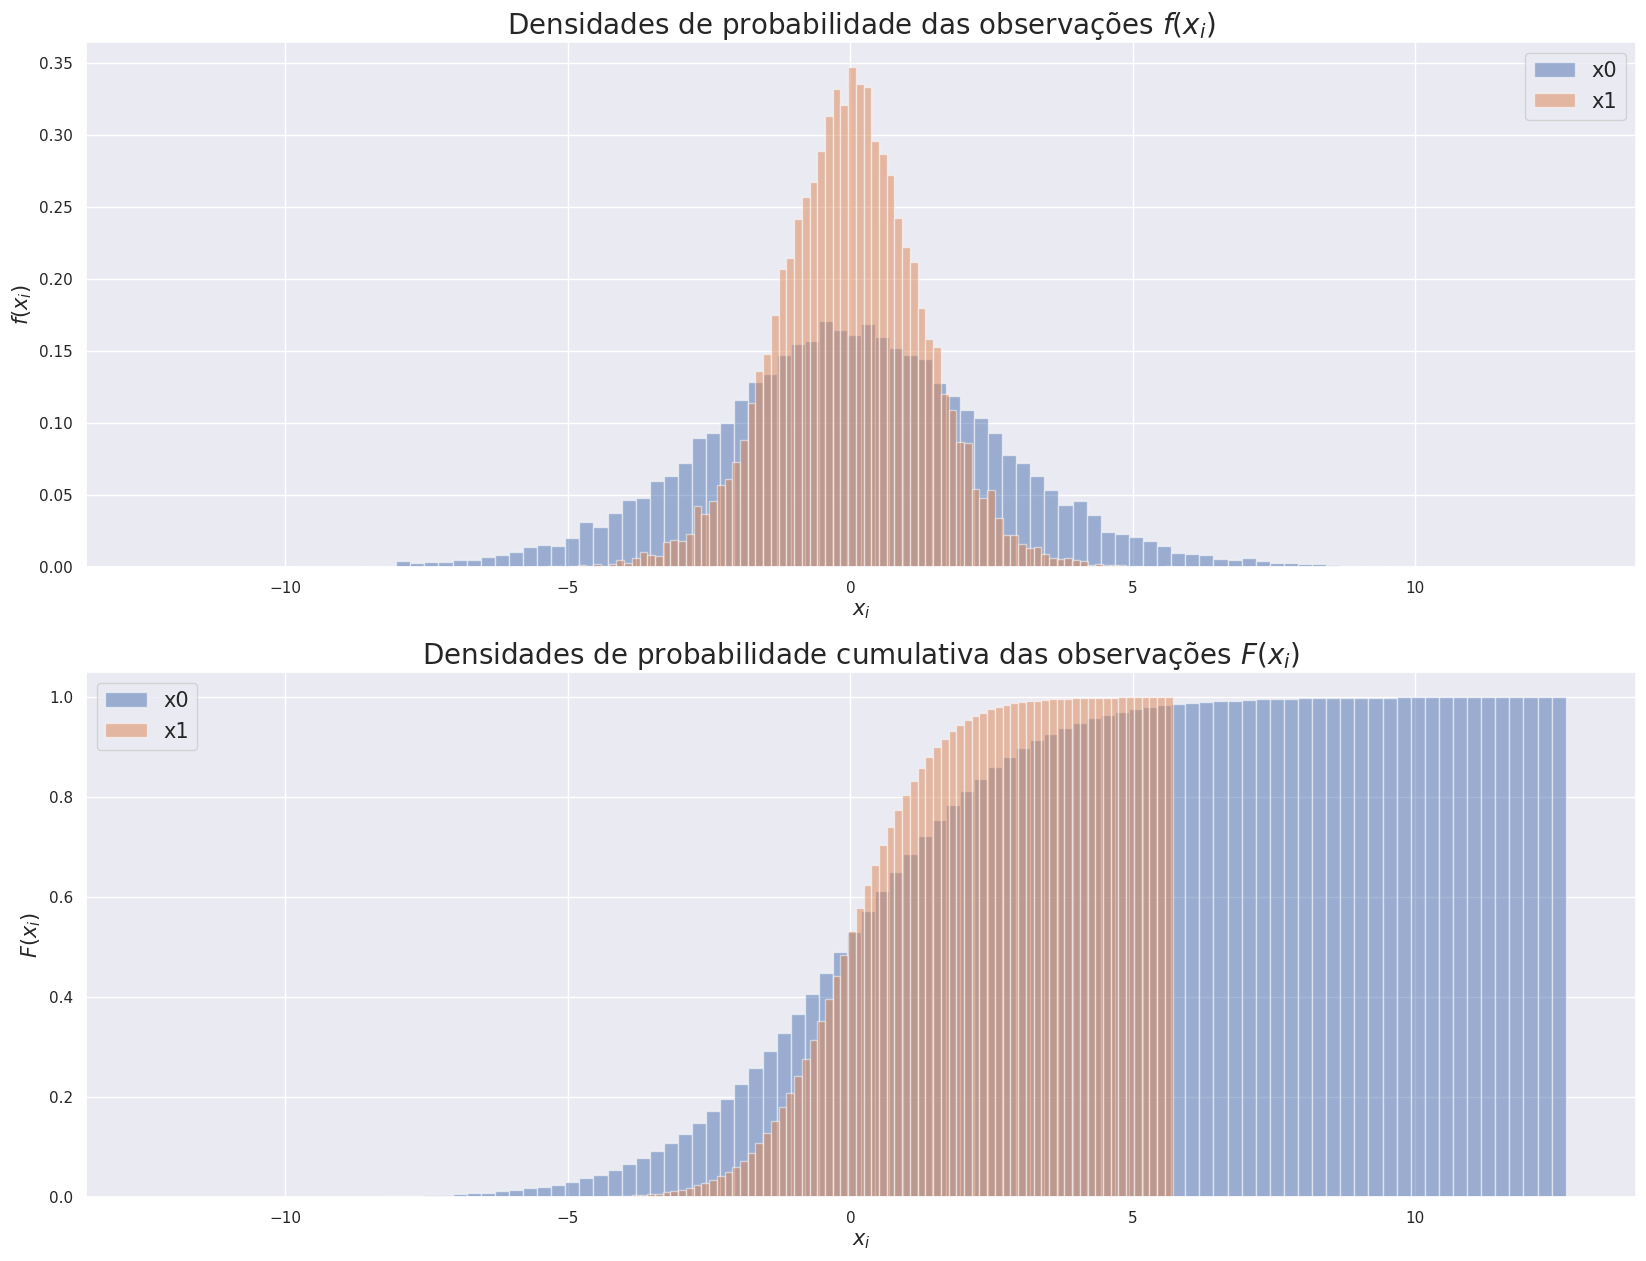

In [54]:
# Observed sources
x = A@s

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

for i in range(1, NSOURCES+1):
    ax1.hist(
        x=x[i-1,:],
        bins=100,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=x[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )

ax1.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(x_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidades de probabilidade das observações $f(x_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(x_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidades de probabilidade cumulativa das observações $F(x_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

In [55]:
signal_save_dir = model_dir / 'signals'
if CREATE_FOLDER_STRUCTURE:
    if not signal_save_dir.is_dir():
        signal_save_dir.mkdir()

if SAVE_SIGNALS:
    with (signal_save_dir / 'sources.pkl').open(mode='wb') as f:
        pickle.dump(s, f)

    with (signal_save_dir / 'mixtures.pkl').open(mode='wb') as f:
        pickle.dump(x, f)

## 1.3. Perform Analysis - LIKELIHOOD

### 1.3.1 Execute MCMC Sampling

In [56]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    return 1

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [57]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'likelihood'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 25.2 ms, sys: 23.1 ms, total: 48.3 ms
Wall time: 46.1 ms


### 1.3.2. Parse MCMC Results

In [58]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx=0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [59]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.49840627 -1.00676935]
 [ 0.50055214  0.98801388]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [60]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-80053.62176732118,
 -80053.62771851268,
 -80053.63239115704,
 -80053.62884758298,
 -80053.63221666348,
 -80053.66240126094,
 -80053.6347818967,
 -80053.63147347944,
 -80053.63949330601,
 -80053.63958554454,
 -80053.62792769306,
 -80053.65732701735,
 -80053.6557192498,
 -80053.6359056936,
 -80053.62182431784,
 -80053.63298373202,
 -80053.6396446366,
 -80053.62003542551,
 -80053.63051082939,
 -80053.61917193013,
 -80053.6137165805,
 -80053.63378437891,
 -80053.61204634693,
 -80053.66895176163,
 -80053.62188382217,
 -80053.63202395932,
 -80053.60679765086,
 -80053.64300021685,
 -80053.63288850794,
 -80053.62563516496]

In [61]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.49840627, -1.00676935],
        [ 0.50055214,  0.98801388]]),
 array([[ 0.50060068,  0.98823702],
        [-0.4986098 ,  1.00741184]]),
 array([[-0.4967223 ,  1.01182121],
        [-0.50305731, -0.98361323]]),
 array([[-0.49731303,  1.01102617],
        [-0.50236252, -0.98491364]]),
 array([[ 0.49900547, -1.00529921],
        [ 0.50002298,  0.98999177]]),
 array([[-0.50368718, -0.98205282],
        [-0.49594537,  1.01298205]]),
 array([[ 0.5017604 ,  0.98498794],
        [-0.49709398,  1.01085127]]),
 array([[-0.50195003, -0.98595377],
        [ 0.49748504, -1.00932667]]),
 array([[-0.49651651,  1.01241323],
        [-0.50315403, -0.98342302]]),
 array([[-0.49821186,  1.00921793],
        [ 0.50140803,  0.98739873]]),
 array([[ 0.49988858, -1.00320014],
        [ 0.49909556,  0.99152512]]),
 array([[-0.50156644, -0.9873026 ],
        [ 0.49816432, -1.00819486]]),
 array([[-0.49735871,  1.00976618],
        [ 0.50210725,  0.98605317]]),
 array([[-0.50006009,  1.00475664],
  

### 1.3.3. Plot sampled coefficients stochastic process - Markov Chain evolution

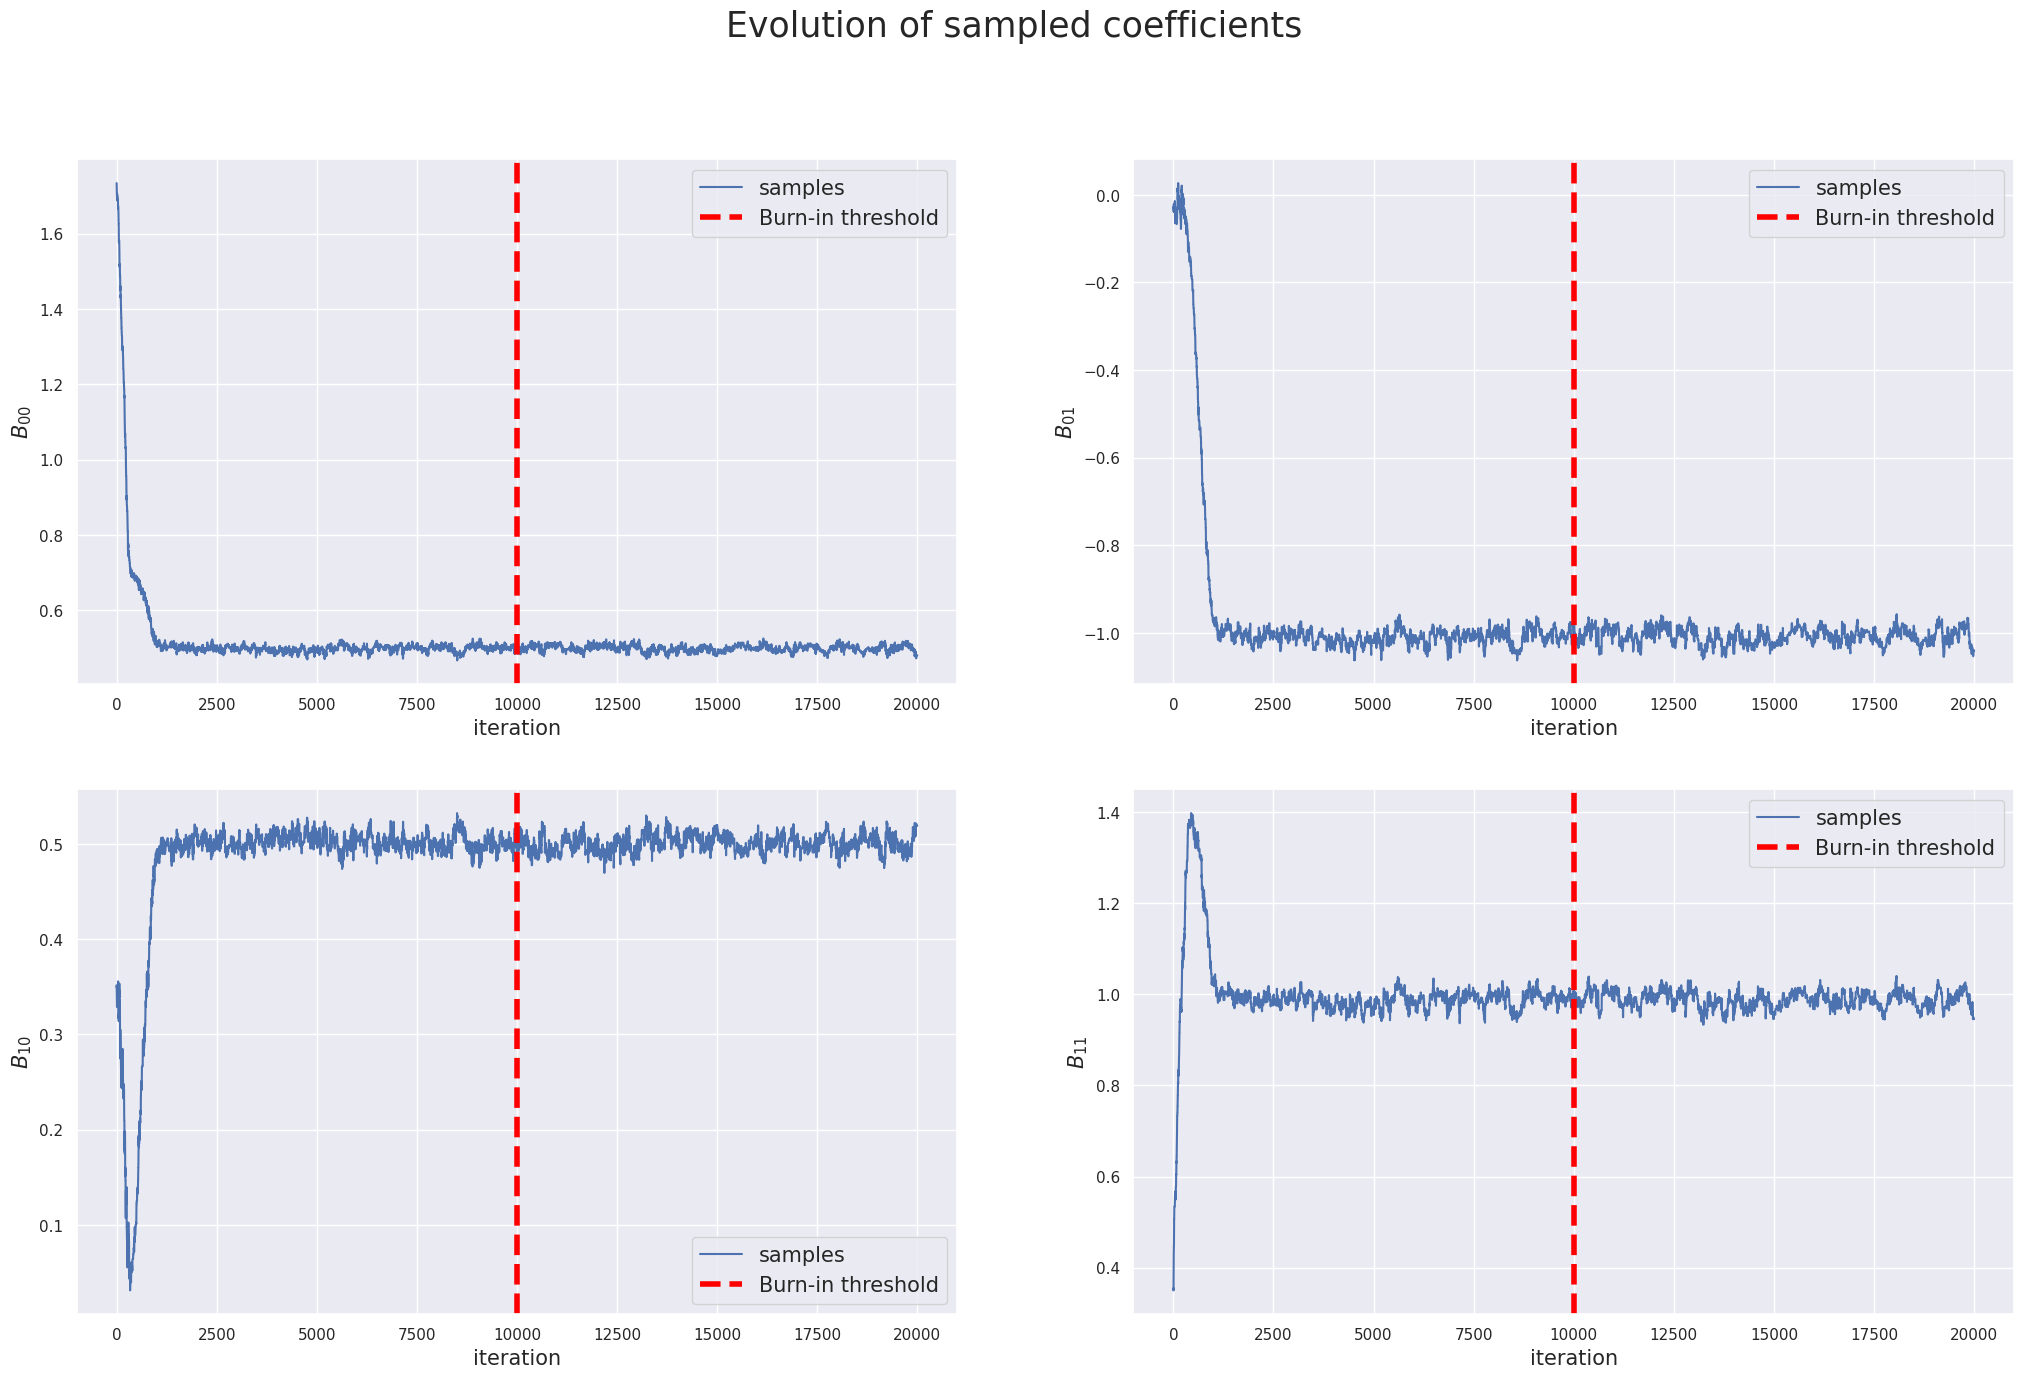

In [62]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.3.4. Plot sampled coefficients distributions - Markov Chain evolution

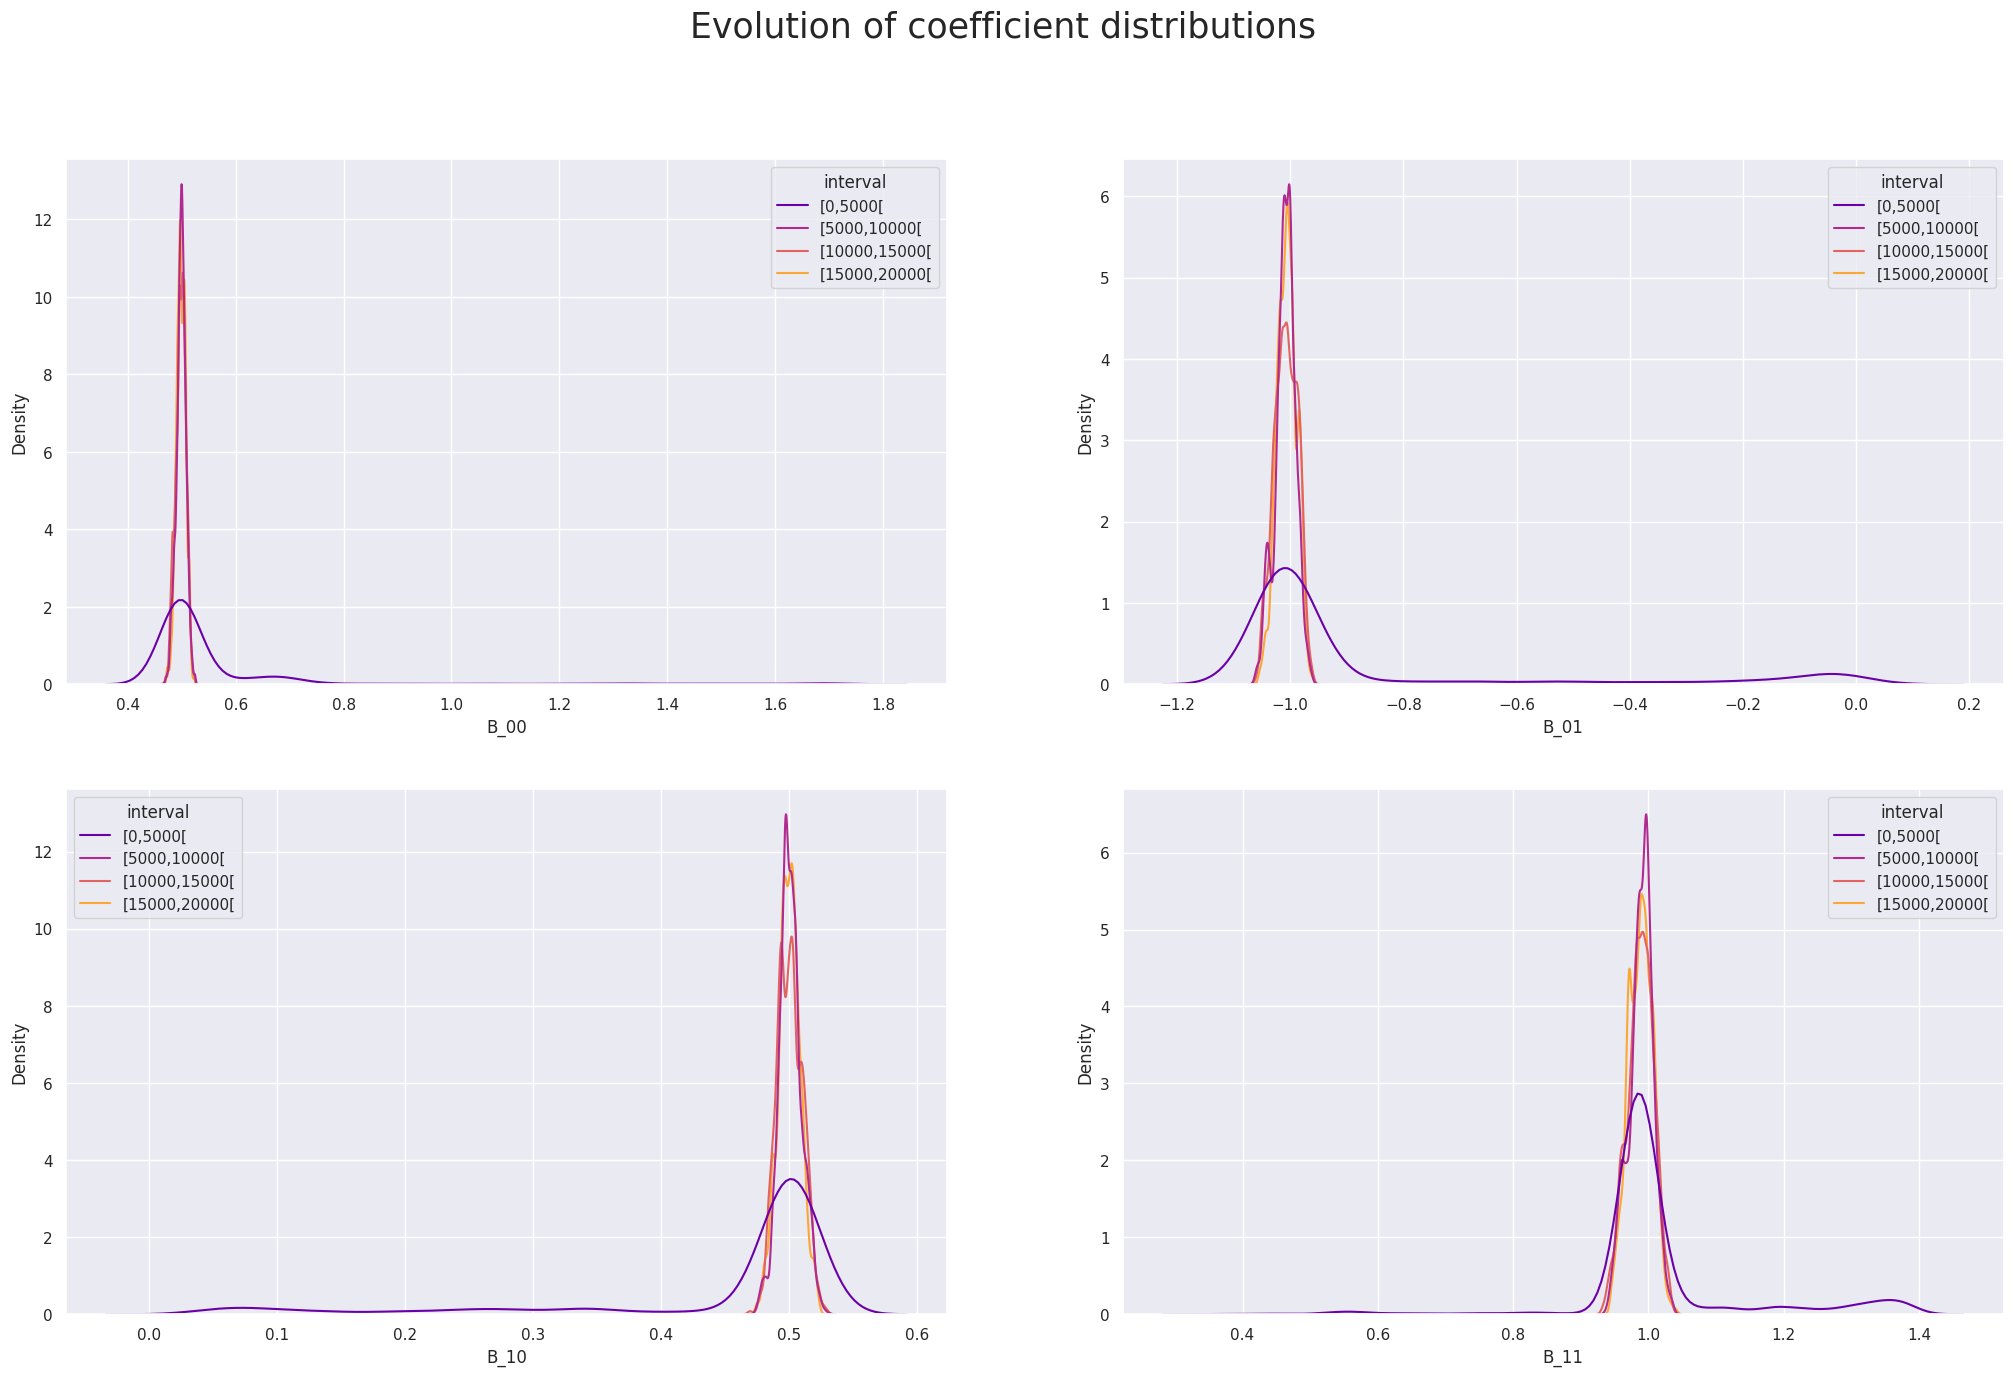

In [63]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.3.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

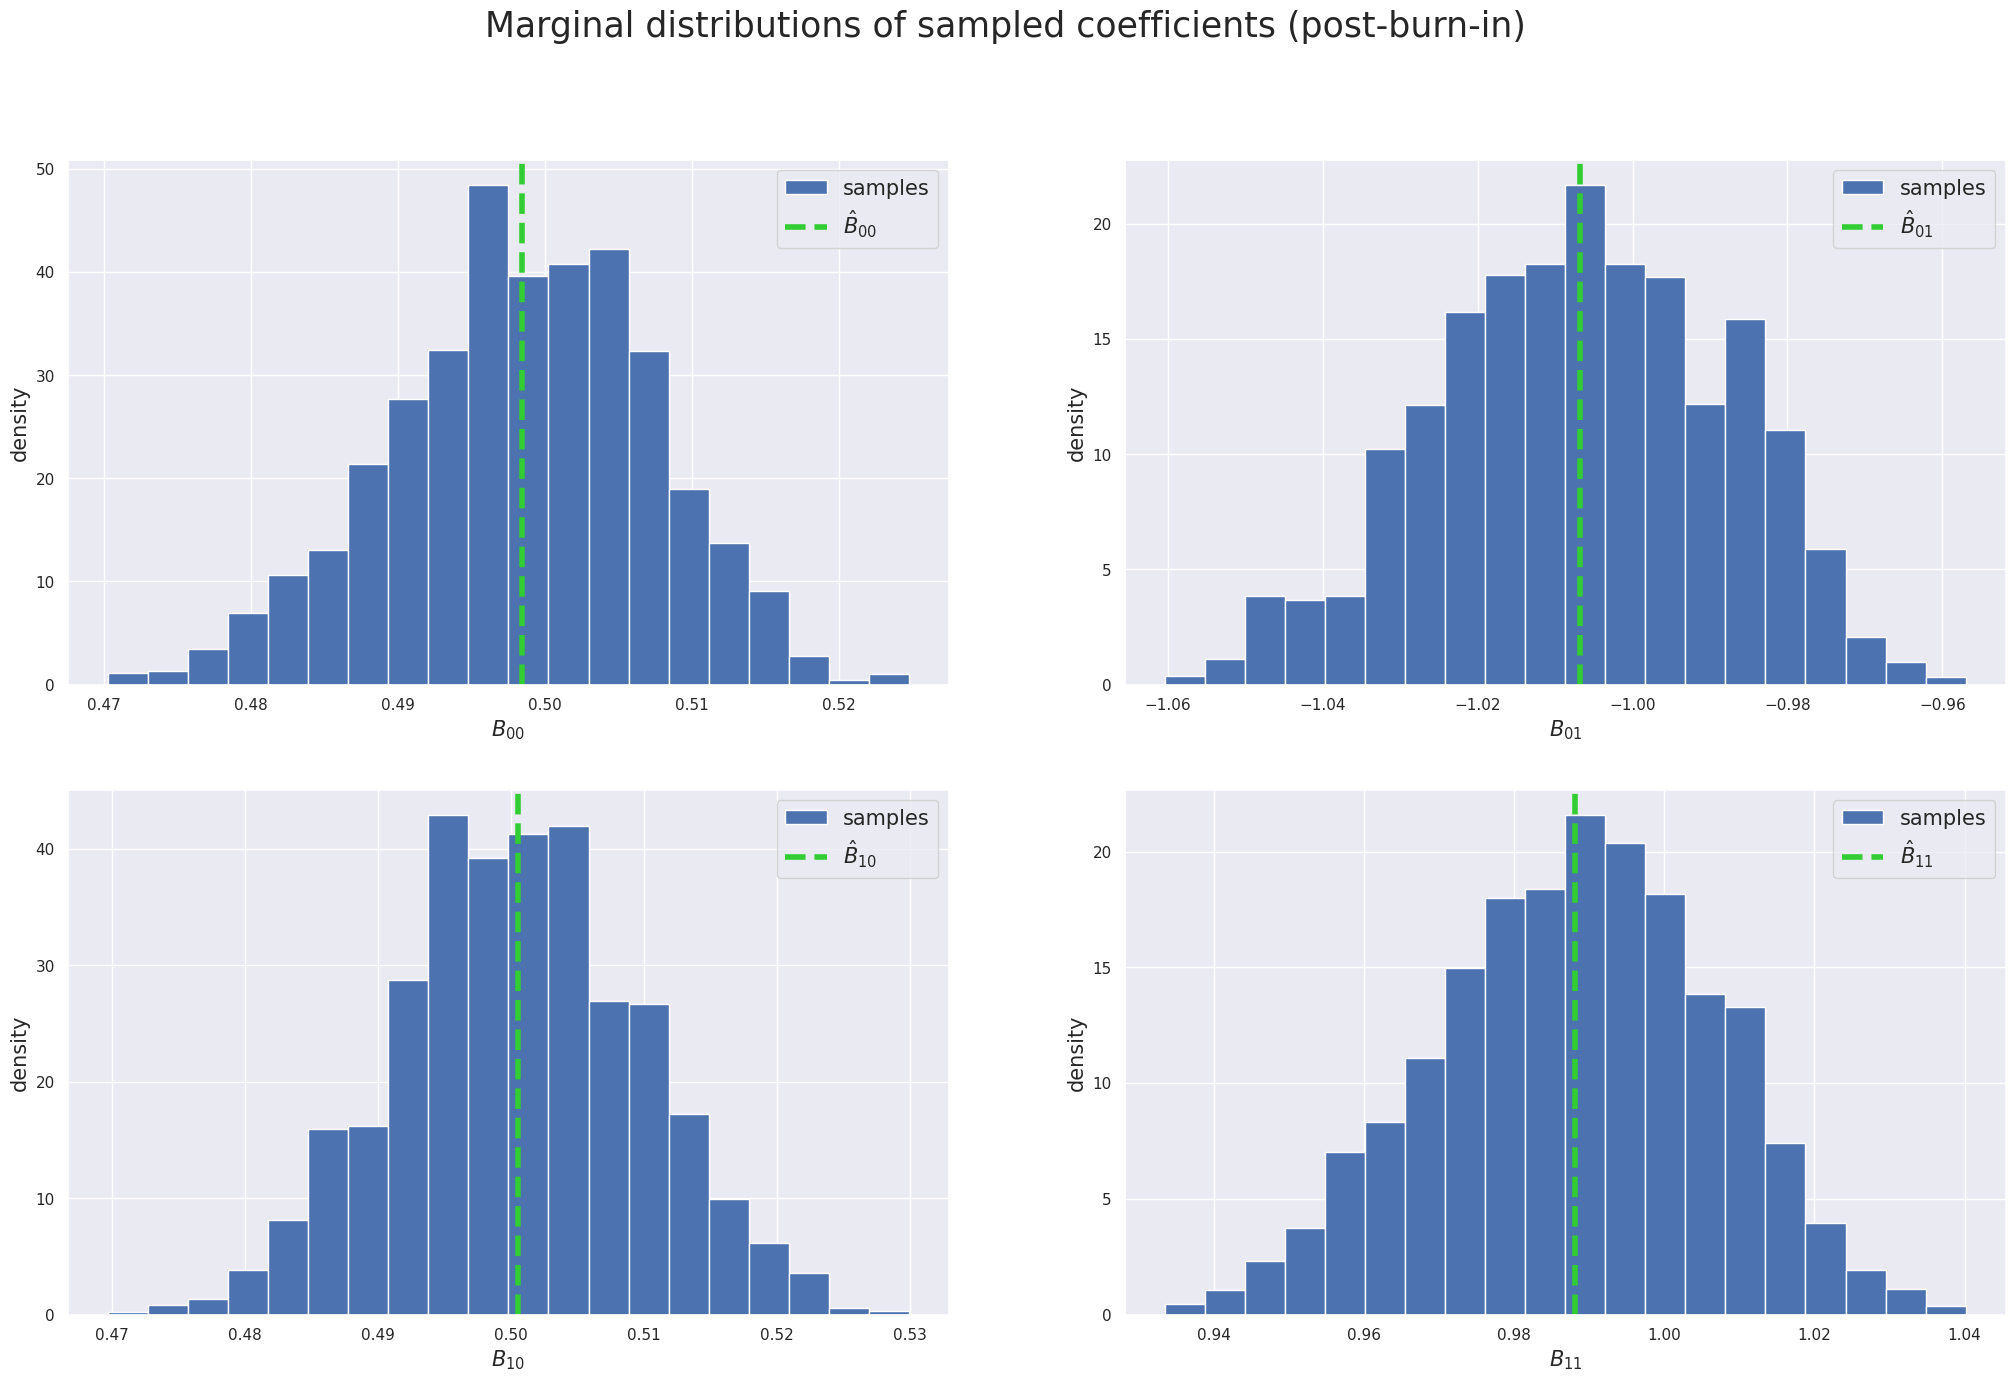

In [64]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.3.6. Plot evolution of log-posterior

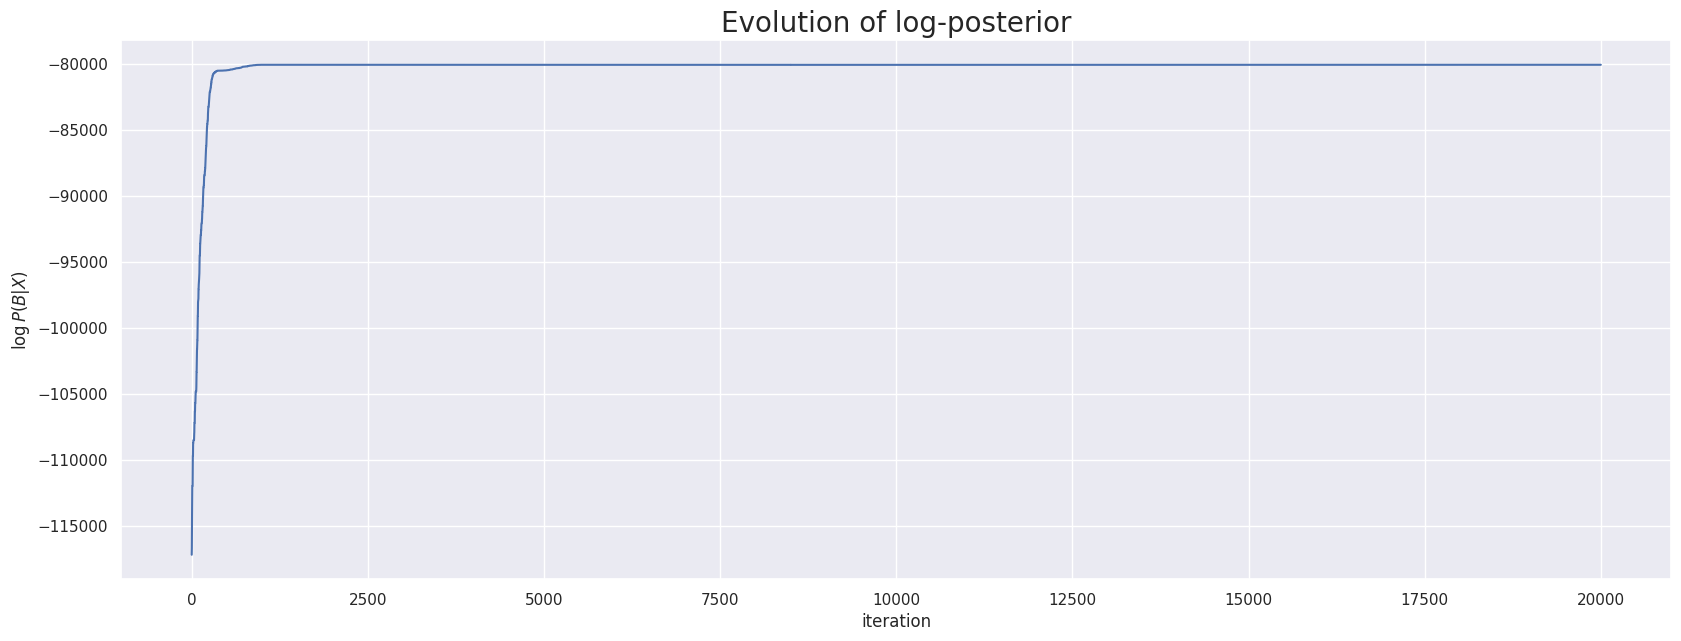

In [65]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 1.3.7. Plot source separation results

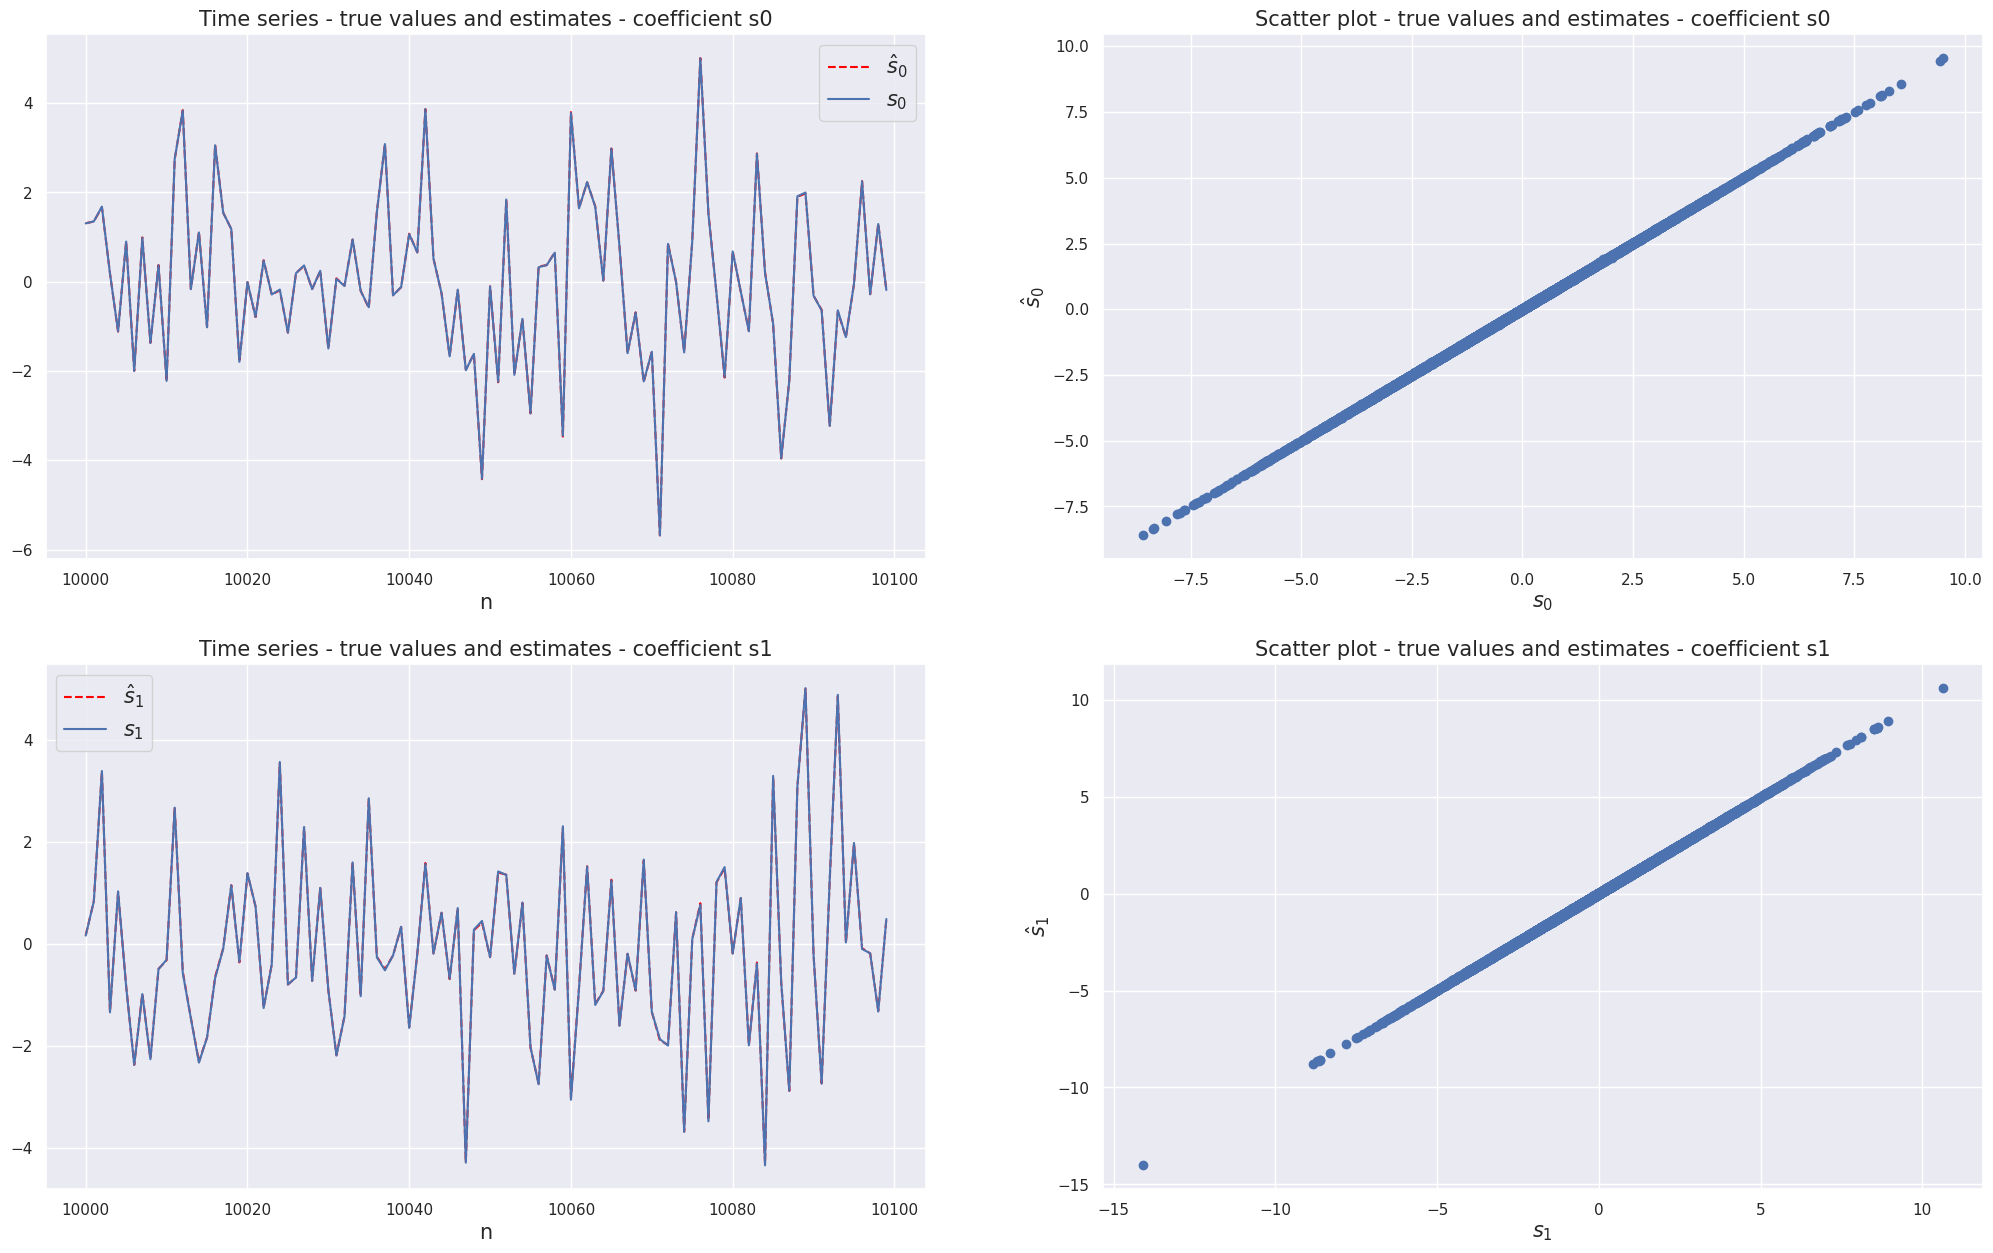

In [66]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [67]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['likelihood'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 6.443230754863028e-05


## 1.4. Perform Analysis - DETERMINANT PRIOR
#### Prior:
$p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} (det(\boldsymbol{B}) - 1)^2 \right]$

### 1.4.1 Execute MCMC Sampling

In [68]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    sig=0.1
    desired_det=1
    return (1/np.sqrt(2*np.pi*np.square(sig)))*np.exp(-np.square(np.linalg.det(B)-desired_det)/(2*np.square(sig)))

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [69]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'determinant_prior'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 151 ms, sys: 183 ms, total: 334 ms
Wall time: 36.1 ms


### 1.4.2. Parse MCMC Results

In [70]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [71]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.49871611 -1.00743   ]
 [ 0.50097232  0.98869315]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [72]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-80053.60660143394,
 -80053.6343697393,
 -80053.63215393704,
 -80053.6289123958,
 -80053.62113600581,
 -80053.61700970615,
 -80053.63514549304,
 -80053.65505414097,
 -80053.64497313174,
 -80053.64859238772,
 -80053.64063177472,
 -80053.6488442792,
 -80053.62816852065,
 -80053.61961635797,
 -80053.61960027601,
 -80053.62660110756,
 -80053.63724373339,
 -80053.63920657207,
 -80053.6200407372,
 -80053.61636565282,
 -80053.62881372598,
 -80053.61539842251,
 -80053.6067639257,
 -80053.68365641253,
 -80053.6316916774,
 -80053.62175274704,
 -80053.62532382393,
 -80053.61780760702,
 -80053.6276333792,
 -80053.64438022519]

In [73]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.49871611, -1.00743   ],
        [ 0.50097232,  0.98869315]]),
 array([[ 0.50198265,  0.98557608],
        [-0.49713648,  1.00996934]]),
 array([[-0.49843681,  1.0074883 ],
        [-0.50076877, -0.98789725]]),
 array([[-0.49769572,  1.0088967 ],
        [-0.50154268, -0.98601422]]),
 array([[-0.50244781, -0.98499765],
        [ 0.49711006, -1.01070955]]),
 array([[-0.501246  , -0.987231  ],
        [-0.49791571,  1.00886801]]),
 array([[ 0.50139325,  0.98679648],
        [-0.49804155,  1.00876862]]),
 array([[-0.50025163, -0.98939074],
        [ 0.49928822, -1.00607123]]),
 array([[-0.49772669,  1.00896518],
        [-0.5015766 , -0.98637275]]),
 array([[-0.50109241, -0.98747496],
        [-0.49824435,  1.00820399]]),
 array([[ 0.49803165, -1.00878179],
        [ 0.50132798,  0.98673094]]),
 array([[-0.50062996, -0.98877587],
        [ 0.49863496, -1.00623269]]),
 array([[-0.49709529,  1.01068658],
        [ 0.50209077,  0.98471868]]),
 array([[-0.49830148,  1.00747832],
  

### 1.4.3. Plot sampled coefficients stochastic process - Markov Chain evolution

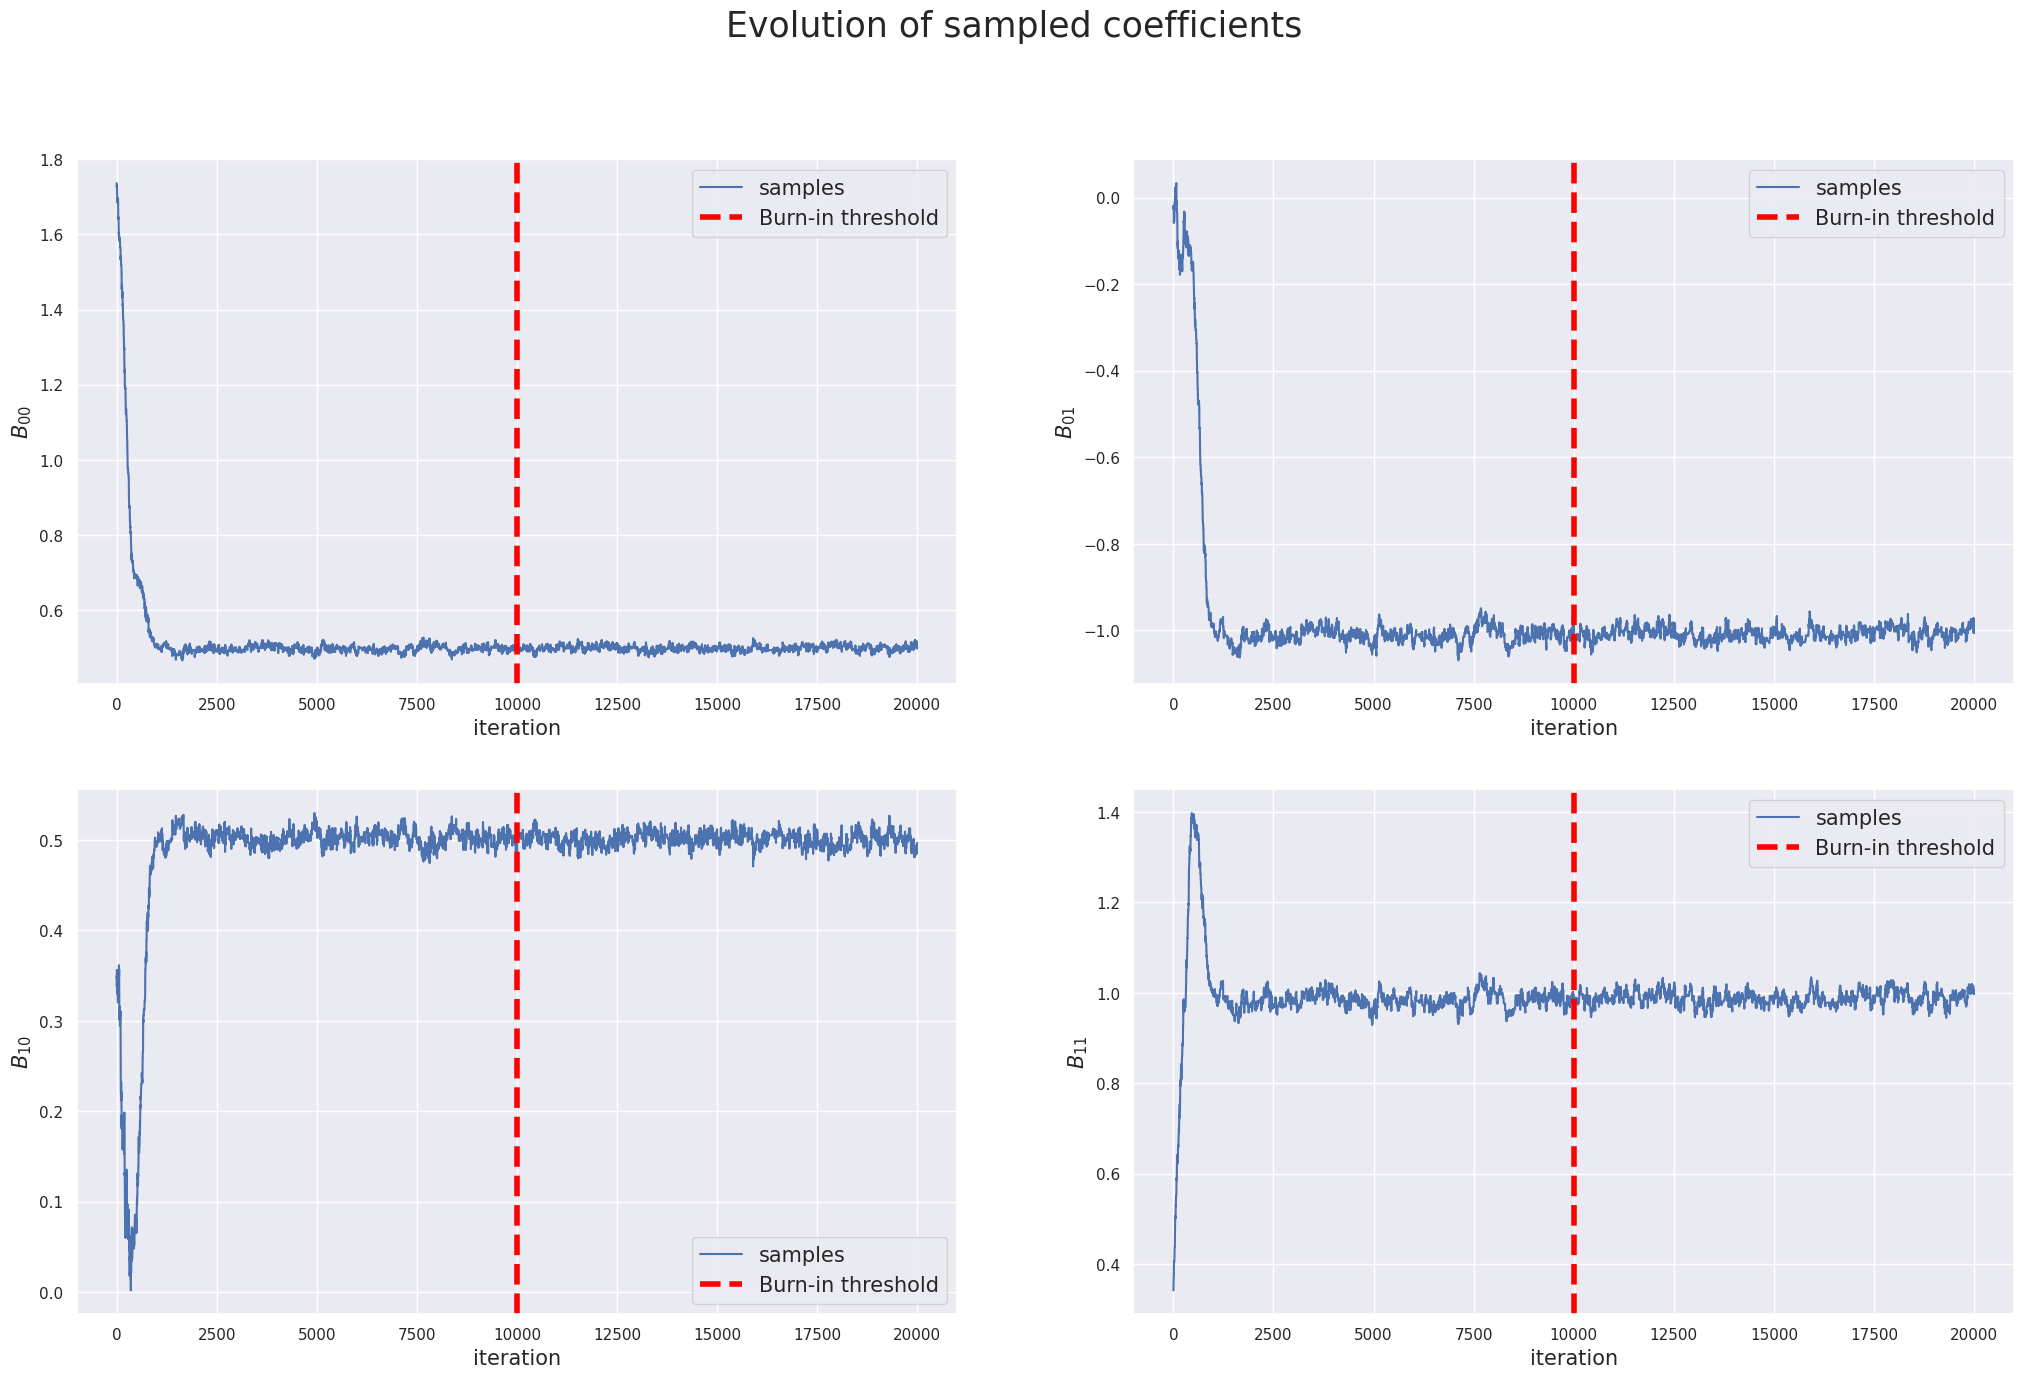

In [74]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.4.4. Plot sampled coefficients distributions - Markov Chain evolution

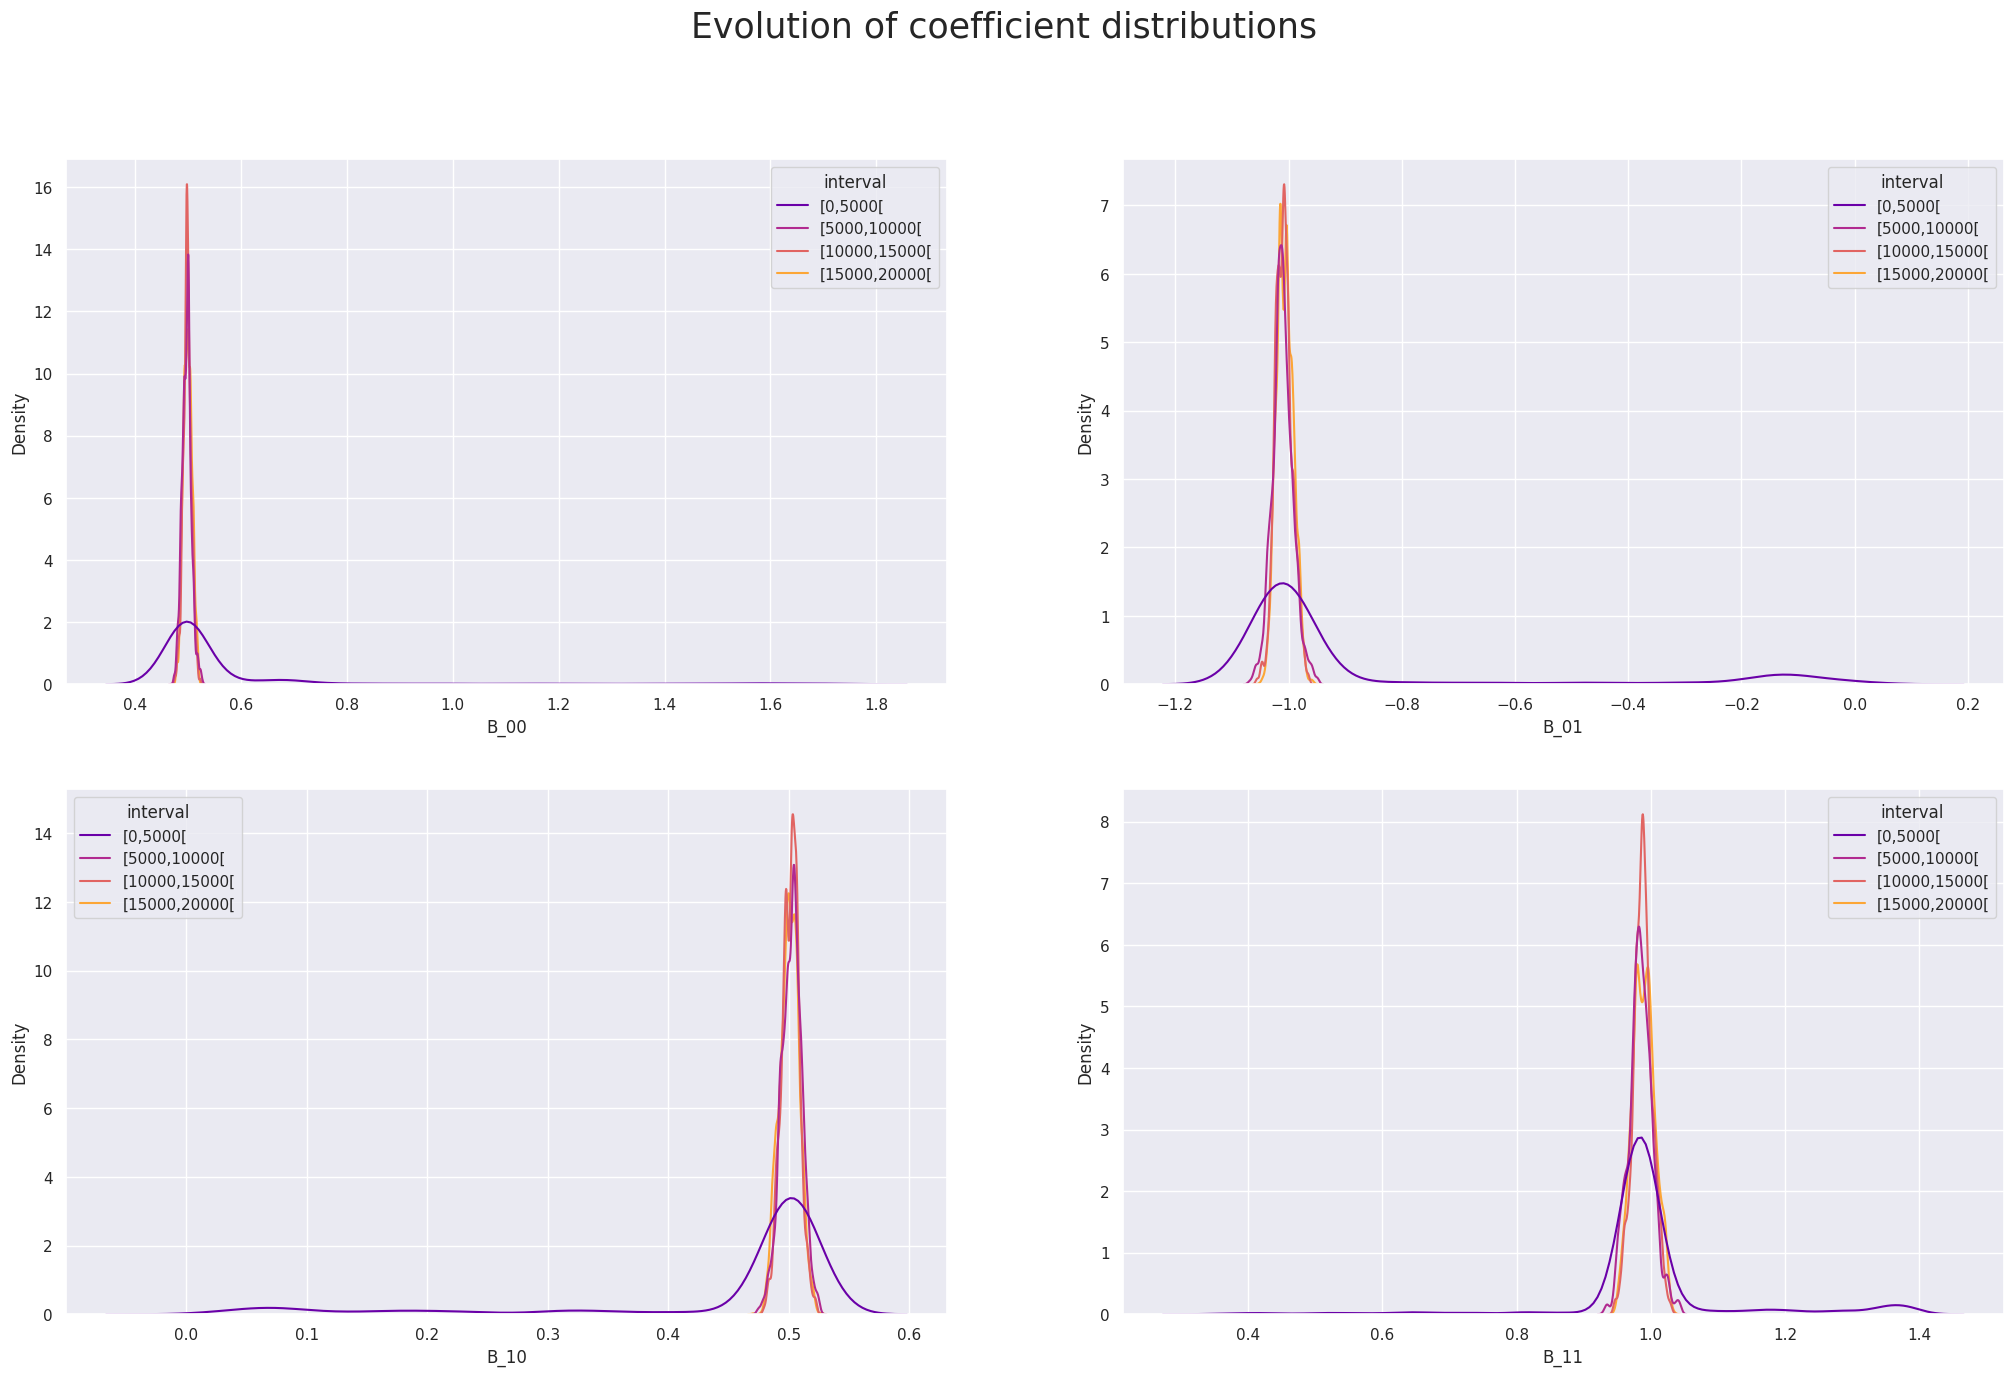

In [75]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.4.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

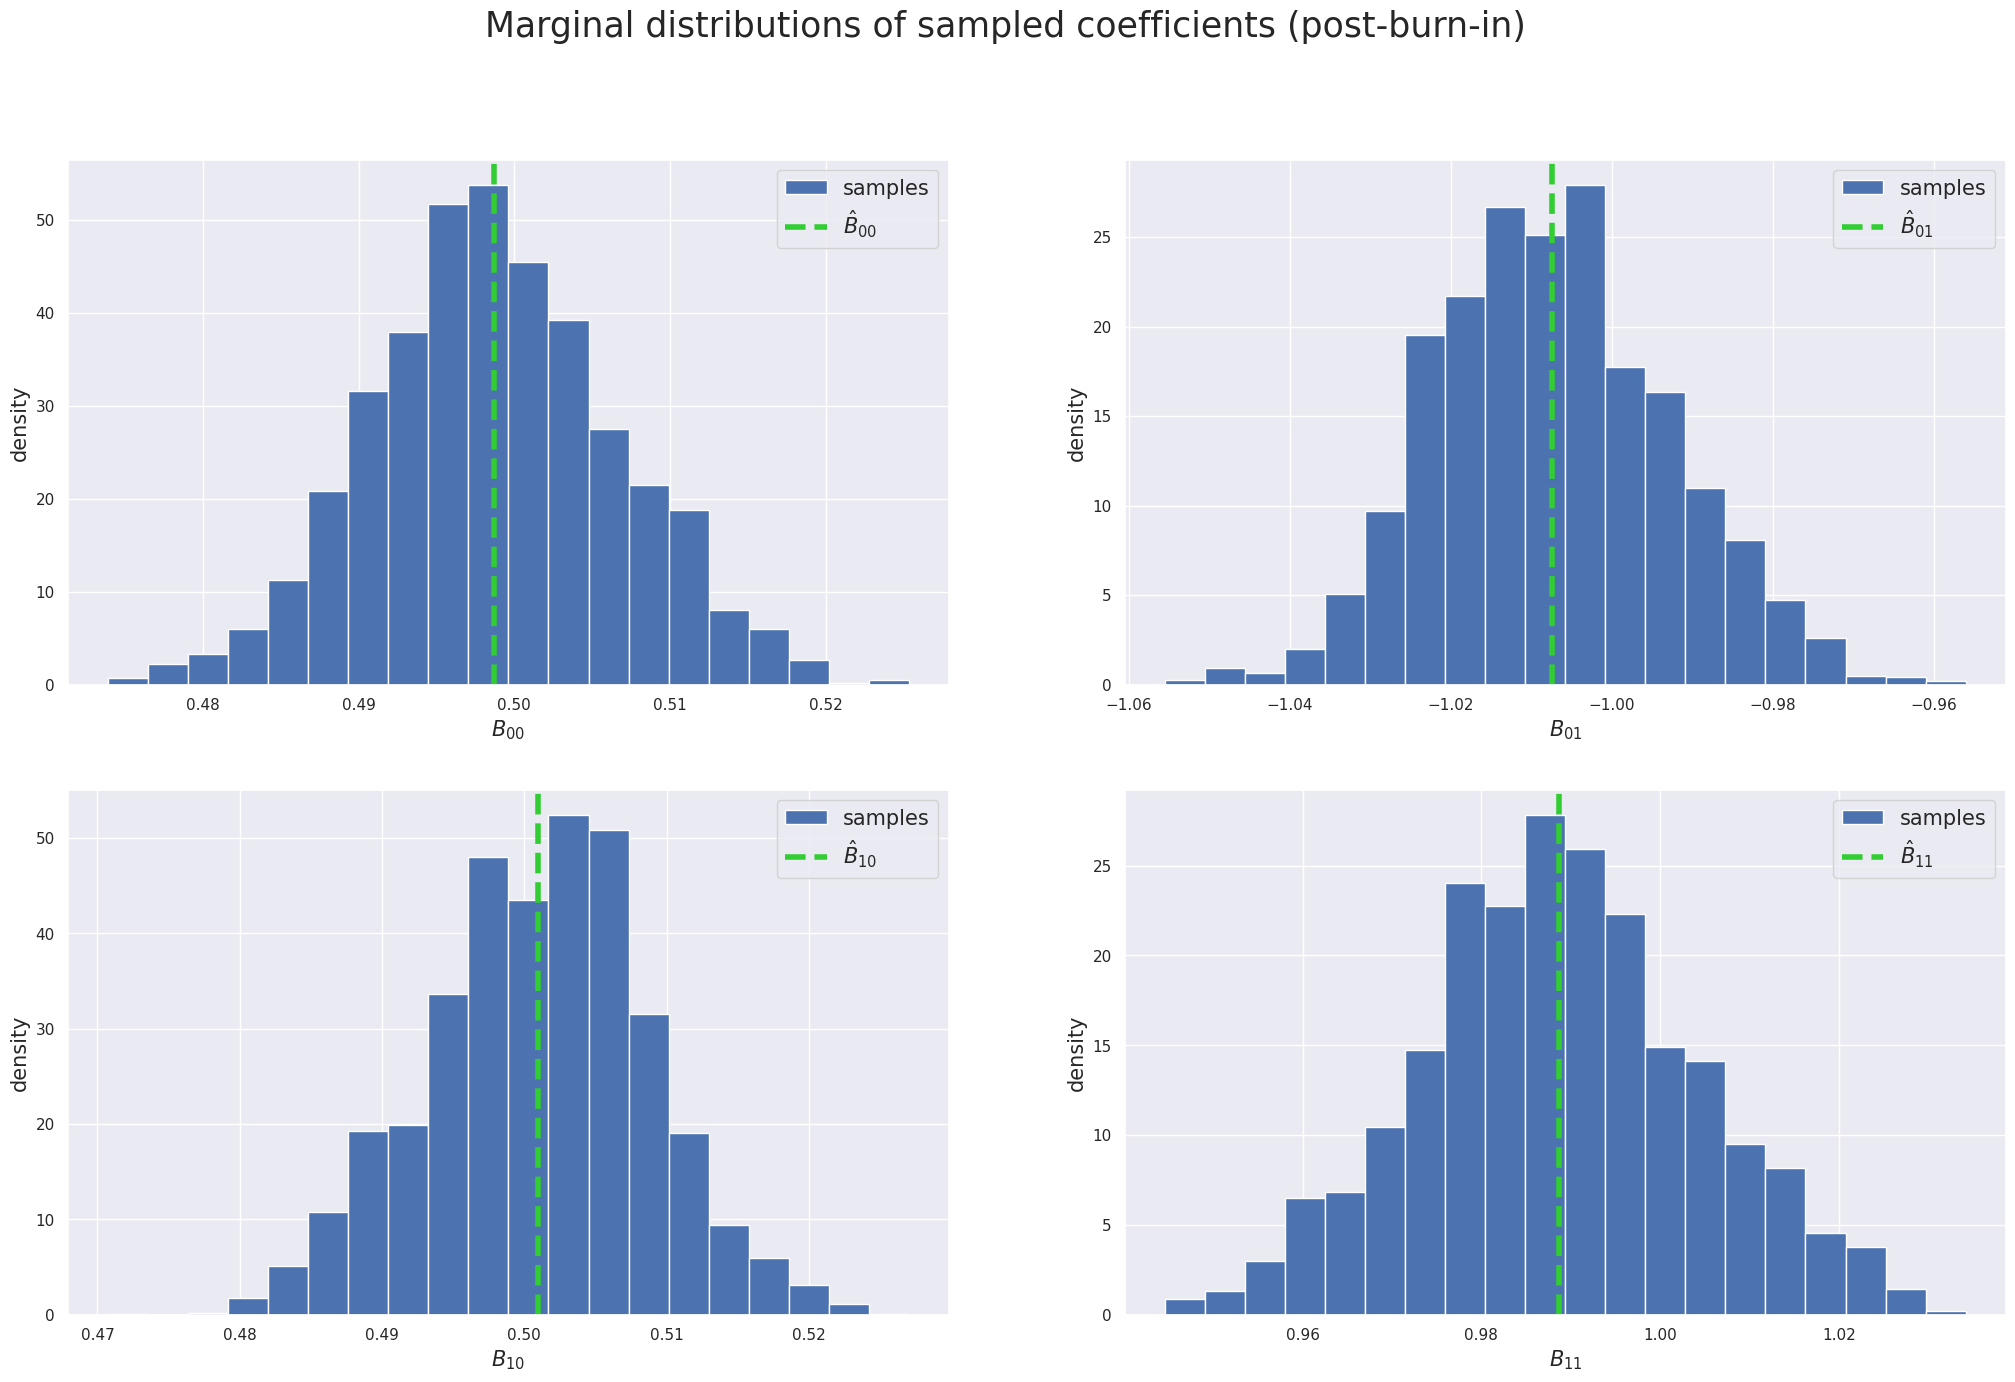

In [76]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.4.6. Plot evolution of log-posterior

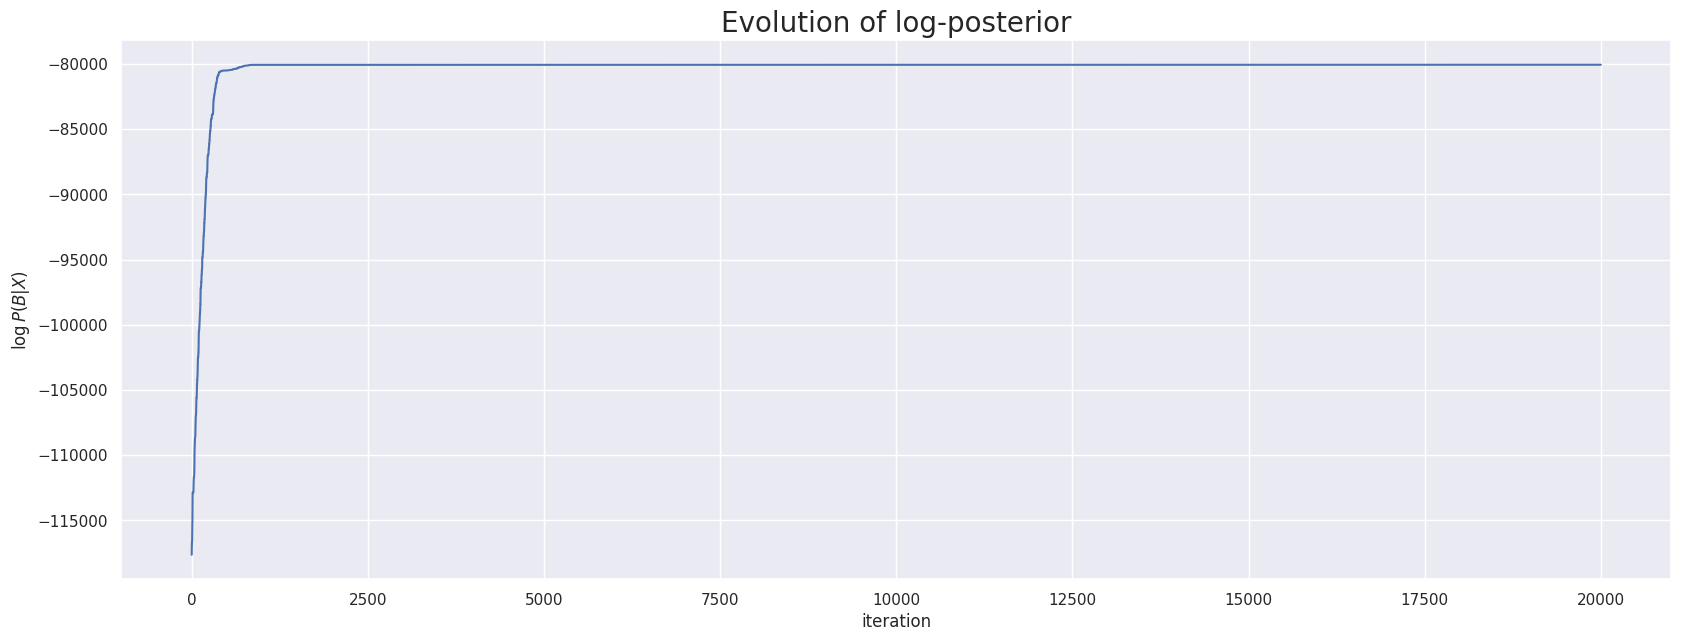

In [77]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 1.4.7. Plot source separation results

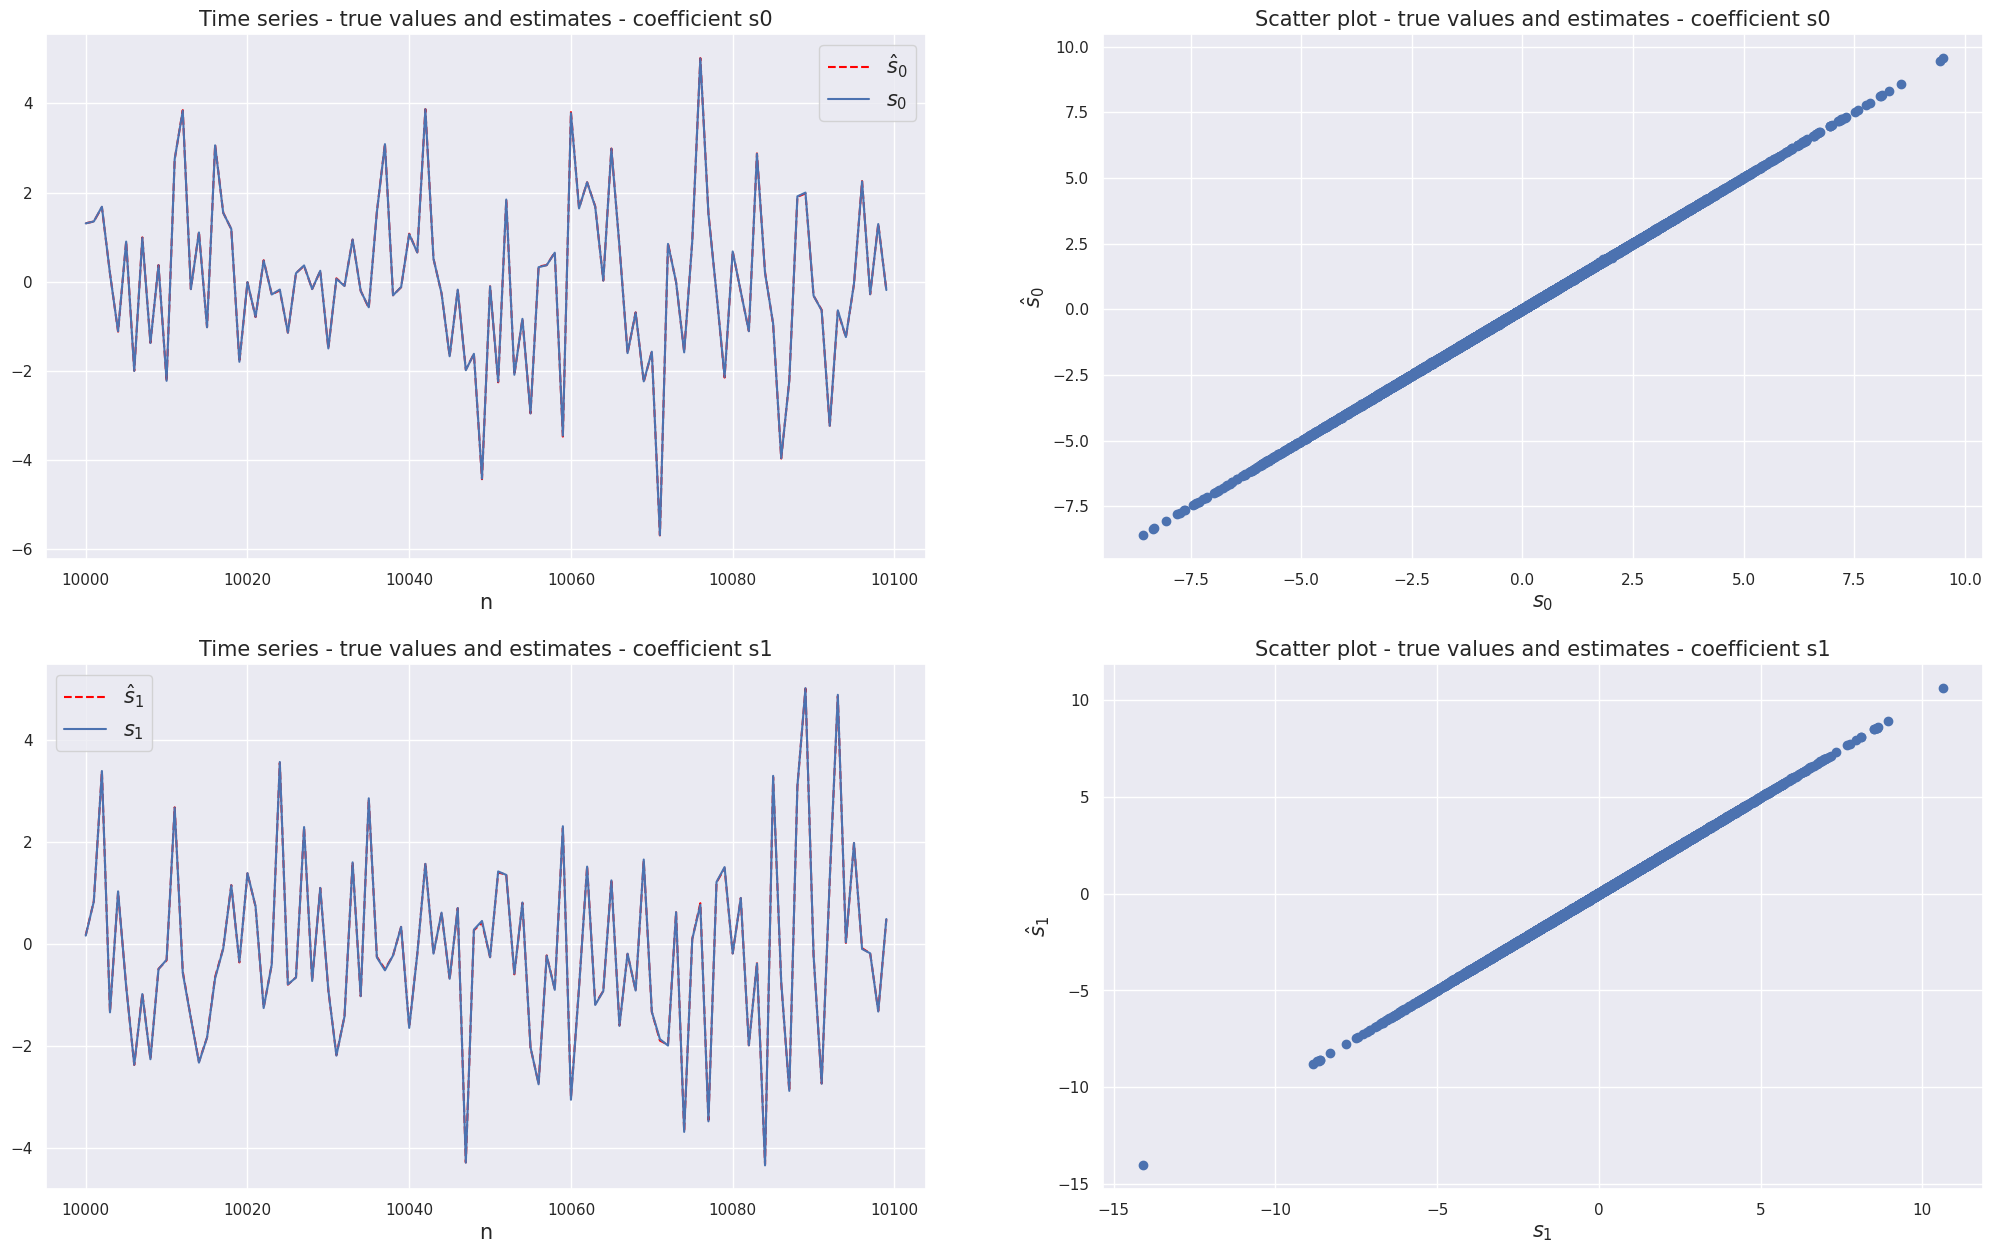

In [78]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [79]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['determinant_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 6.319216406611947e-05


## 1.5. Perform Analysis - near-identity transformation
#### Prior:
#### $p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} ||\boldsymbol{B} - \boldsymbol{I}||^2 \right]$

### 1.5.1 Execute MCMC Sampling

In [80]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(X):
    sig=0.1
    return np.exp(
        (-1/2/np.square(sig))*np.linalg.norm(X-np.eye(X.shape[0]))
    )

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [81]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'identity_transformation'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 55.3 ms, sys: 79.7 ms, total: 135 ms
Wall time: 20.7 ms


### 1.5.2. Parse MCMC Results

In [82]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [83]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.5032727   0.98352083]
 [-0.49635927  1.01186169]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [84]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-80053.6177038962,
 -80053.61430482875,
 -80053.62561235623,
 -80053.6649199096,
 -80053.62535281955,
 -80053.61985544483,
 -80053.62377264959,
 -80053.61532748281,
 -80053.61556015376,
 -80053.62072291563,
 -80053.61727844161,
 -80053.62160554595,
 -80053.6427582238,
 -80053.63921699148,
 -80053.61724944801,
 -80053.63993418998,
 -80053.61102581878,
 -80053.61921194491,
 -80053.60295179226,
 -80053.64208389429,
 -80053.62522903606,
 -80053.63824202196,
 -80053.65014770906,
 -80053.61914966135,
 -80053.62705803945,
 -80053.63812693131,
 -80053.62139438765,
 -80053.65382877886,
 -80053.63493454228,
 -80053.61601510951]

In [85]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.5032727 ,  0.98352083],
        [-0.49635927,  1.01186169]]),
 array([[ 0.50031031,  0.98899863],
        [-0.49915191,  1.0062691 ]]),
 array([[-0.50038066,  1.00330093],
        [-0.49902308, -0.99218316]]),
 array([[ 0.50103531,  0.98826264],
        [-0.49857842,  1.0080236 ]]),
 array([[-0.50376705, -0.98293135],
        [ 0.49583836, -1.0135065 ]]),
 array([[-0.49977361, -0.99067316],
        [-0.4997653 ,  1.00531062]]),
 array([[ 0.50322521,  0.98270901],
        [-0.49588728,  1.01328398]]),
 array([[-0.50187854, -0.98533827],
        [ 0.49733537, -1.00963074]]),
 array([[-0.49752044,  1.00988664],
        [-0.50169133, -0.98597751]]),
 array([[ 0.49851246, -1.00697554],
        [ 0.50082664,  0.98775283]]),
 array([[ 0.49772475, -1.00835497],
        [ 0.50164807,  0.98641535]]),
 array([[-0.50146194, -0.98712629],
        [ 0.49823739, -1.00803344]]),
 array([[-0.49841144,  1.00750605],
        [ 0.5010373 ,  0.98768583]]),
 array([[-0.49846667,  1.00788348],
  

### 1.5.3. Plot sampled coefficients stochastic process - Markov Chain evolution

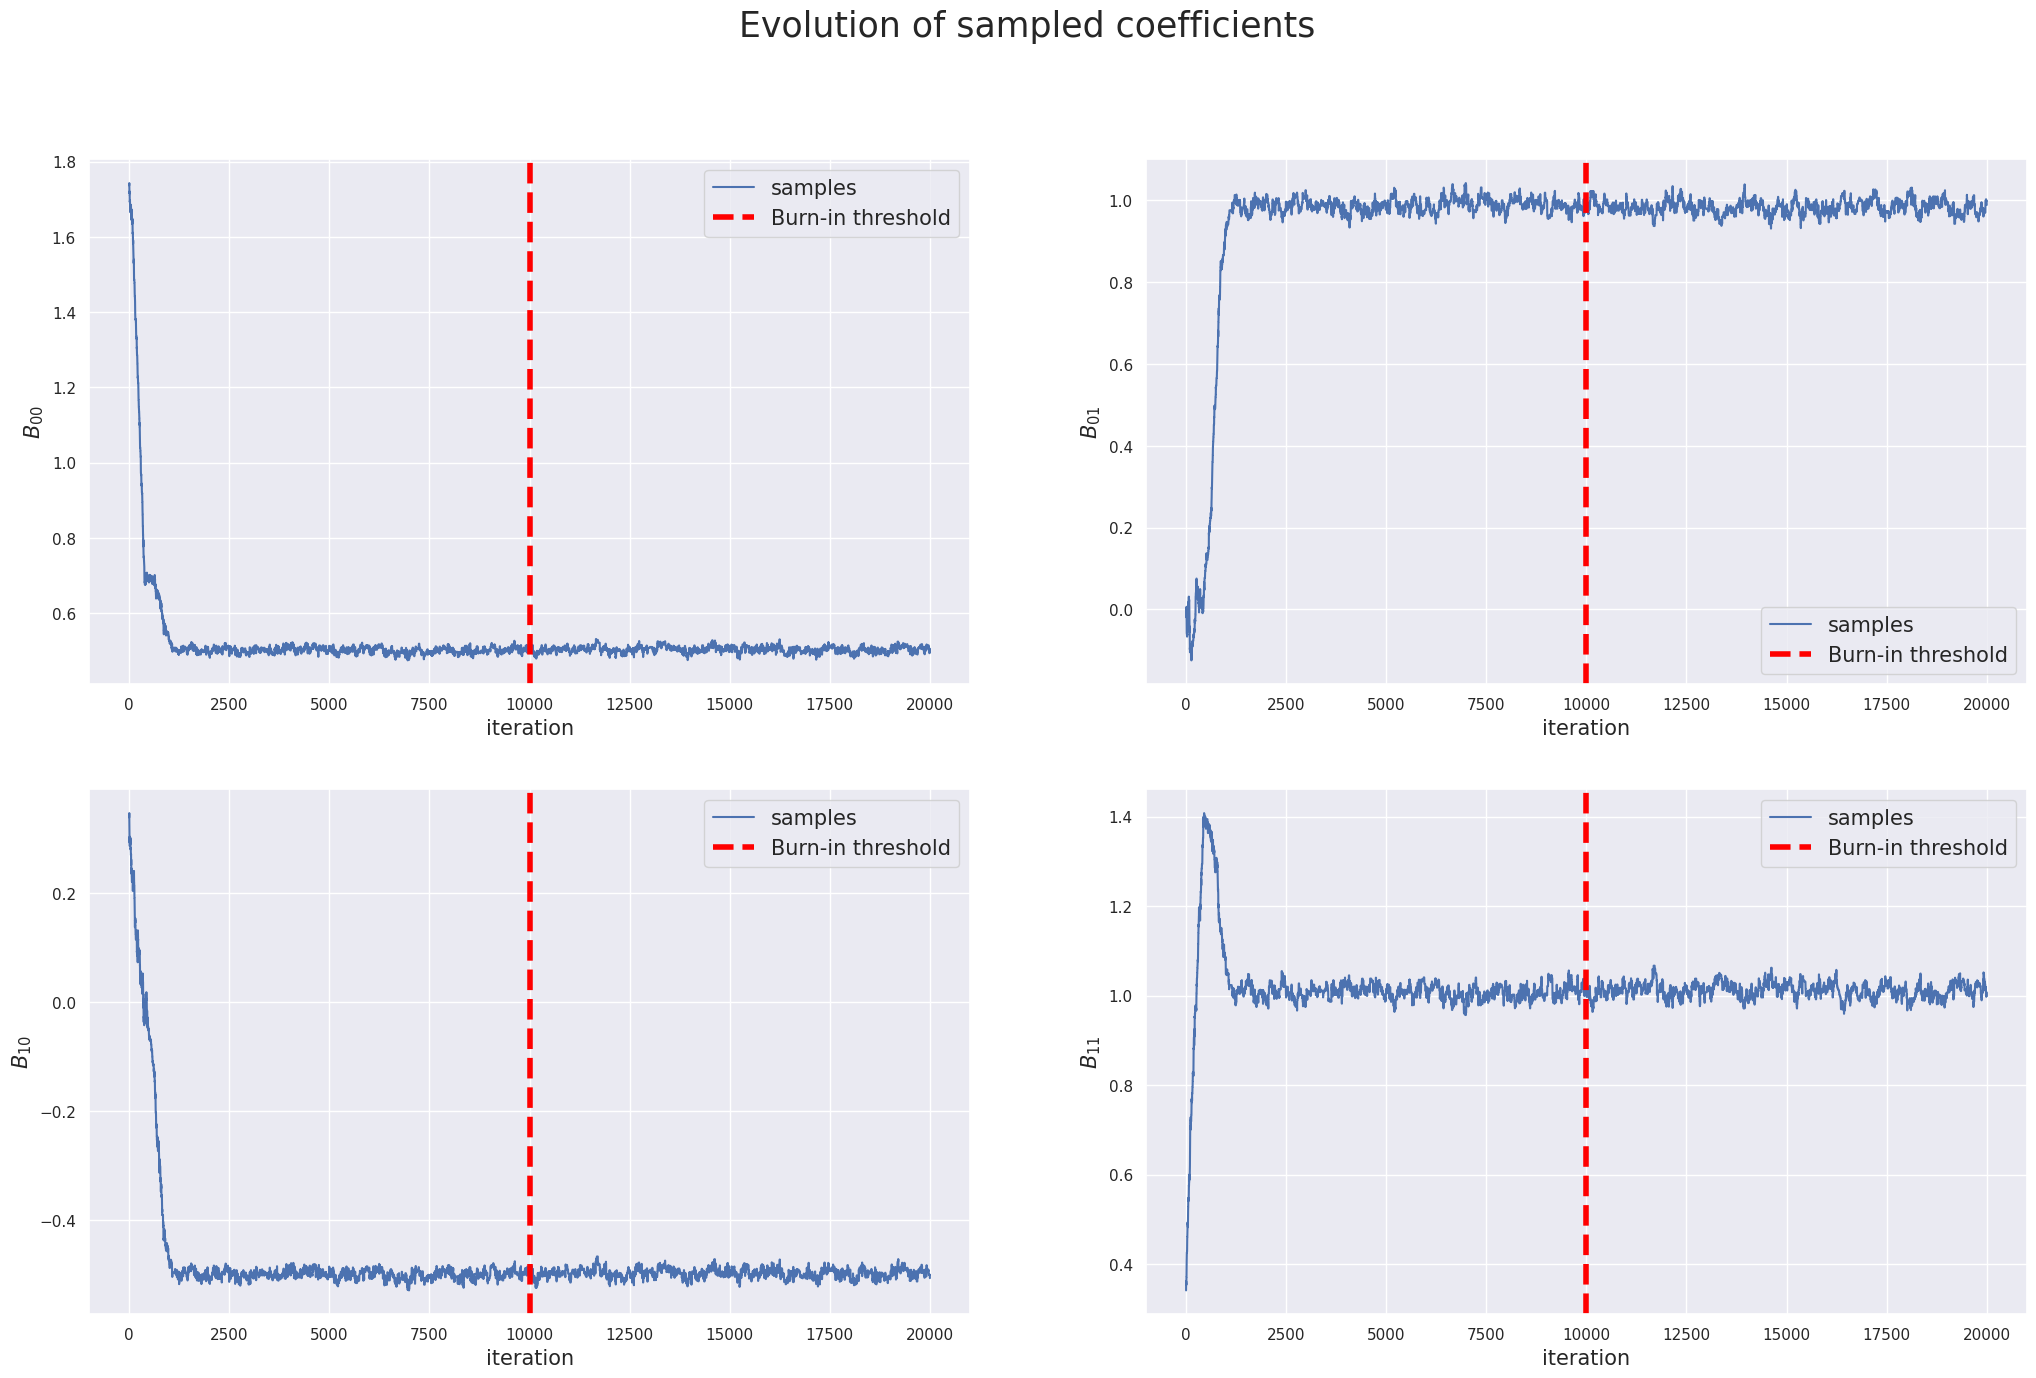

In [86]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.5.4. Plot sampled coefficients distributions - Markov Chain evolution

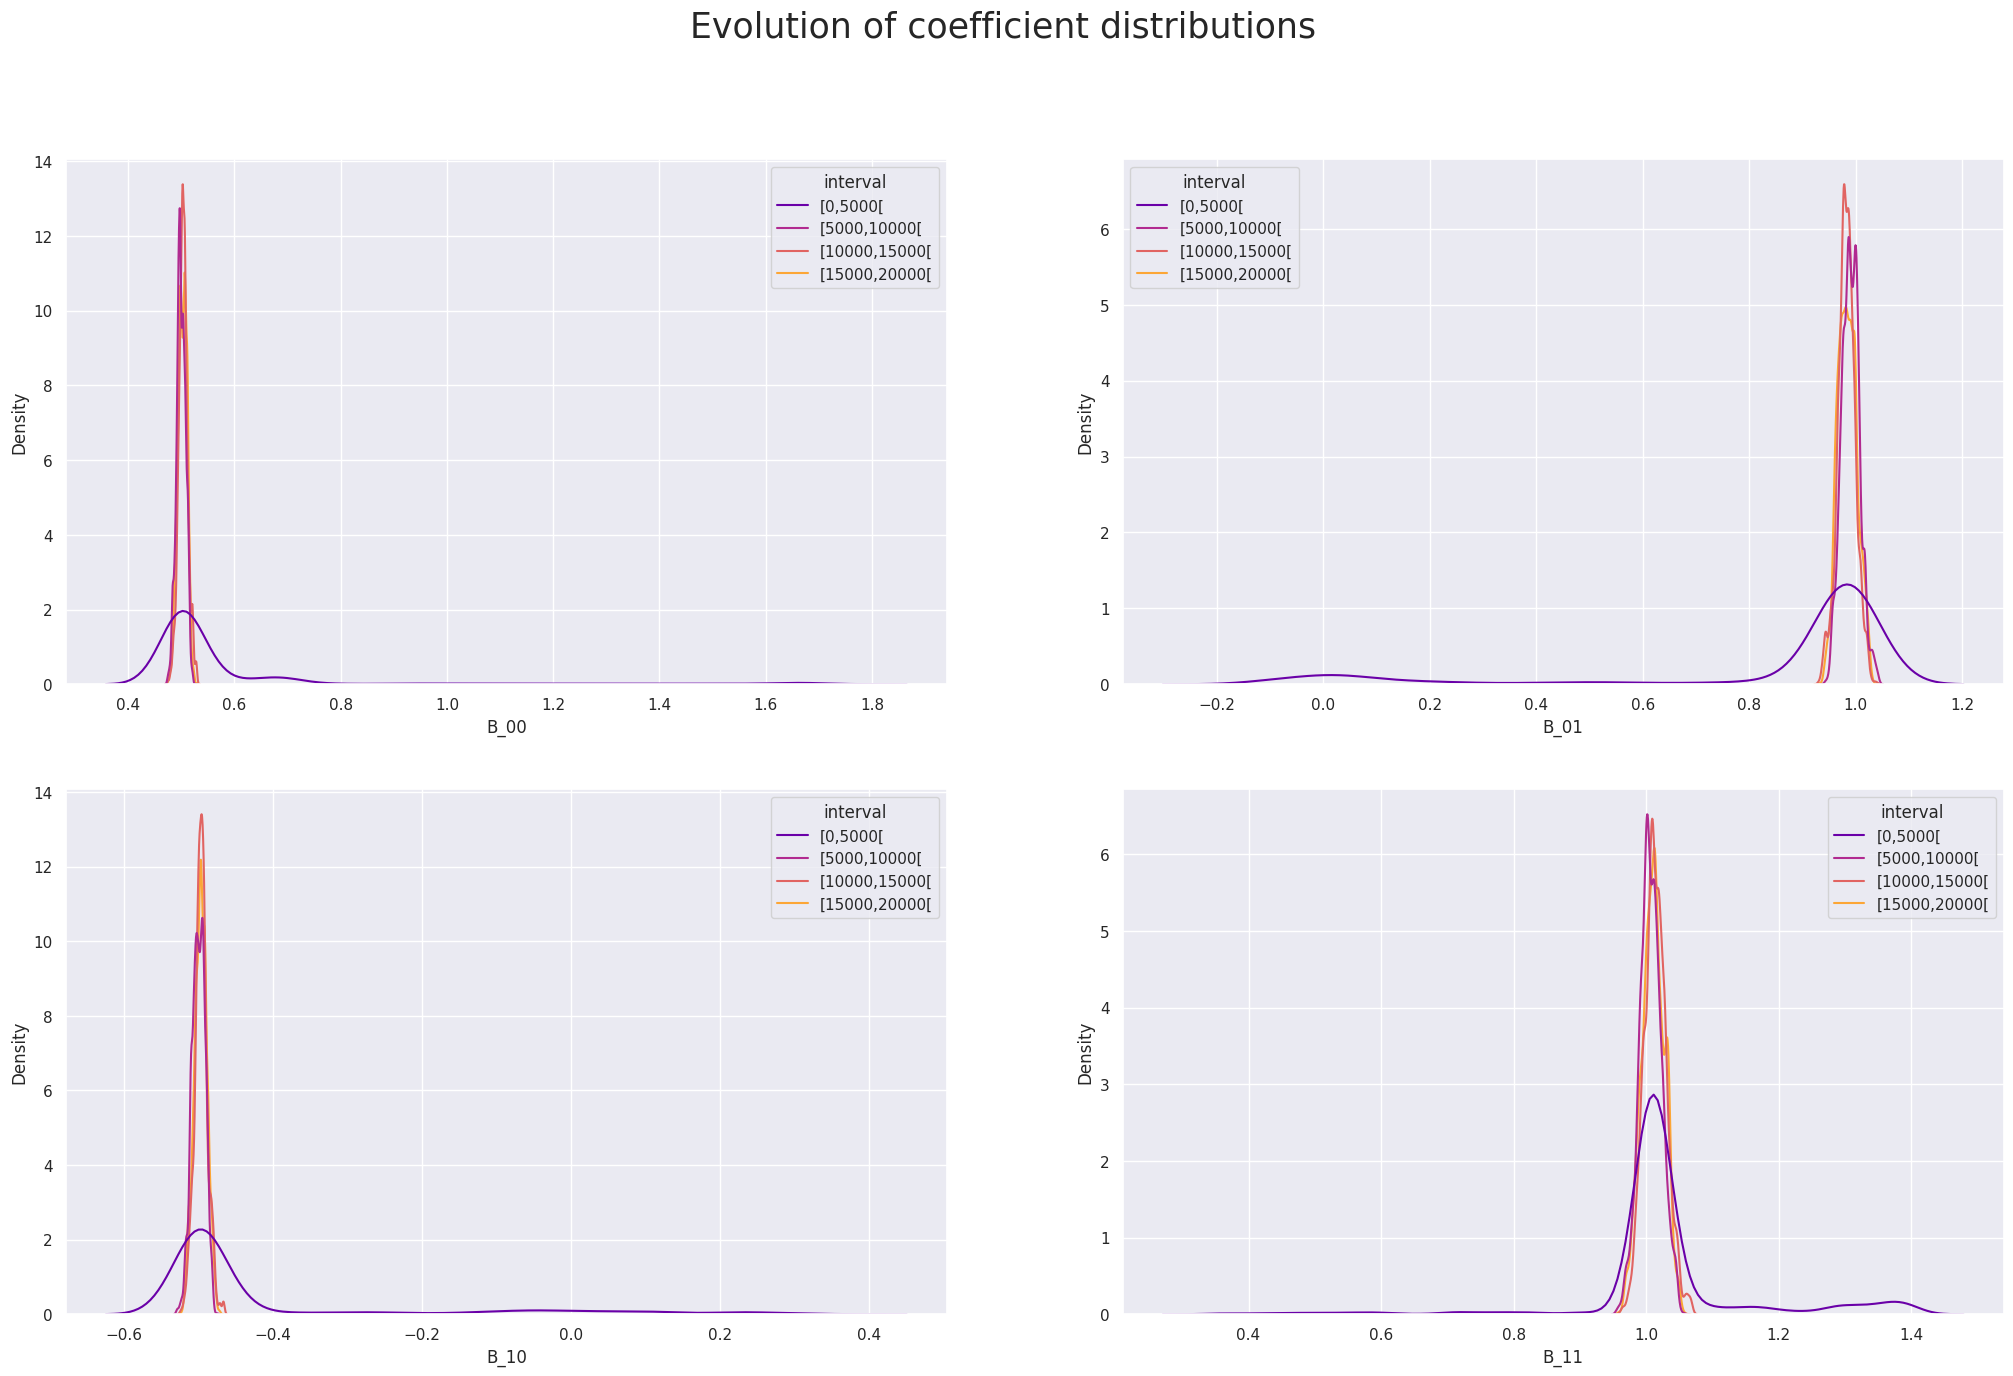

In [87]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.5.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

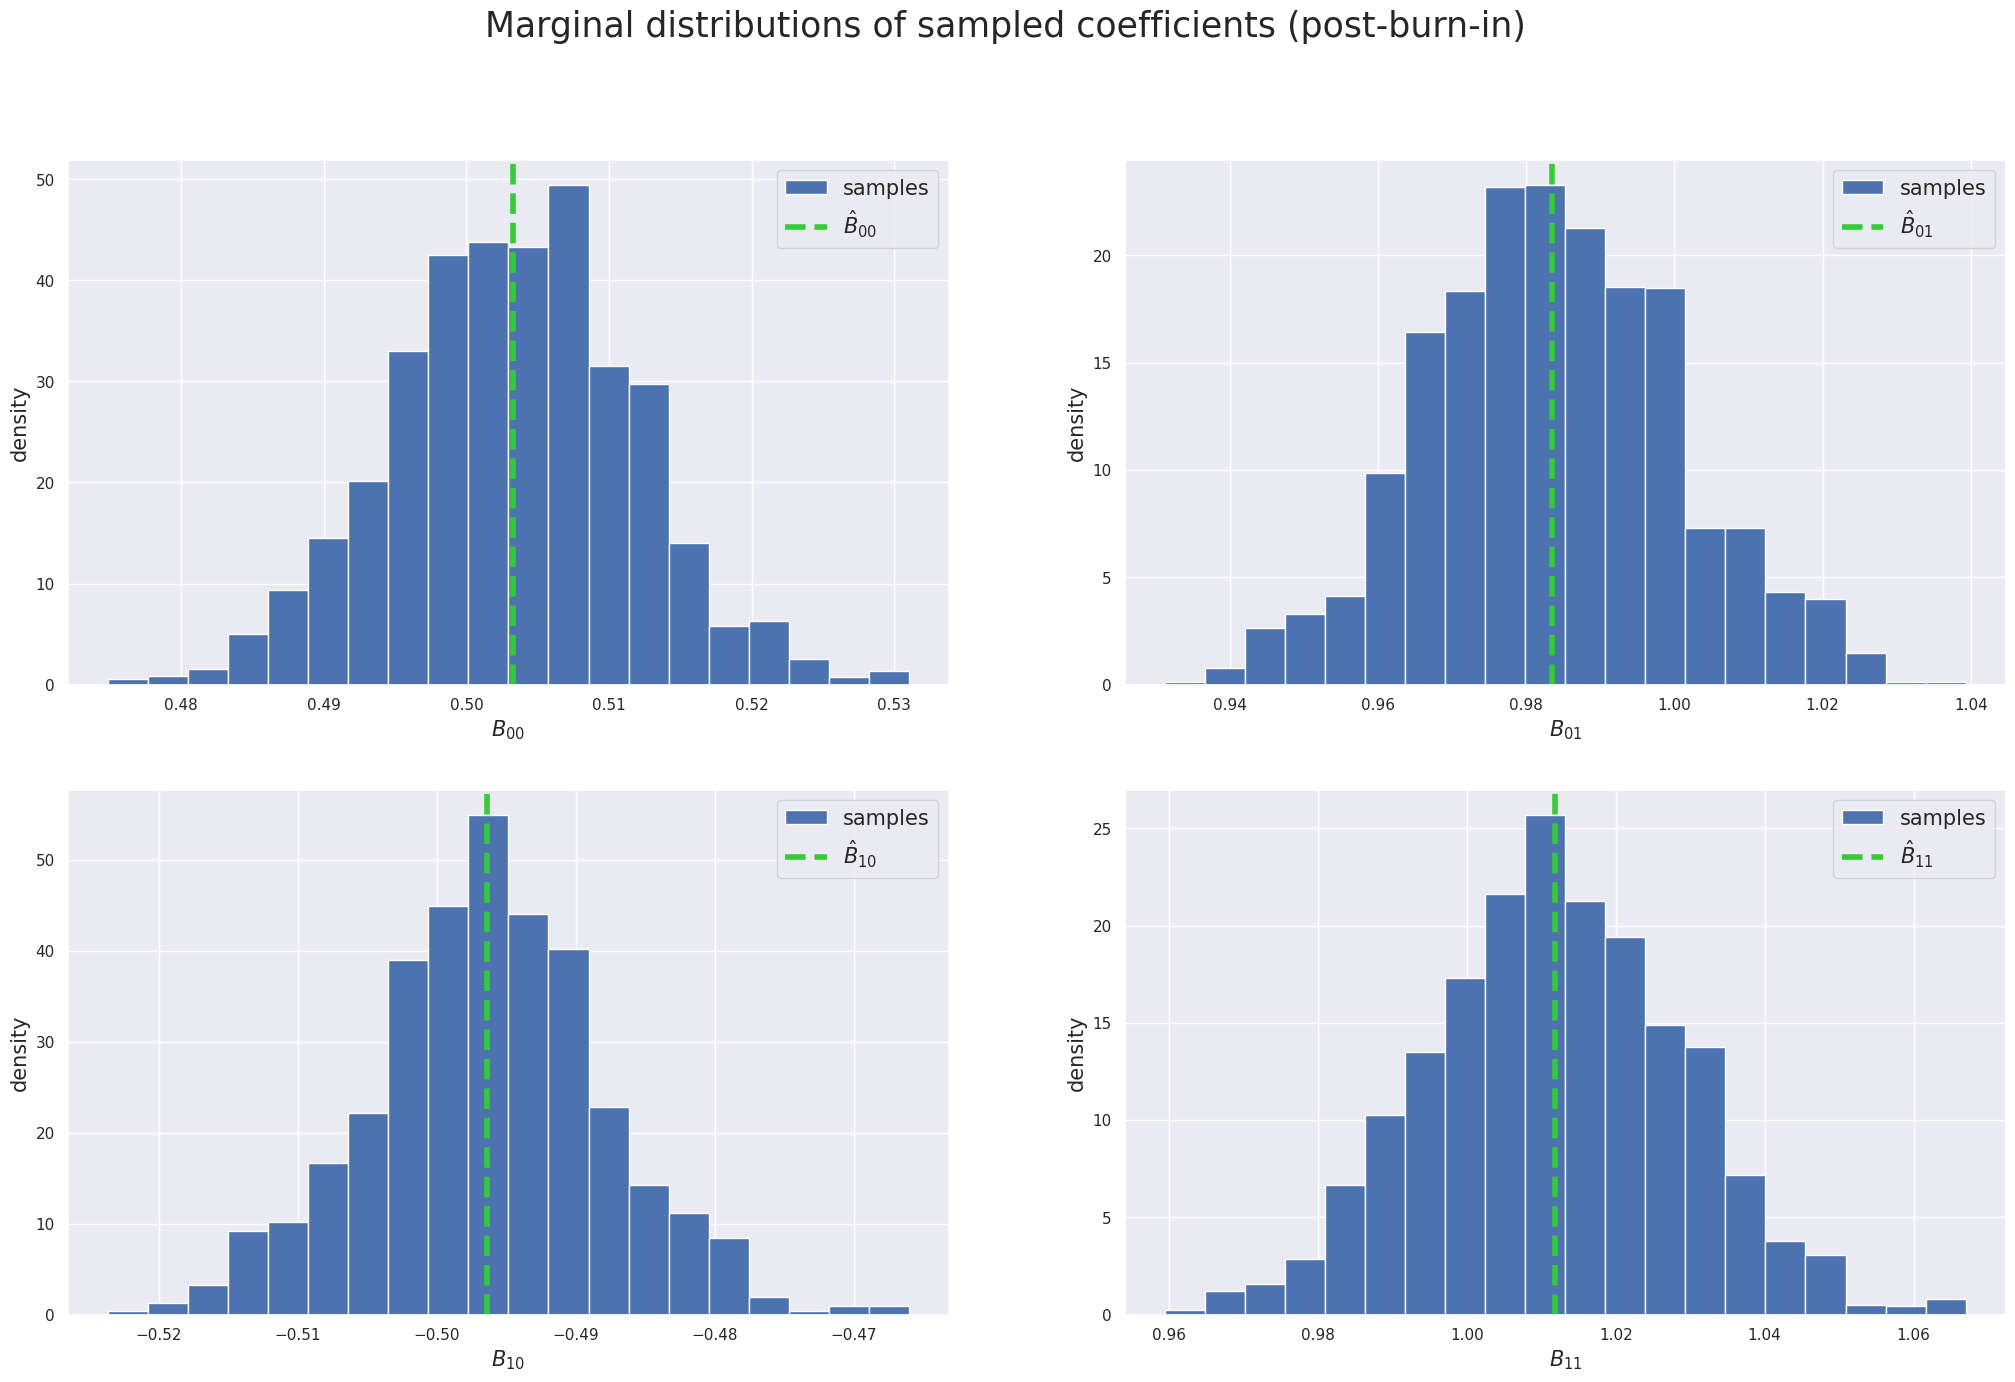

In [88]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 1.5.6. Plot evolution of log-posterior

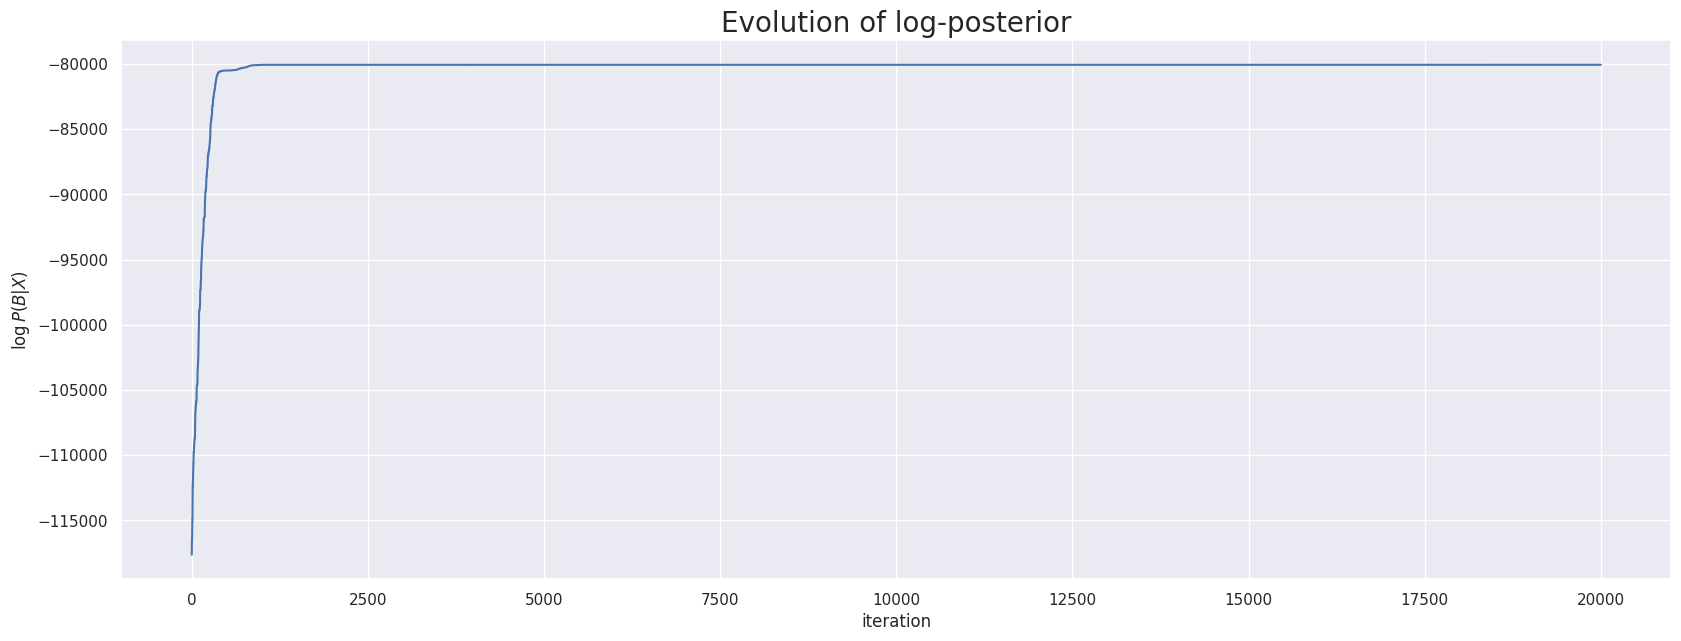

In [89]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 1.5.7. Plot source separation results

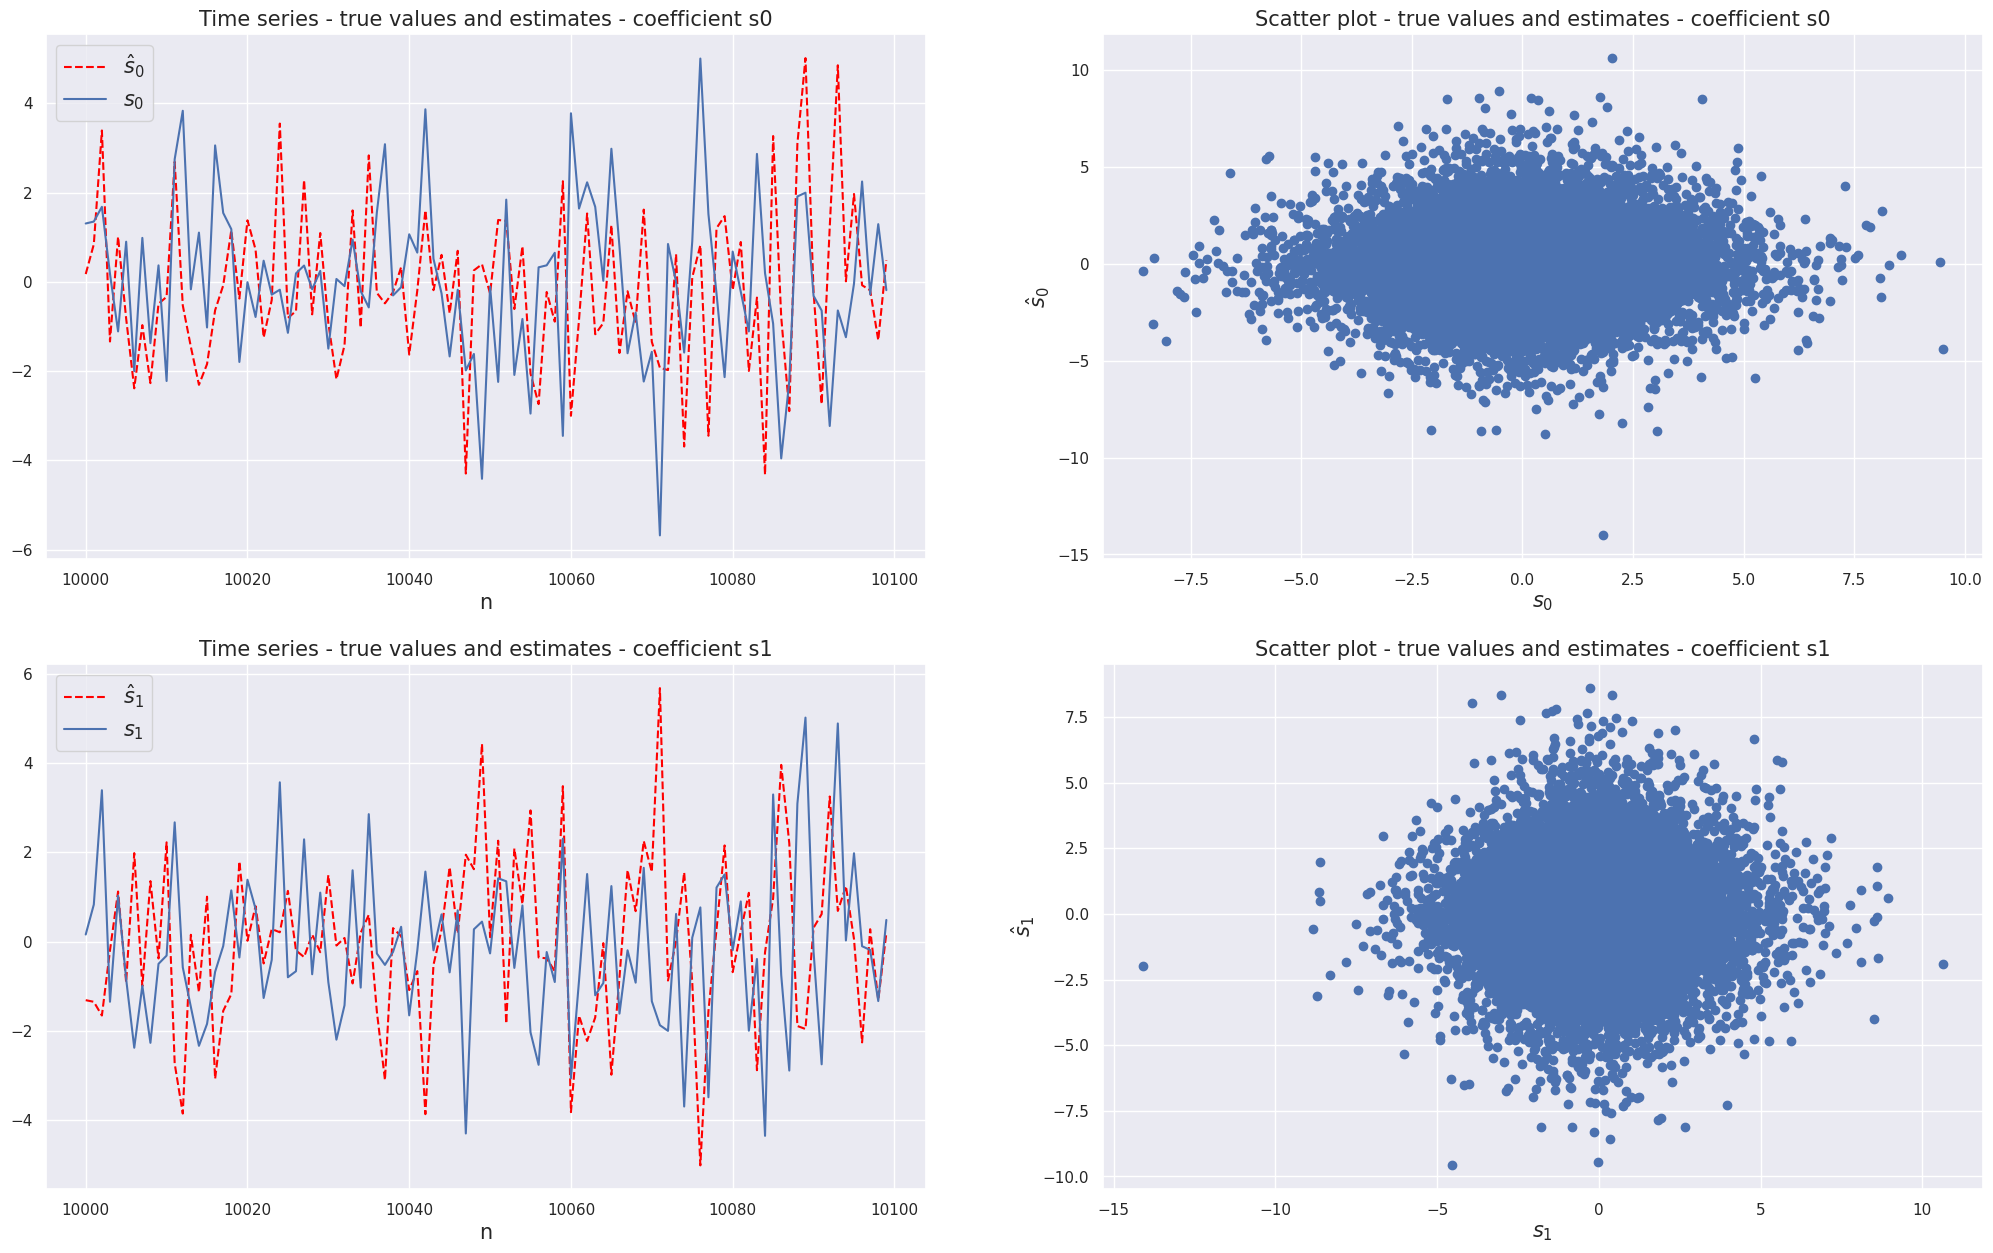

In [90]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [91]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['perfect_model']['near_identity_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.012761931151685916


# 2. SLIGHTLY MISSPECIFIED MODEL

In [92]:
model_dir = slightly_misspecified_model_dir

## 2.1. Initialize Sources

In [93]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_generator(
    nsources,
    nobs,
    mu,
    scale
):
    return np.random.logistic(
        loc=mu,
        scale=scale,
        size=(nsources, nobs)
    )

In [94]:
MU=0.1
SCALE=1.1

s = source_generator(
    nsources=NSOURCES,
    nobs=NOBS,
    mu=MU,
    scale=SCALE
)

print('-'*100)
print('NÚMERO DE FONTES: {}'.format(NSOURCES))
print('TAMANHO DOS SINAIS DAS FONTES: {}'.format(NOBS))
for i in range(s.shape[0]):
    print(
        'CURTOSE s{}: {}'.format(
            i,
            st.kurtosis(a=s[i,:])
        )
    )
    
print('-'*100)

----------------------------------------------------------------------------------------------------
NÚMERO DE FONTES: 2
TAMANHO DOS SINAIS DAS FONTES: 20000
CURTOSE s0: 1.1486915949312184
CURTOSE s1: 1.2403528187038688
----------------------------------------------------------------------------------------------------


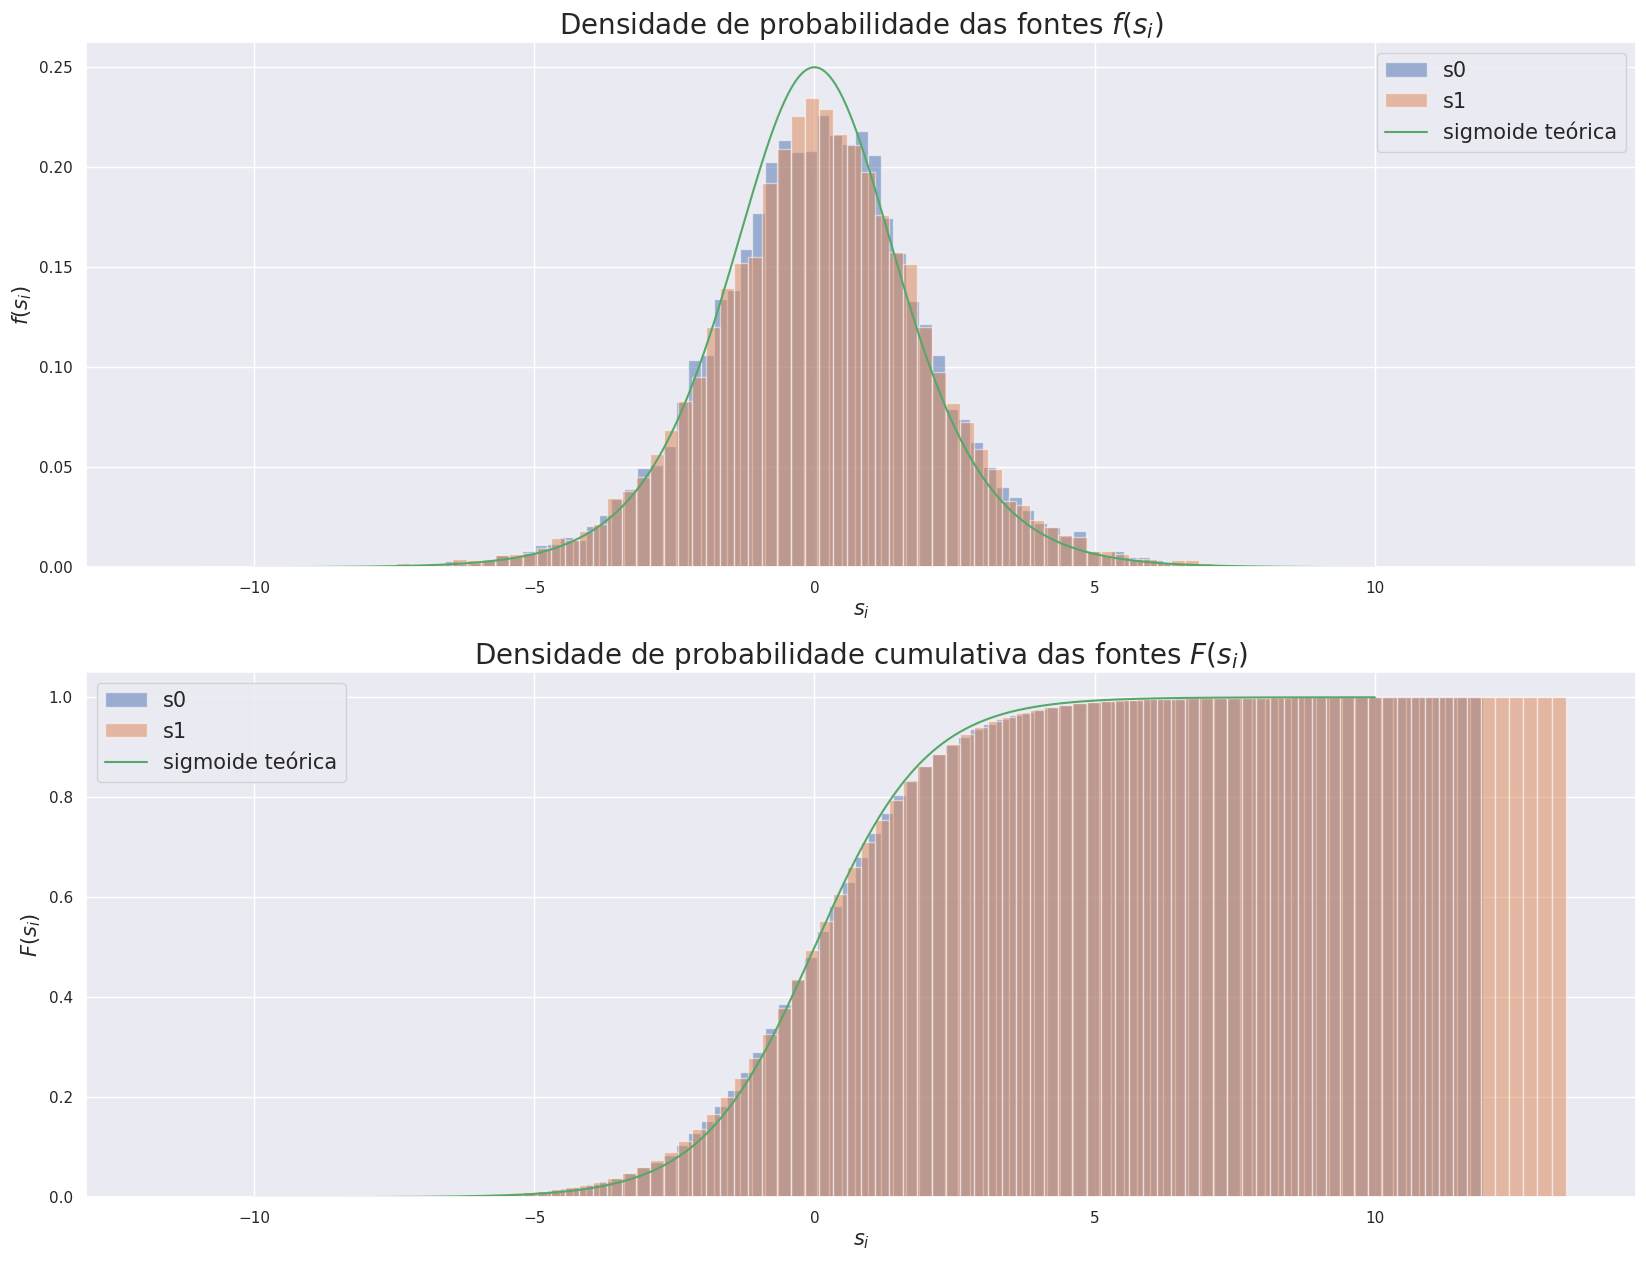

In [95]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)


for i in range(1, NSOURCES+1):
    ax1.hist(
        x=s[i-1,:],
        bins=100,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=s[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    
ax1.plot(
    np.linspace(-10,10,1000),
    [source_pdf(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)


ax2.plot(
    np.linspace(-10,10,1000),
    [source_cumulative(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)

ax1.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(s_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidade de probabilidade das fontes $f(s_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(s_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidade de probabilidade cumulativa das fontes $F(s_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

## 2.2. Mix sources and generate observations

In [96]:
# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])
print('MIXING MATRIX A:')
print(A)

MIXING MATRIX A:
[[ 1.   1. ]
 [-0.5  0.5]]


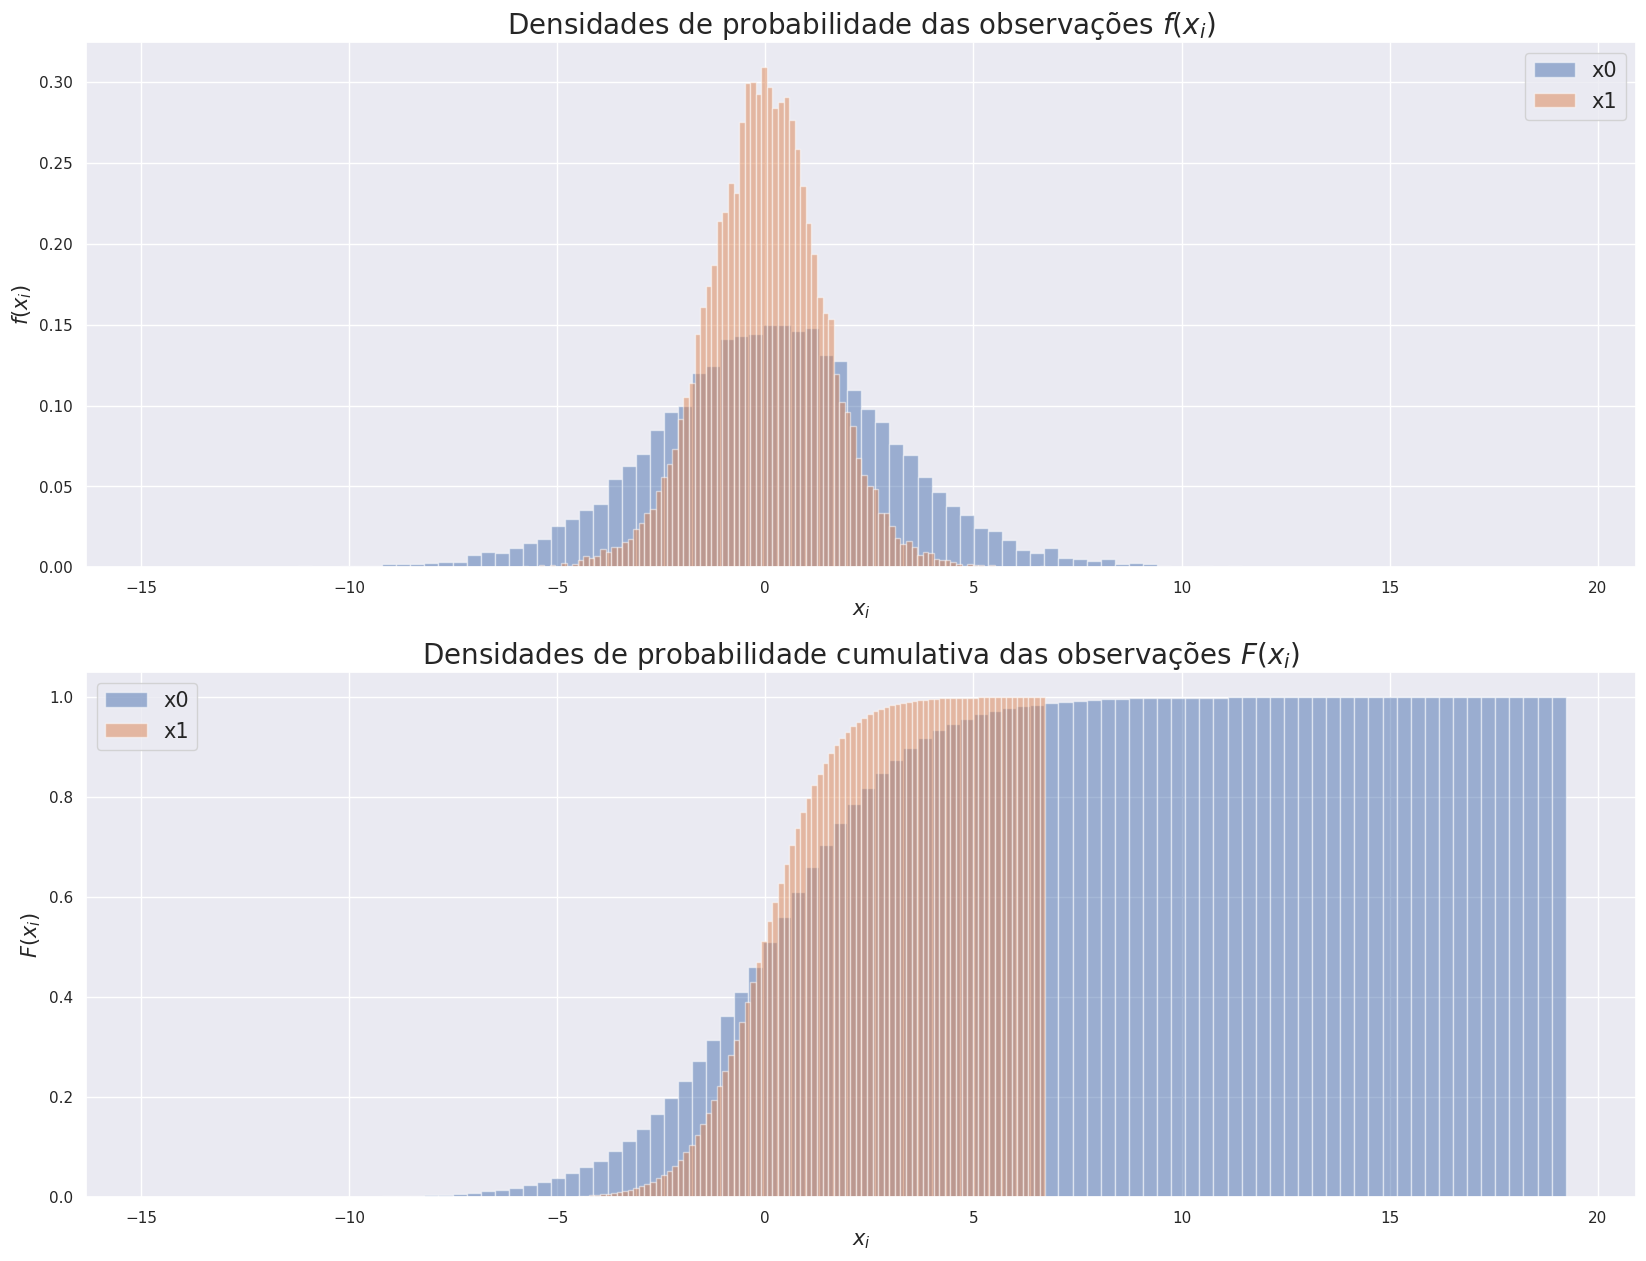

In [97]:
# Observed sources
x = A@s

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

for i in range(1, NSOURCES+1):
    ax1.hist(
        x=x[i-1,:],
        bins=100,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=x[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )

ax1.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(x_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidades de probabilidade das observações $f(x_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(x_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidades de probabilidade cumulativa das observações $F(x_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

In [98]:
if SAVE_SIGNALS:
    signal_save_dir = model_dir / 'signals'
    if not signal_save_dir.is_dir():
        signal_save_dir.mkdir()

    with (signal_save_dir / 'sources.pkl').open(mode='wb') as f:
        pickle.dump(s, f)

    with (signal_save_dir / 'mixtures.pkl').open(mode='wb') as f:
        pickle.dump(x, f)

## 2.3. Perform Analysis - LIKELIHOOD

### 2.3.1 Execute MCMC Sampling

In [99]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    return 1

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [100]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'likelihood'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 22.9 ms, sys: 40.7 ms, total: 63.6 ms
Wall time: 613 ms


### 2.3.2. Parse MCMC Results

In [101]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [102]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45254658 -0.9167764 ]
 [ 0.45459147  0.91221383]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [103]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.47309094525,
 -83724.49383450838,
 -83724.47356231448,
 -83724.5171294933,
 -83724.48083518964,
 -83724.49294898611,
 -83724.5266463708,
 -83724.5029706083,
 -83724.49241285544,
 -83724.48310084369,
 -83724.52062803158,
 -83724.52715191284,
 -83724.5406187758,
 -83724.49555465161,
 -83724.4891727077,
 -83724.50090889196,
 -83724.49640933186,
 -83724.50842165216,
 -83724.50757620552,
 -83724.46459461523,
 -83724.4888596844,
 -83724.48659308869,
 -83724.49622701957,
 -83724.49272578672,
 -83724.49360194187,
 -83724.4702482457,
 -83724.51283261436,
 -83724.47300453267,
 -83724.4994965744,
 -83724.47047235841]

In [104]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45254658, -0.9167764 ],
        [ 0.45459147,  0.91221383]]),
 array([[ 0.45446249,  0.91170711],
        [-0.45264055,  0.91634685]]),
 array([[-0.45309575,  0.91575595],
        [-0.45434403, -0.91277066]]),
 array([[-0.45376731,  0.91444911],
        [-0.45357011, -0.9136017 ]]),
 array([[-0.45249695, -0.91588982],
        [ 0.45480835, -0.91214669]]),
 array([[-0.45396171, -0.91273594],
        [-0.45297678,  0.91473293]]),
 array([[ 0.45304219,  0.91449332],
        [-0.45396665,  0.91304501]]),
 array([[-0.45324008, -0.91421242],
        [ 0.45387766, -0.91413474]]),
 array([[-0.45487804,  0.91146696],
        [-0.45207145, -0.91592469]]),
 array([[ 0.45185283, -0.91776451],
        [ 0.4553749 ,  0.91006635]]),
 array([[ 0.45126535, -0.91930211],
        [ 0.45592404,  0.90837363]]),
 array([[-0.45220217, -0.91709123],
        [ 0.45505499, -0.91103093]]),
 array([[-0.45214195,  0.91698111],
        [ 0.45512261,  0.91037411]]),
 array([[-0.45246692,  0.91709097],
  

### 2.3.3. Plot sampled coefficients stochastic process - Markov Chain evolution

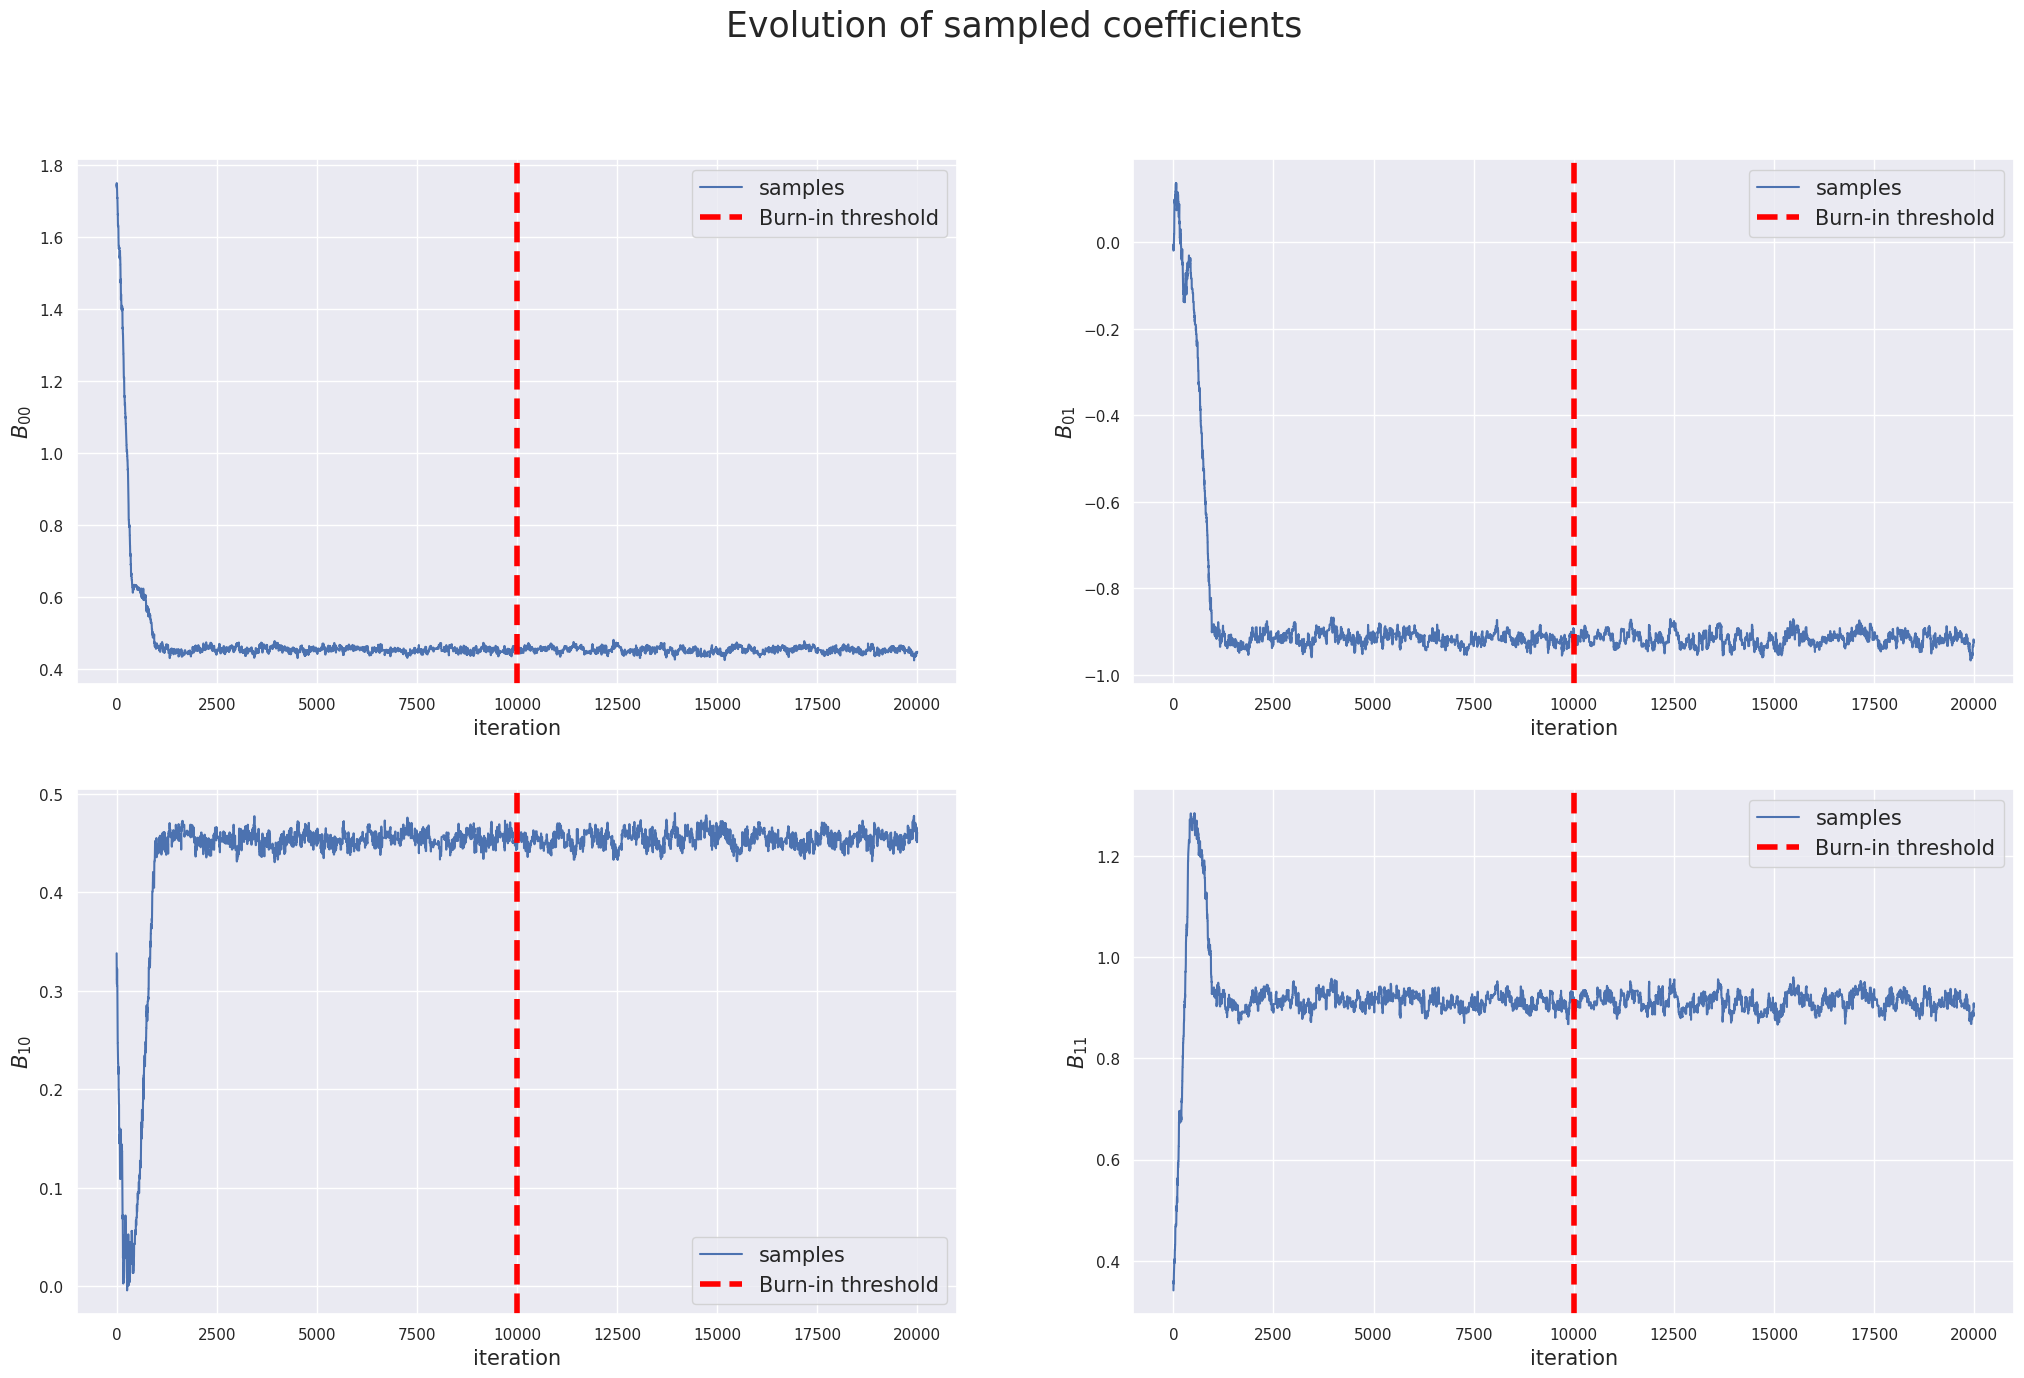

In [105]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.3.4. Plot sampled coefficients distributions - Markov Chain evolution

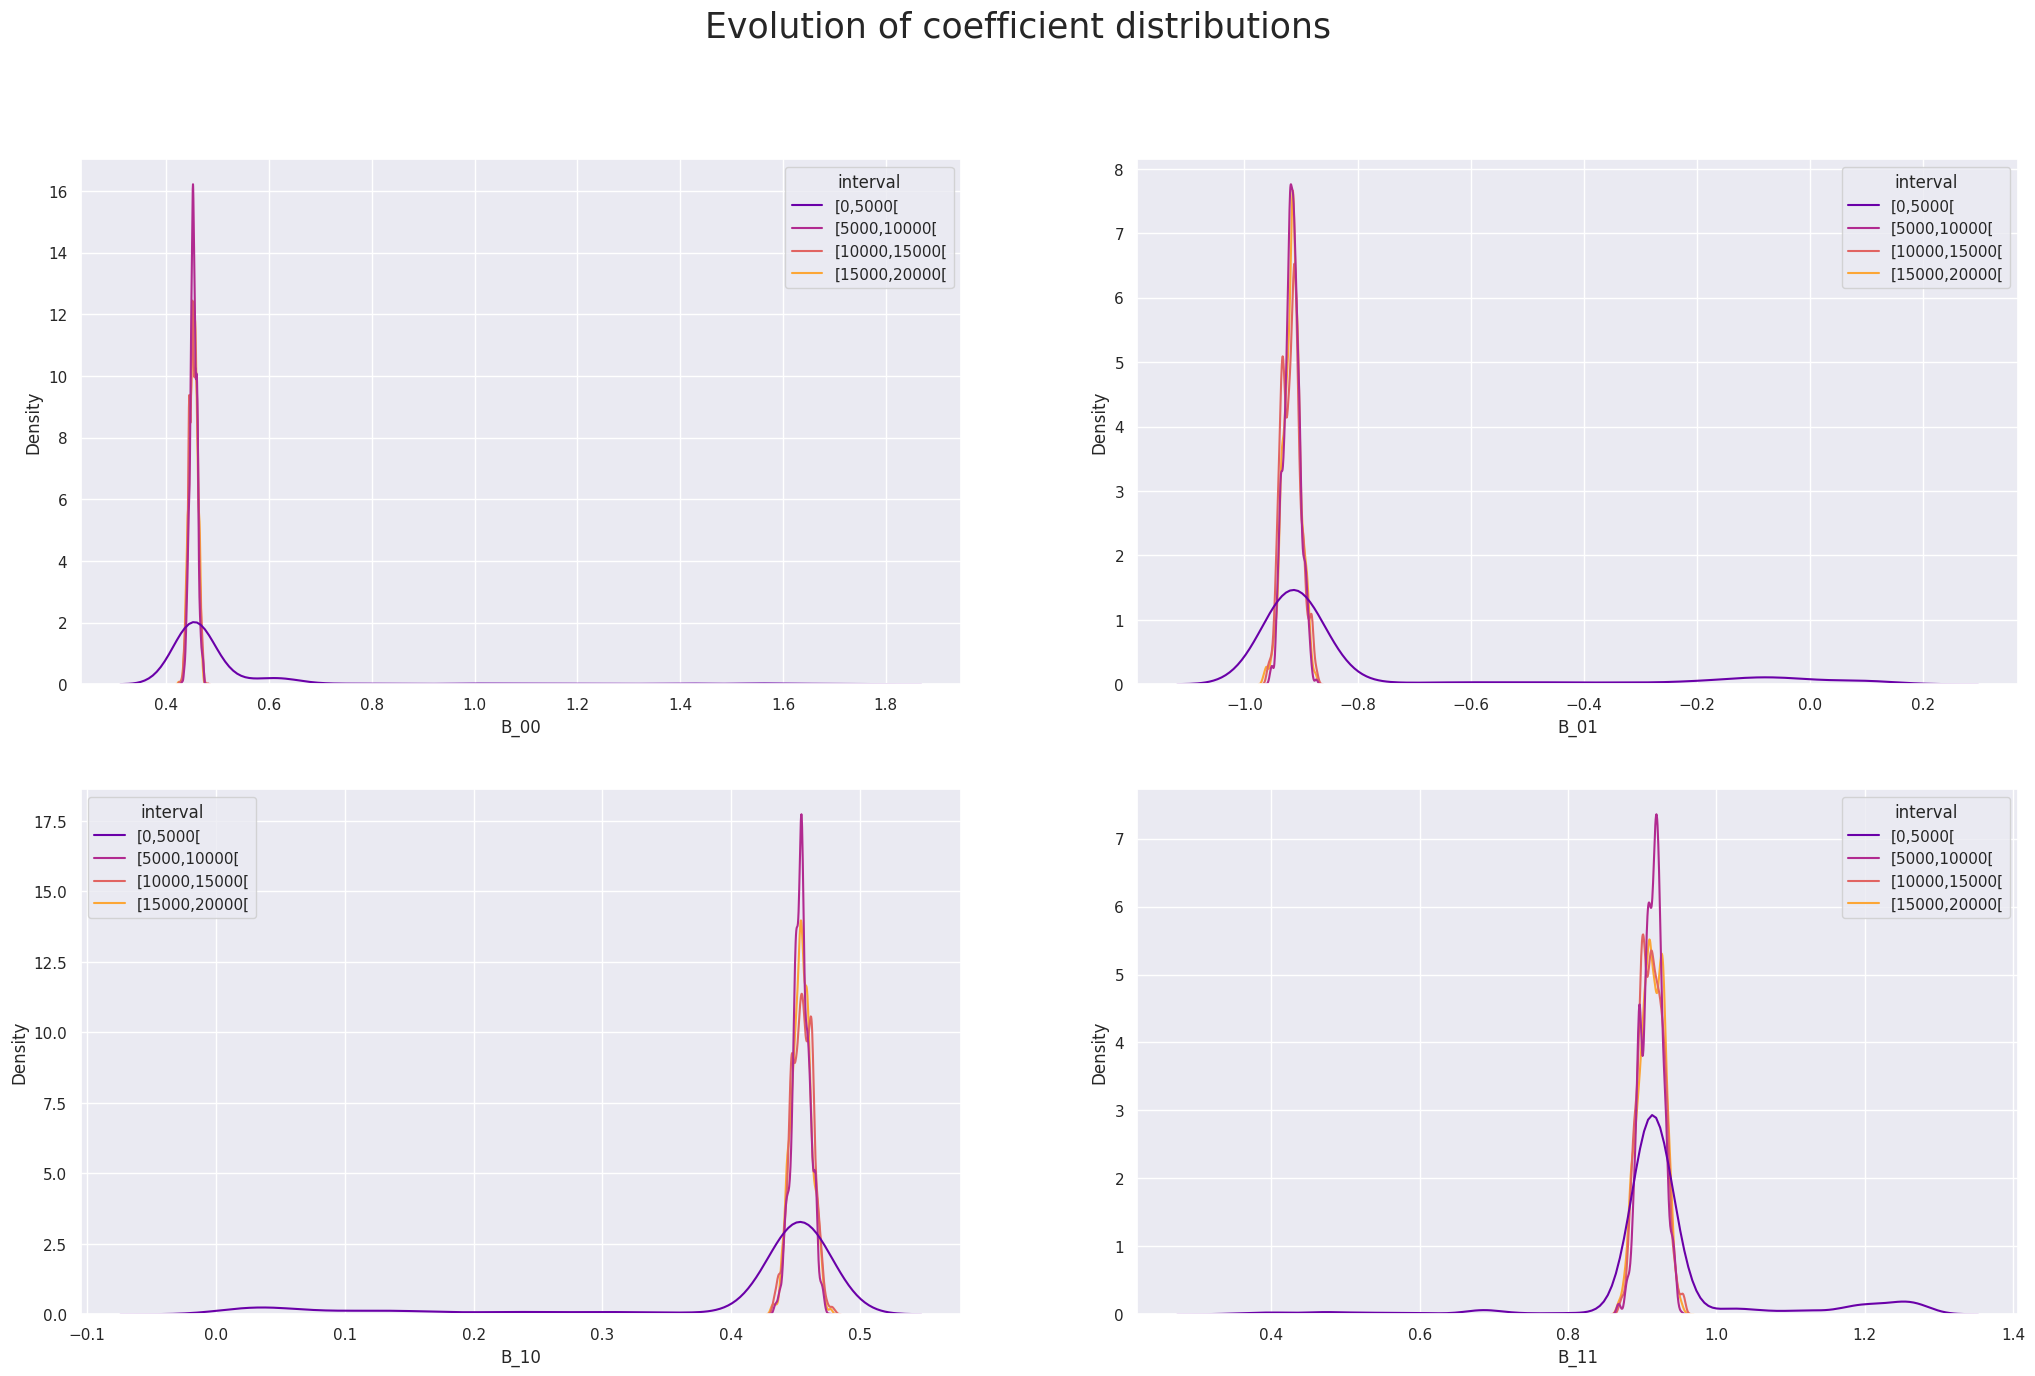

In [106]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.3.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

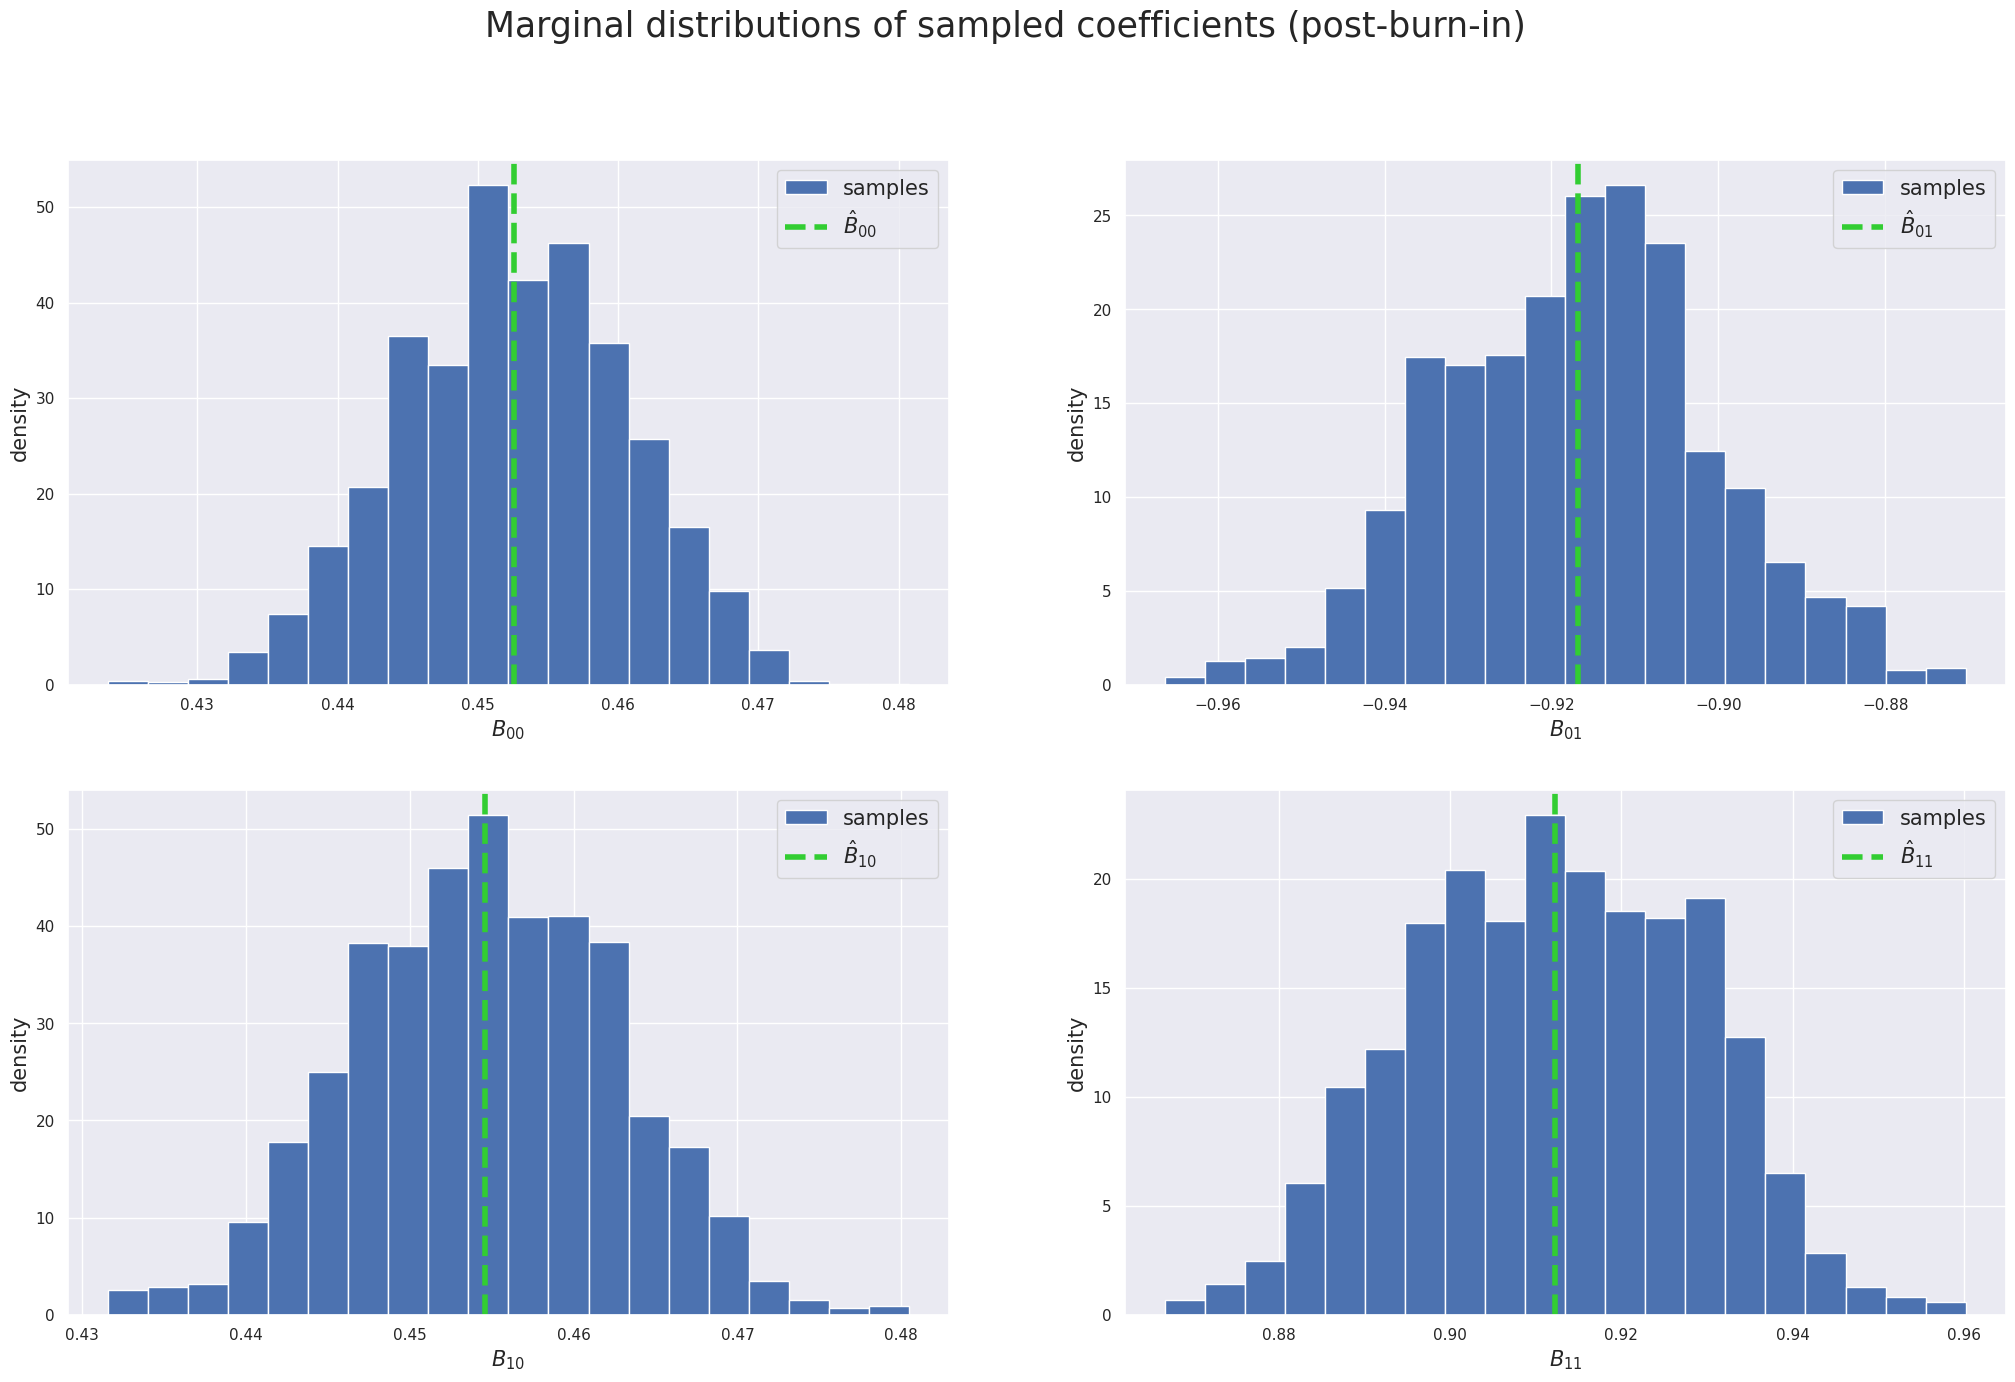

In [107]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.3.6. Plot evolution of log-posterior

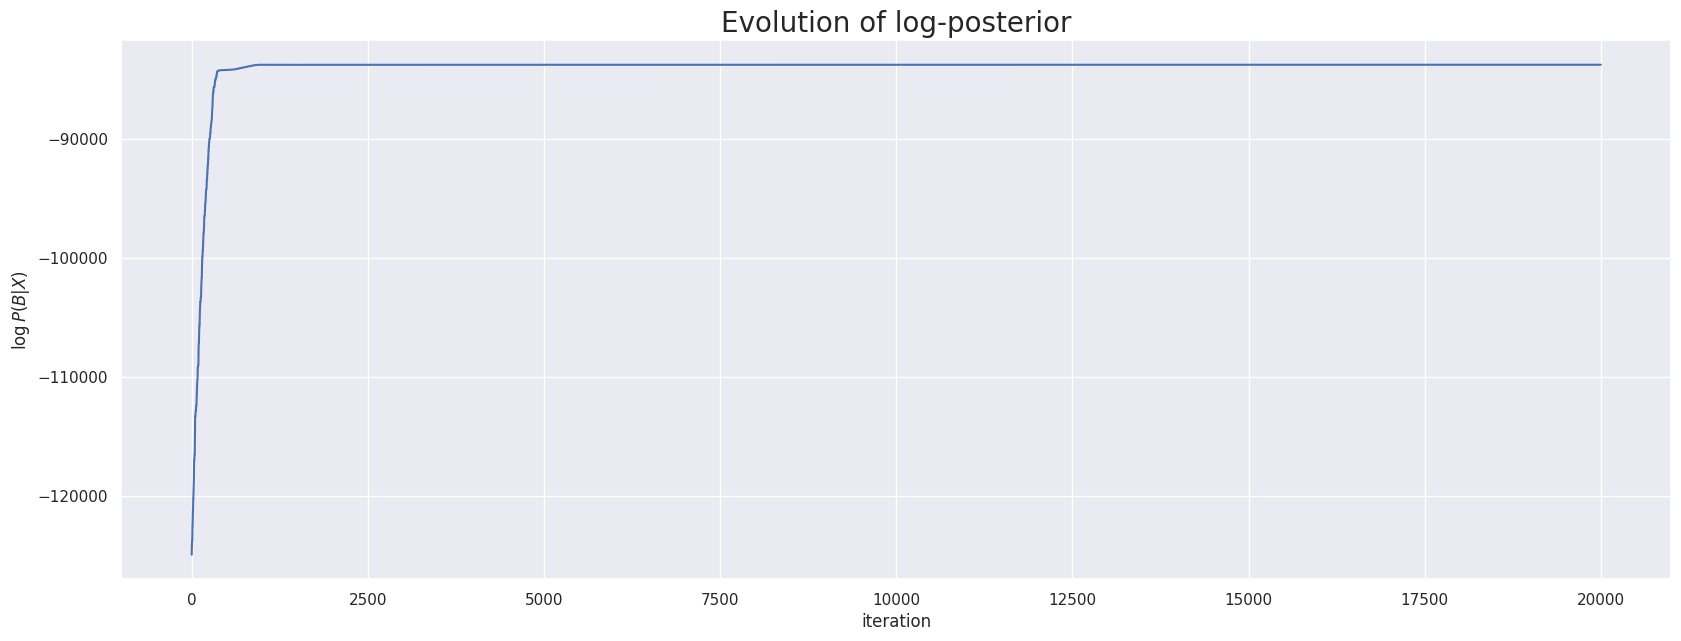

In [108]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 2.3.7. Plot source separation results

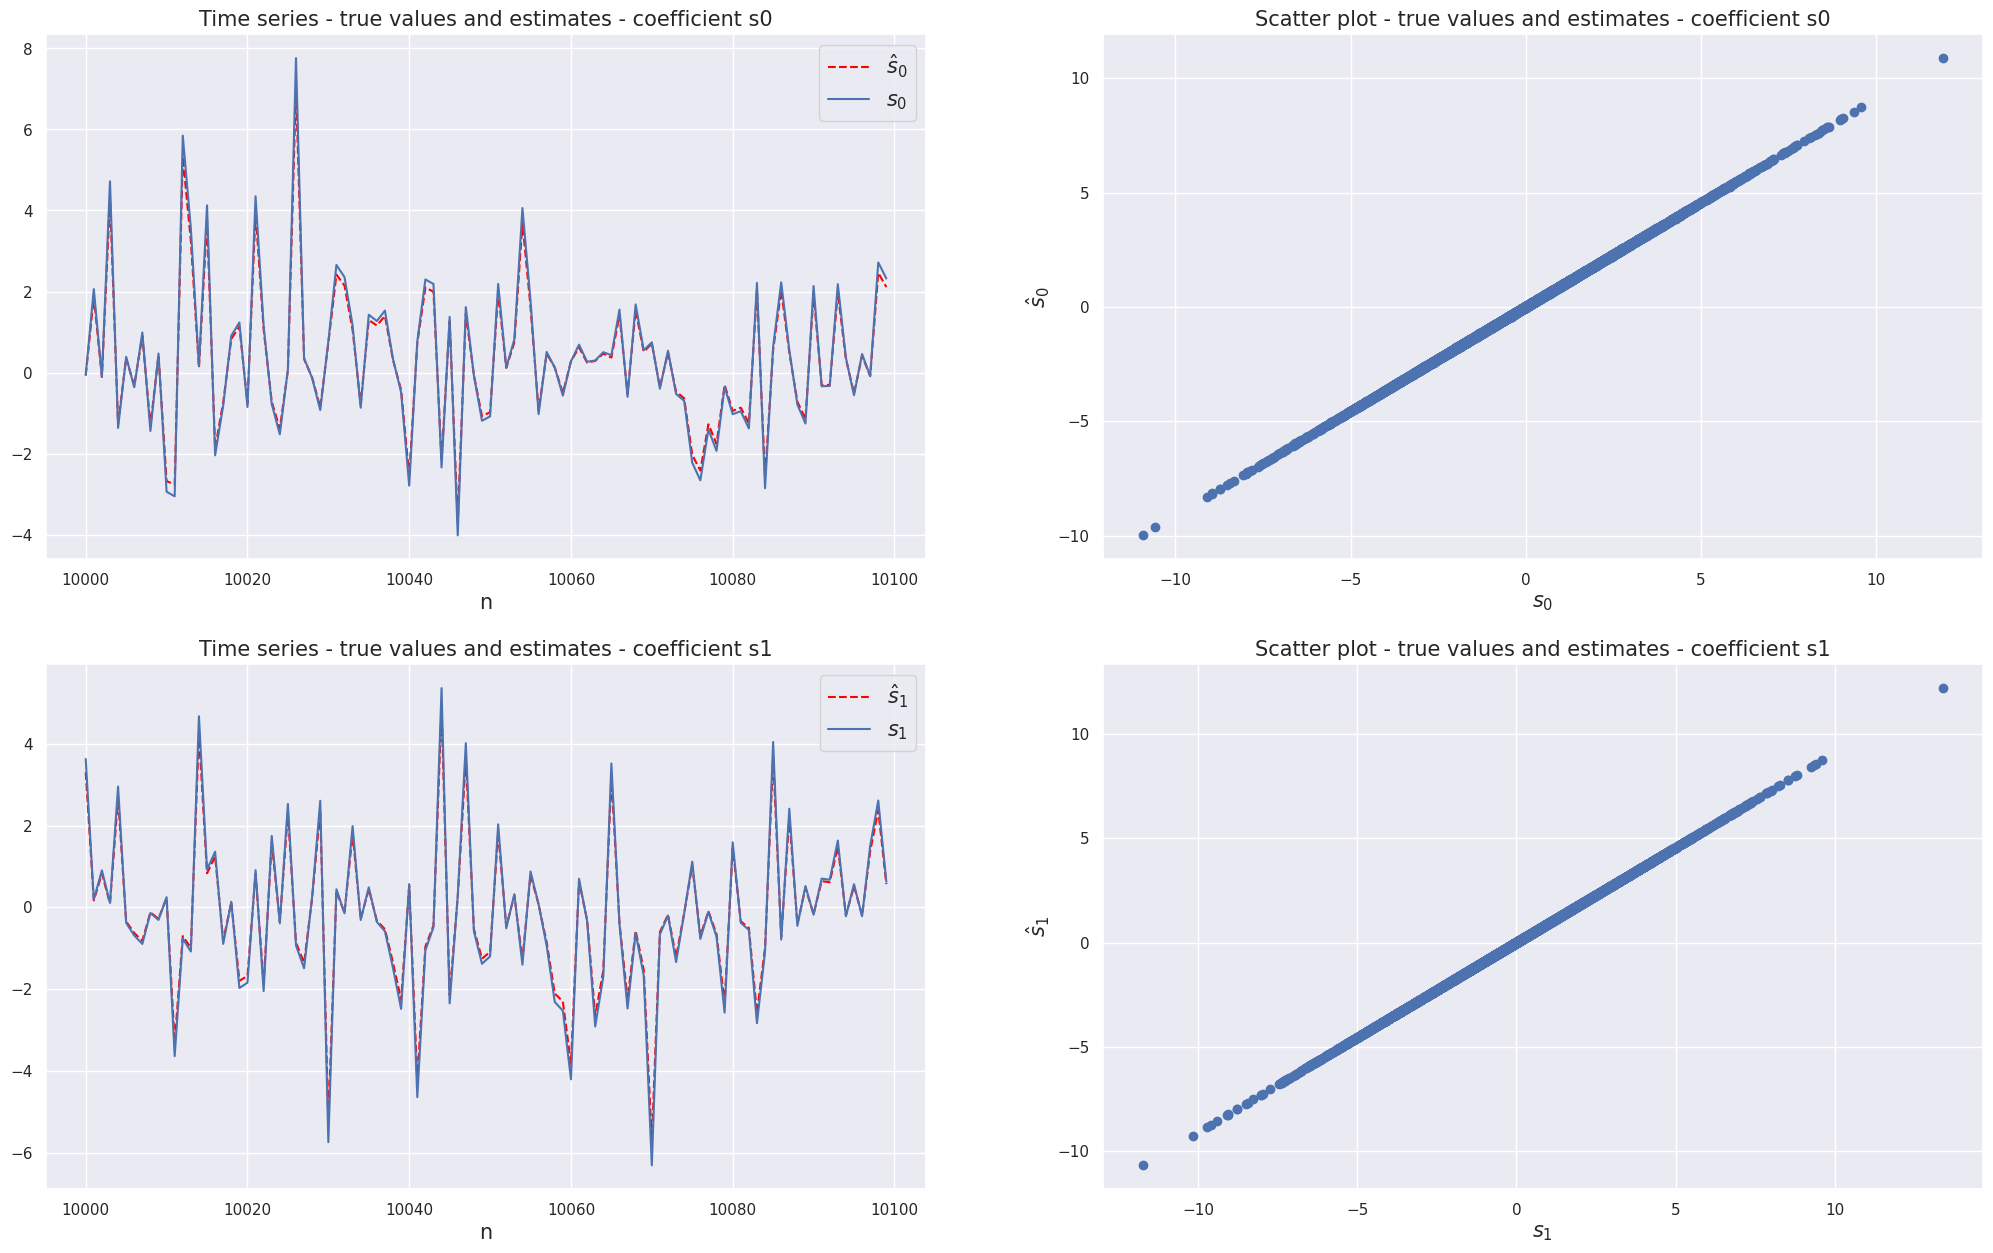

In [109]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [110]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified_model']['likelihood'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008887084177311825


## 2.4. Perform Analysis - DETERMINANT PRIOR
#### Prior:
$p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} (det(\boldsymbol{B}) - 1)^2 \right]$

### 2.4.1 Execute MCMC Sampling

In [111]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(B):
    sig=0.1
    desired_det=1
    return (1/np.sqrt(2*np.pi*np.square(sig)))*np.exp(-np.square(np.linalg.det(B)-desired_det)/(2*np.square(sig)))

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [112]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'determinant_prior'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 59.8 ms, sys: 86.1 ms, total: 146 ms
Wall time: 254 ms


### 2.4.2. Parse MCMC Results

In [113]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [114]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45212338 -0.91850741]
 [ 0.45543706  0.91031807]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [115]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.51526568584,
 -83724.52735361346,
 -83724.51193879756,
 -83724.49355862965,
 -83724.51313093999,
 -83724.5030019633,
 -83724.4834209965,
 -83724.4759776923,
 -83724.49709917007,
 -83724.48512781507,
 -83724.49459418523,
 -83724.51527616222,
 -83724.48938862114,
 -83724.48332132805,
 -83724.48368205412,
 -83724.4673195939,
 -83724.48844168875,
 -83724.47575044444,
 -83724.50838335854,
 -83724.52048779959,
 -83724.52554537512,
 -83724.51441812892,
 -83724.4907183338,
 -83724.49524884674,
 -83724.4690512942,
 -83724.4947220375,
 -83724.49181050074,
 -83724.50921095397,
 -83724.47777849137,
 -83724.49580358909]

In [116]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45212338, -0.91850741],
        [ 0.45543706,  0.91031807]]),
 array([[ 0.45276916,  0.91429334],
        [-0.45433239,  0.91264819]]),
 array([[-0.45432665,  0.91314036],
        [-0.45269725, -0.91518129]]),
 array([[-0.45459201,  0.91260201],
        [-0.45266582, -0.91524748]]),
 array([[-0.45394623, -0.91334678],
        [ 0.45335754, -0.91489962]]),
 array([[-0.45309356, -0.9150313 ],
        [-0.45411812,  0.91306767]]),
 array([[ 0.45329474,  0.91391983],
        [-0.45383075,  0.91404334]]),
 array([[-0.45417037, -0.91343647],
        [ 0.45330497, -0.91538754]]),
 array([[-0.45452354,  0.9130346 ],
        [-0.45280786, -0.91596294]]),
 array([[ 0.45224516, -0.91703055],
        [ 0.45502758,  0.91137764]]),
 array([[ 0.45289953, -0.91534268],
        [ 0.4542068 ,  0.91129824]]),
 array([[-0.45291687, -0.91486491],
        [ 0.45414444, -0.91324175]]),
 array([[-0.45309892,  0.91541933],
        [ 0.45396738,  0.91228535]]),
 array([[-0.45365978,  0.91431069],
  

### 2.4.3. Plot sampled coefficients stochastic process - Markov Chain evolution

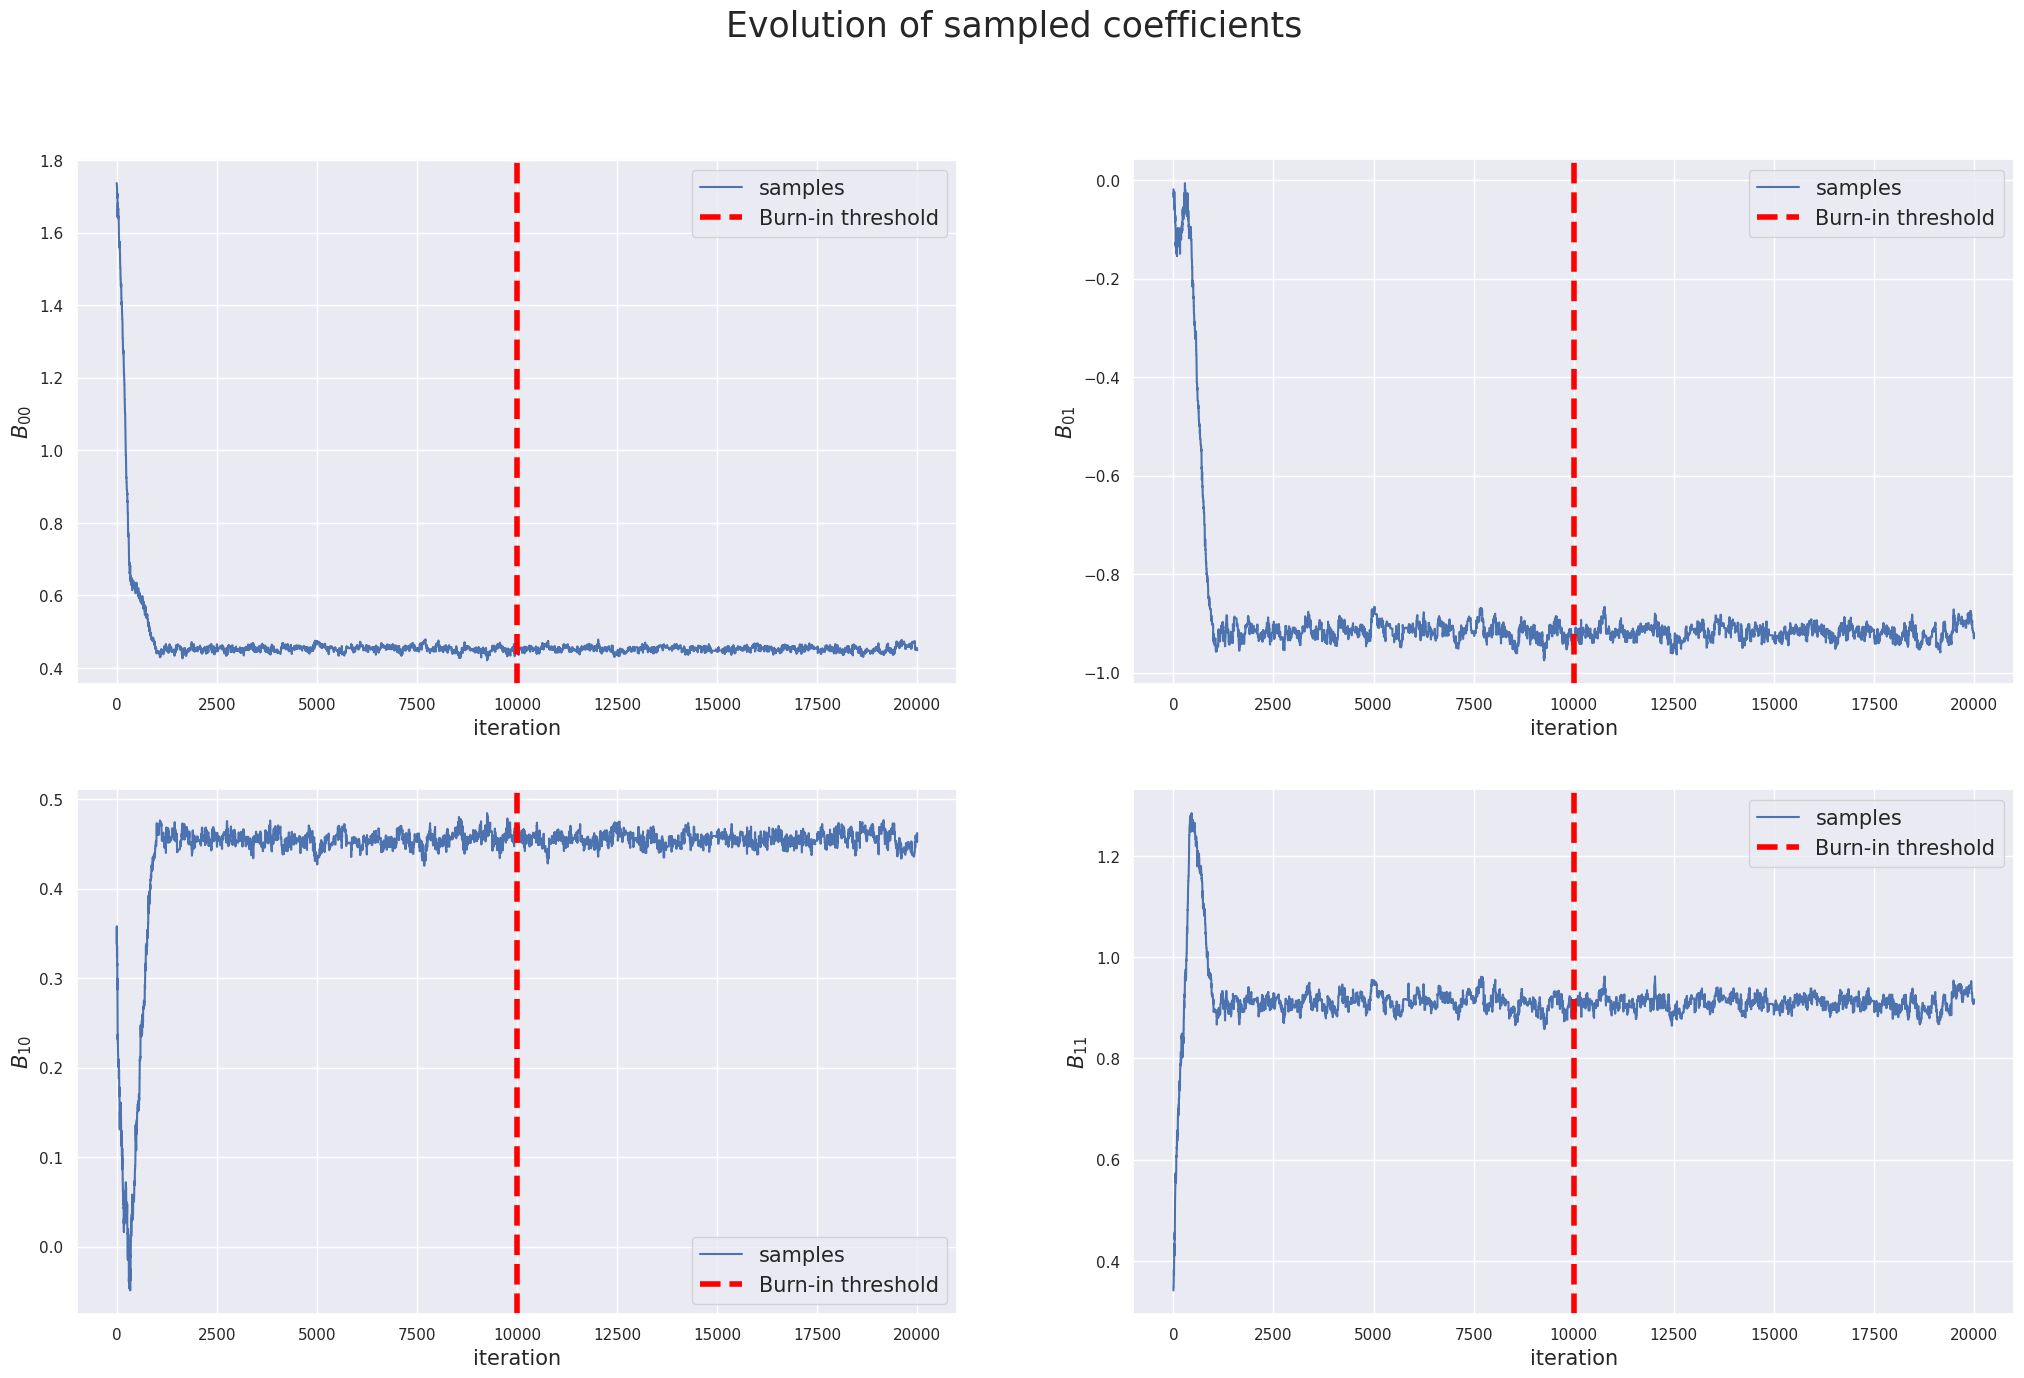

In [117]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.4.4. Plot sampled coefficients distributions - Markov Chain evolution

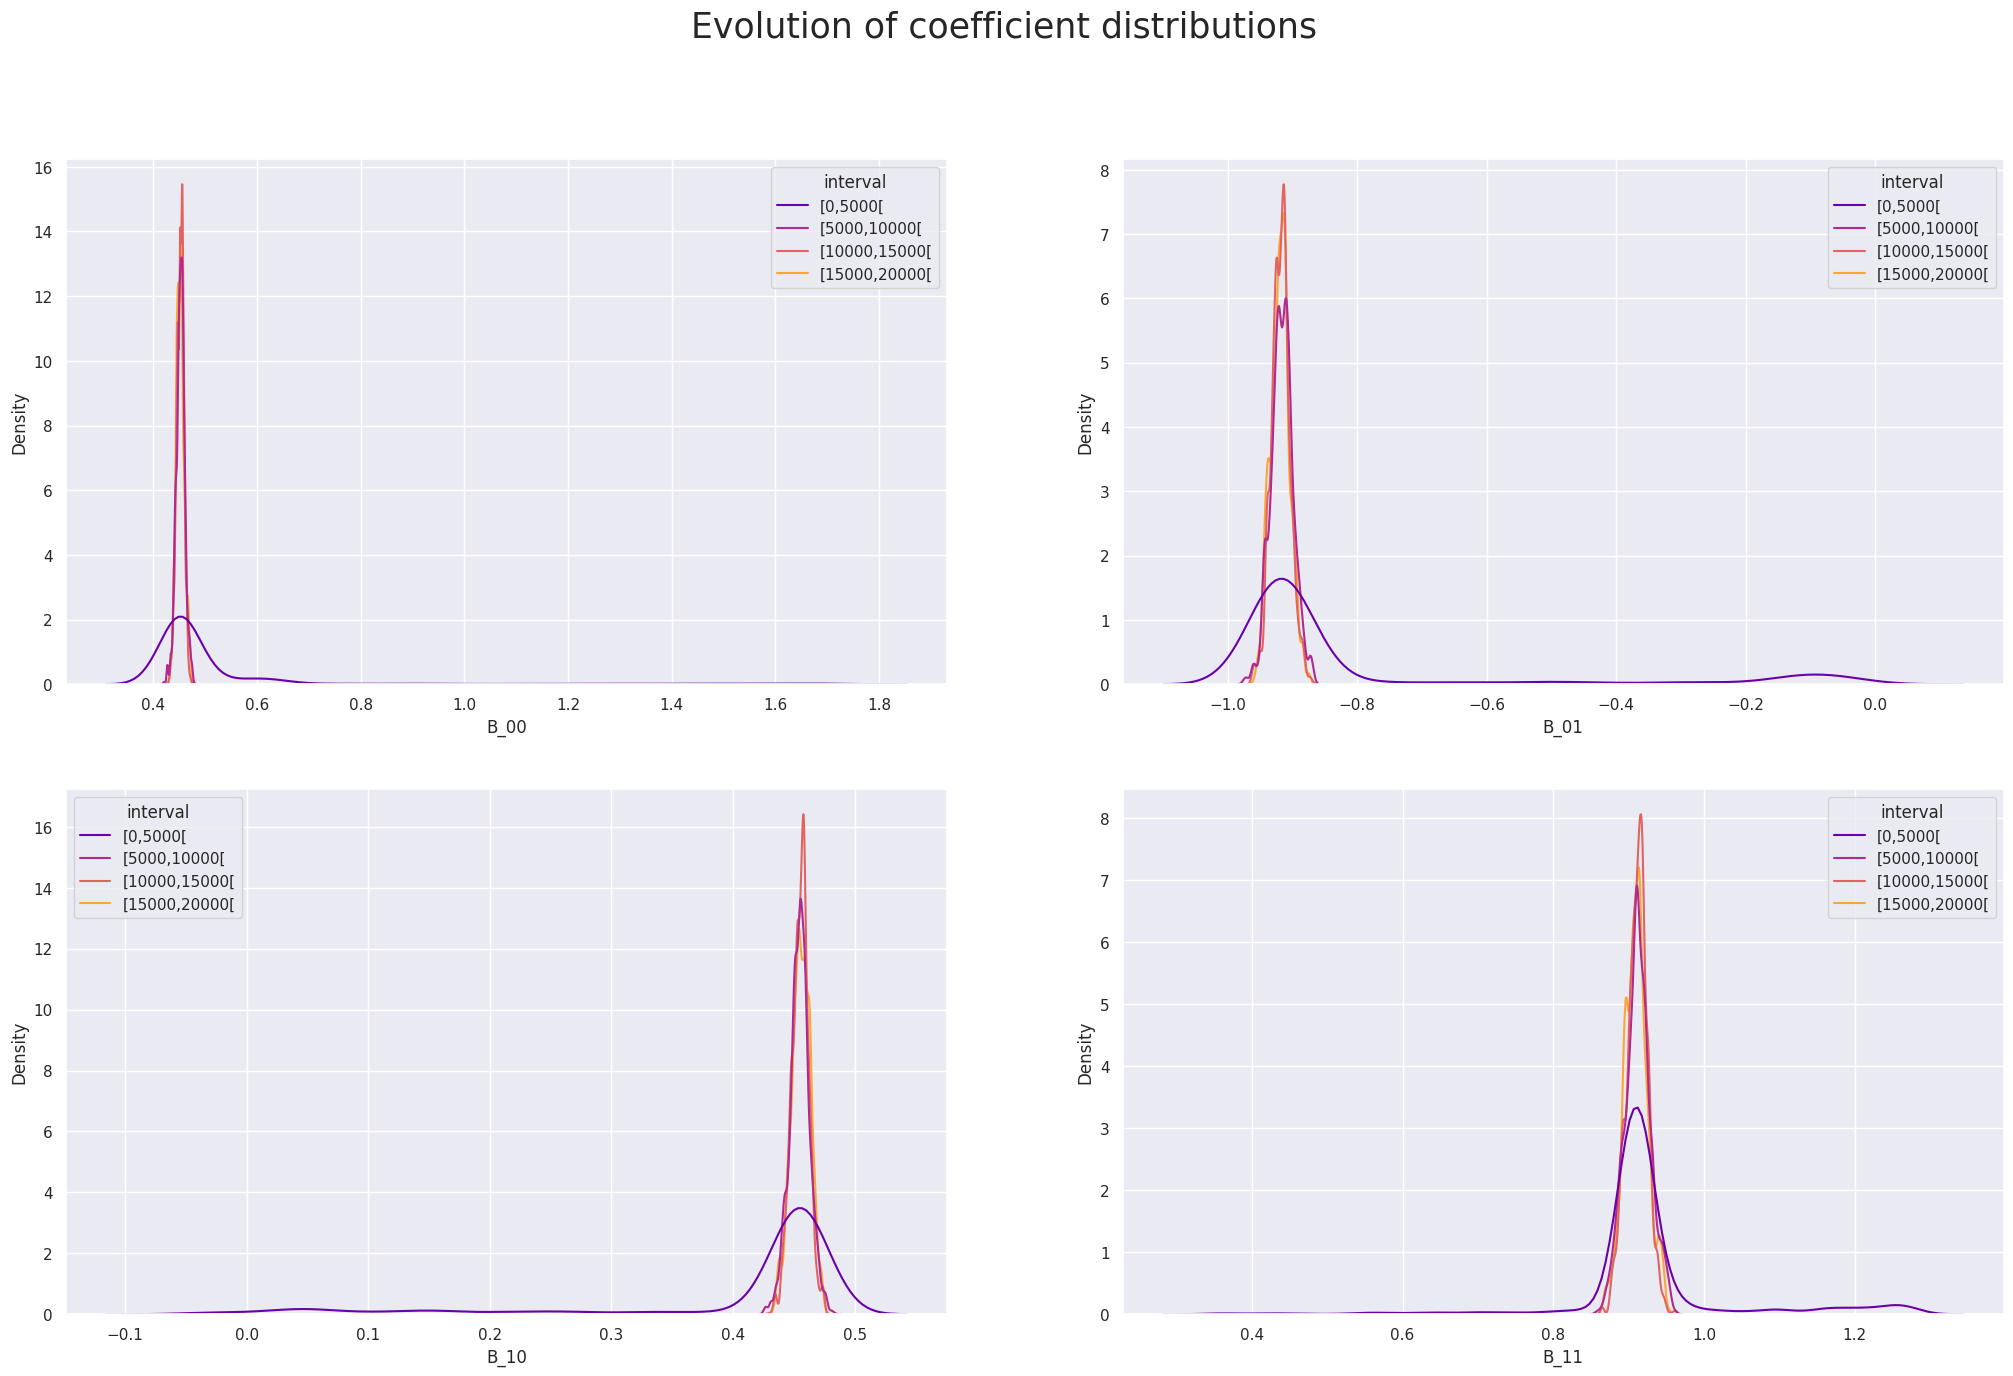

In [118]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.4.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

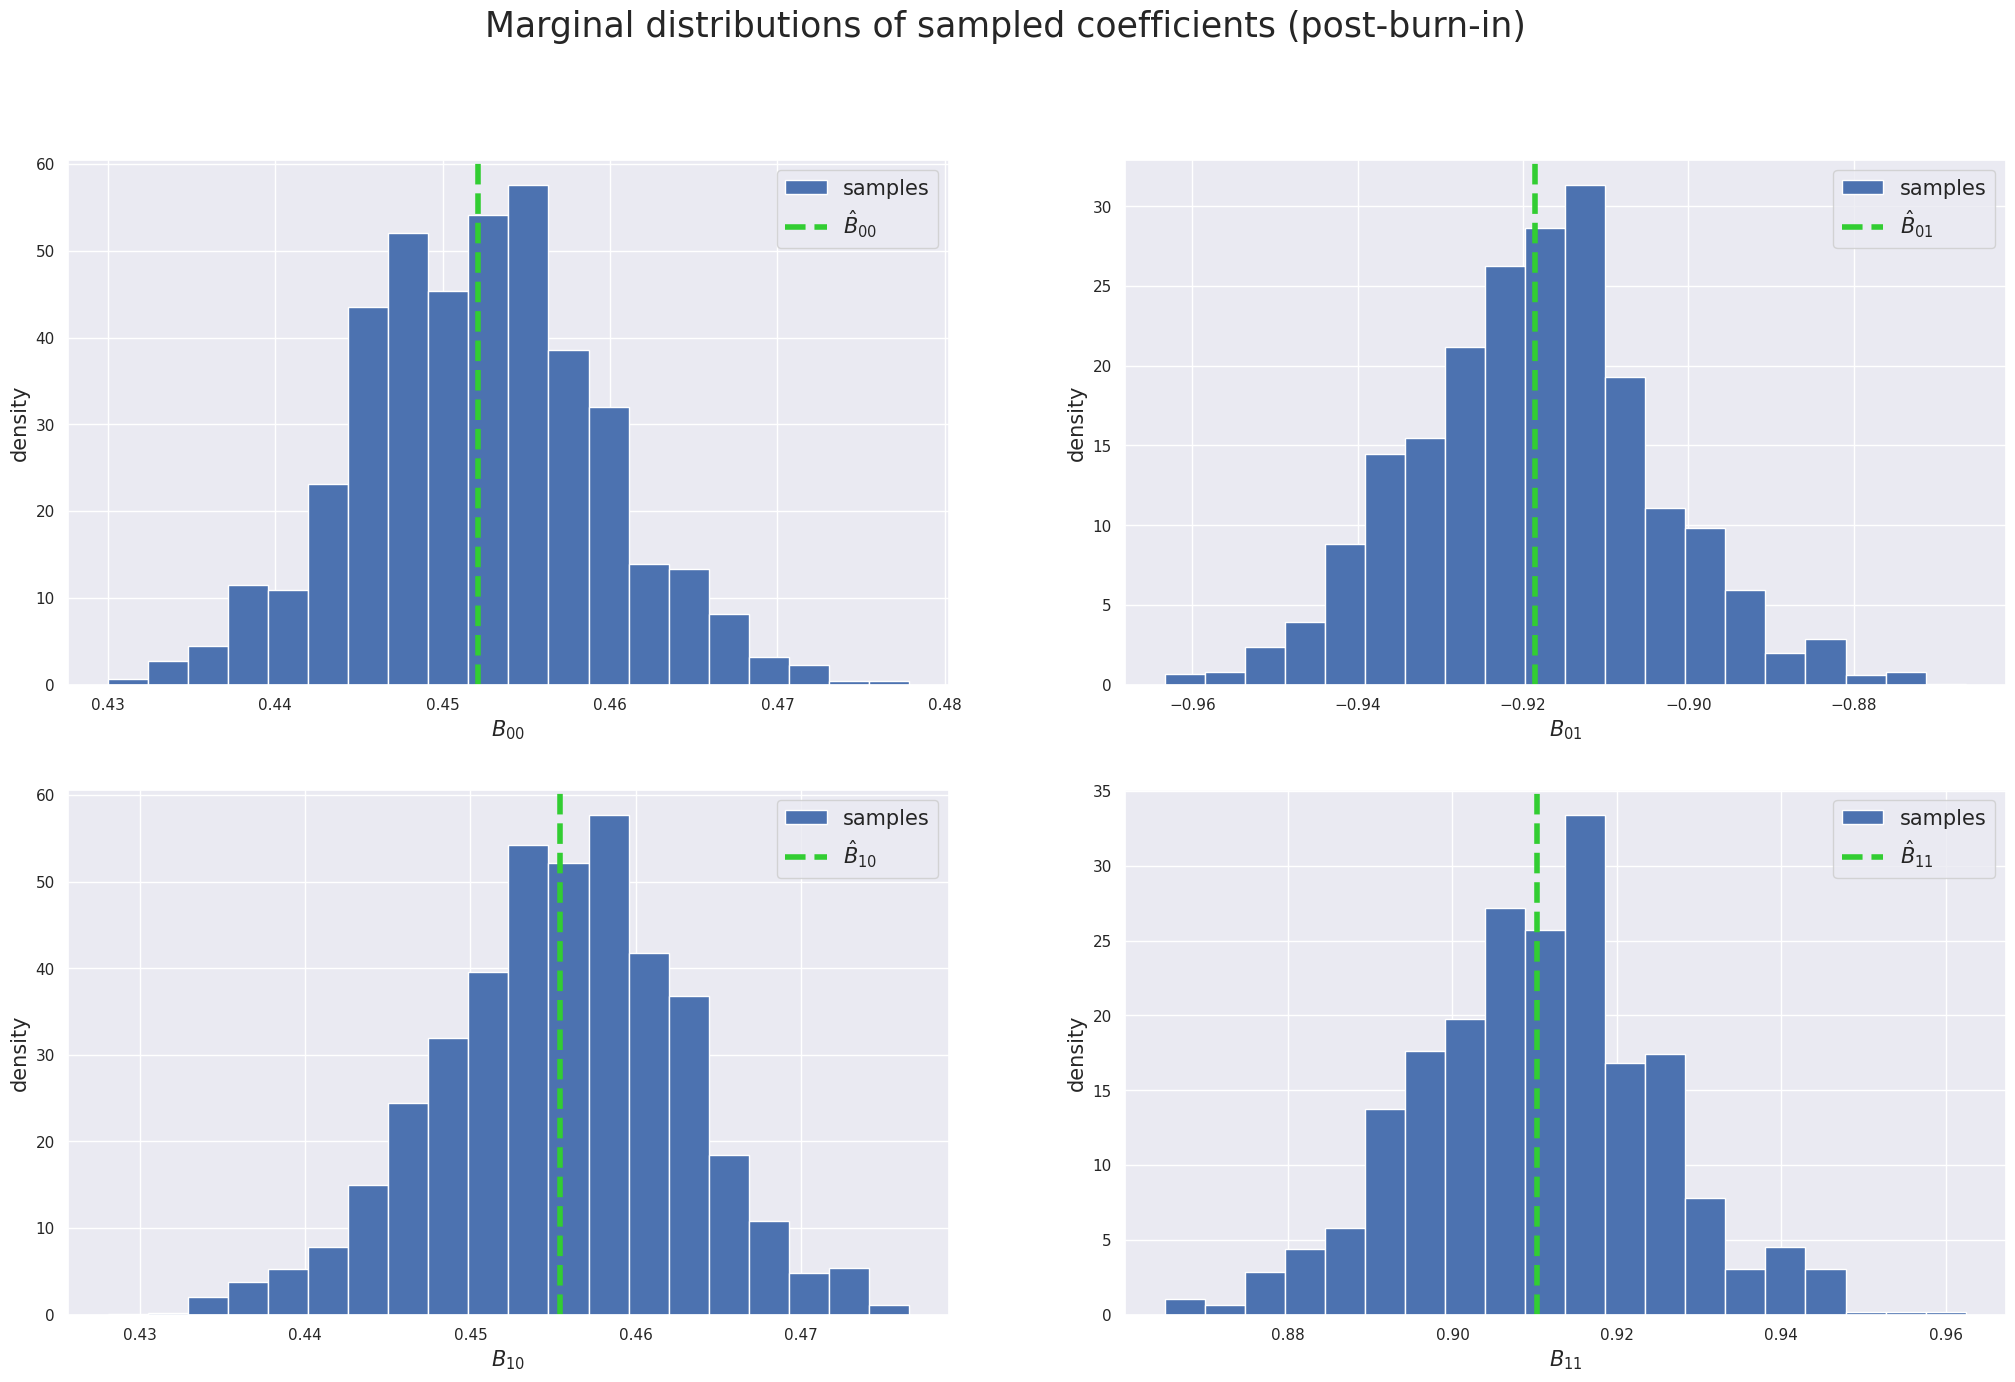

In [119]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.4.6. Plot evolution of log-posterior

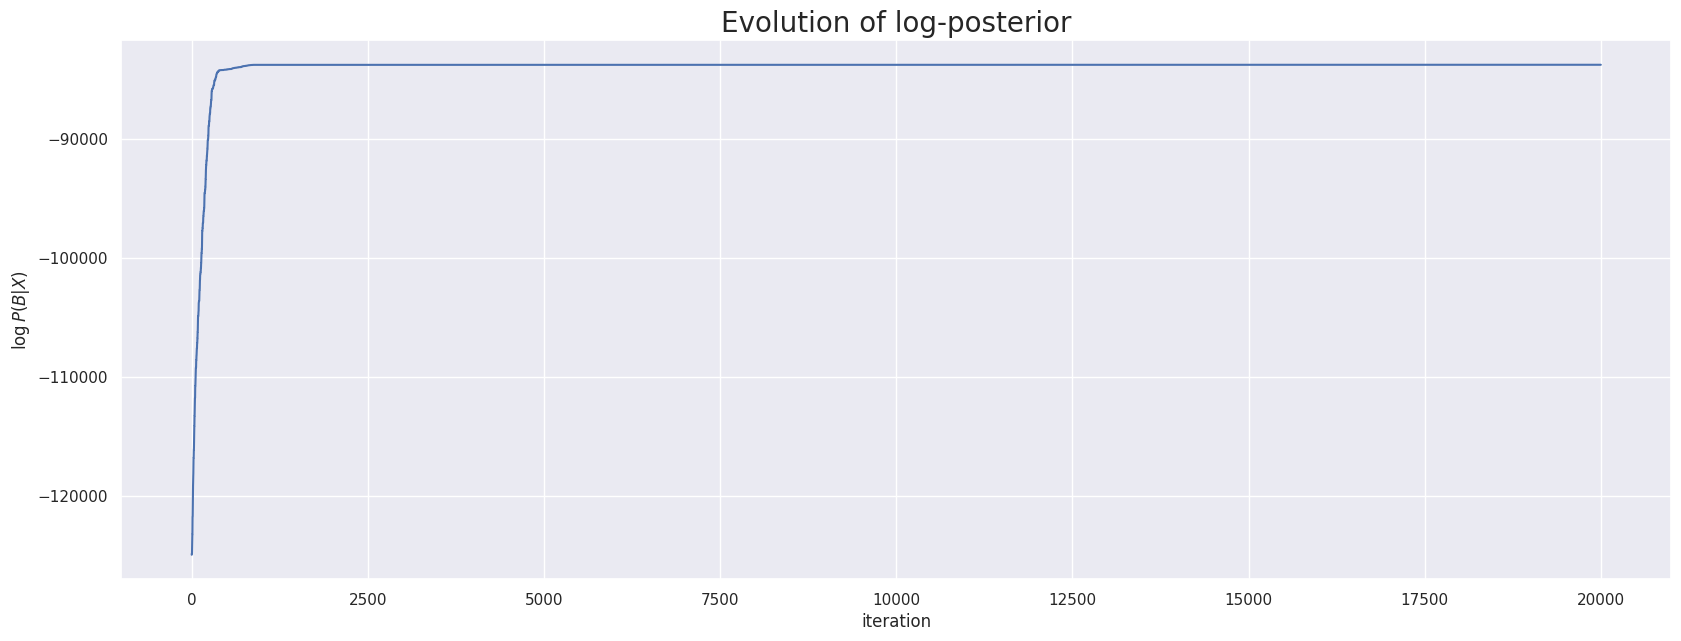

In [120]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 2.4.7. Plot source separation results

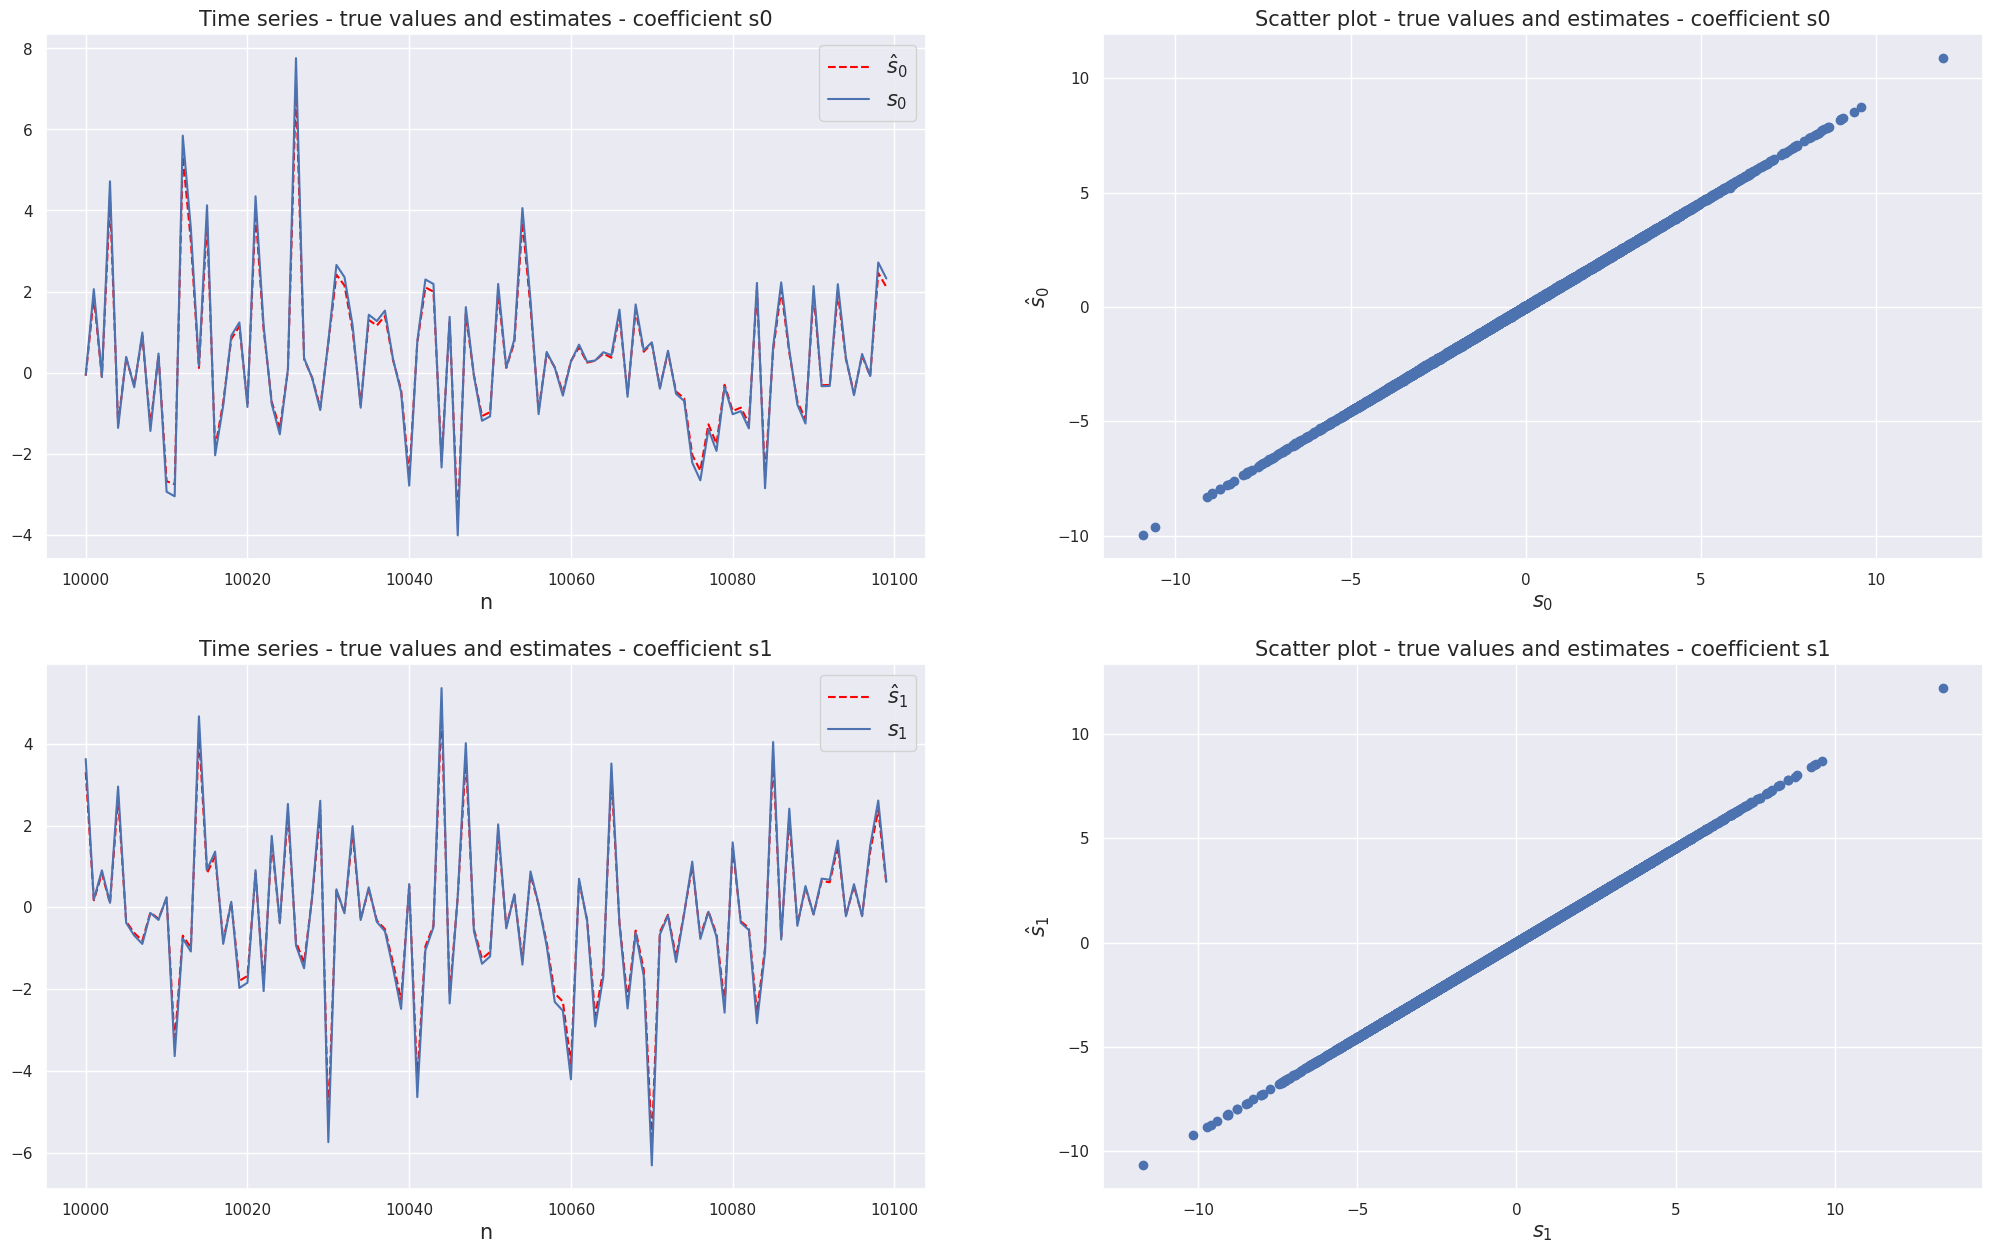

In [121]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [122]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified_model']['determinant_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.00088742115196529


## 2.5. Perform Analysis - near-identity transformation
#### Prior:
#### $p(\boldsymbol{B}) \varpropto \exp \left[ -\frac{1}{2 \sigma^{2}} ||\boldsymbol{B} - \boldsymbol{I}||^2 \right]$

### 2.5.1 Execute MCMC Sampling

In [123]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def prior_pdf(X):
    sig=0.1
    return np.exp(
        (-1/2/np.square(sig))*np.linalg.norm(X-np.eye(X.shape[0]))
    )

def log_posteriori_fn(
    x,
    source_pdf_fn,
    prior_pdf_fn,
    B
):
    NOBS=x.shape[-1]
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    posteriori += np.log(prior_pdf(B))

    return posteriori

def proposal_fn(
    exploration_var,
    B
):
    # Calculate shift in parameter
    shift = np.random.normal(
        loc=0,
        scale=np.sqrt(exploration_var),
        size=B.shape
    )

    # Sum shift to obtain new parameter value
    new_B = np.add(
        B, shift
    )

    return new_B

In [124]:
%%time

# Create folder for combination of model specification + prior
combination_dir = model_dir / 'identity_transform'
if CREATE_FOLDER_STRUCTURE:
    if not combination_dir.is_dir():
        combination_dir.mkdir()

if EXECUTE_SAMPLING:
    # Fixate arguments in log posteriori fn
    wrapper_posteriori_fn = functools.partial(
        log_posteriori_fn,
        x,
        source_pdf,
        prior_pdf
    )
    
    # Fixate arguments in proposal_fn
    wrapper_proposal_fn = functools.partial(
        proposal_fn,
        EXPLORATION_VAR
    )
    
    # Initialize MH estimator
    estimator = MMSEMetropolisHastingsEstimator(
        n_samples=N_SAMPLES,
        log_posterior_fn=wrapper_posteriori_fn,
        Q=wrapper_proposal_fn,
        burn_in=BURN_IN
    )
    
    # Execute MCMC estimation
    estimator.fit(
        s,
        x,
        initial_condition=initial_B,
        n_jobs=N_WORKERS
    )

    # Save artifact
    with (combination_dir / 'MH_Estimator.pkl').open('wb') as f:
        pickle.dump(estimator, f)
else:
    # Read artifact
    with (combination_dir / 'MH_Estimator.pkl').open('rb') as f:
        estimator=pickle.load(f)
    

CPU times: user 79.6 ms, sys: 81.7 ms, total: 161 ms
Wall time: 592 ms


### 2.5.2. Parse MCMC Results

In [125]:
# Get results for analyzed model (best model by default)
# analyzed_model_idx = estimator.B_est_idx
analyzed_model_idx = 0
B_est = estimator.mcmc_results[analyzed_model_idx]['B_est']
s_est = B_est@x
samples = estimator.mcmc_results[analyzed_model_idx]['samples']
valid_samples = estimator.mcmc_results[analyzed_model_idx]['valid_samples']
logs = estimator.mcmc_results[analyzed_model_idx]['logs']

In [126]:
print('-'*100)
print('Estimated B:\n{}'.format(B_est))
print('True B:\n{}'.format(np.linalg.inv(A)))
print('-'*100)

----------------------------------------------------------------------------------------------------
Estimated B:
[[ 0.45208099 -0.9169157 ]
 [ 0.45486892  0.91034756]]
True B:
[[ 0.5 -1. ]
 [ 0.5  1. ]]
----------------------------------------------------------------------------------------------------


In [127]:
# Posteriors
[r['max_posterior'] for r in estimator.mcmc_results]

[-83724.51258316879,
 -83724.46768447662,
 -83724.50134385555,
 -83724.55710950652,
 -83724.4963298515,
 -83724.47057095333,
 -83724.48546185096,
 -83724.50979129308,
 -83724.51833034439,
 -83724.47197490079,
 -83724.5095143327,
 -83724.4770484742,
 -83724.50498011183,
 -83724.49874900182,
 -83724.51726255147,
 -83724.48185750854,
 -83724.50558677419,
 -83724.49930510536,
 -83724.52825512033,
 -83724.50259510633,
 -83724.52554537512,
 -83724.46991883867,
 -83724.47533384728,
 -83724.53537328474,
 -83724.51089899358,
 -83724.47194911318,
 -83724.49181050074,
 -83724.50025797174,
 -83724.51896448735,
 -83724.51597292005]

In [128]:
[r['B_est'] for r in estimator.mcmc_results]

[array([[ 0.45208099, -0.9169157 ],
        [ 0.45486892,  0.91034756]]),
 array([[ 0.45289387, -0.91542144],
        [ 0.45441262,  0.91234286]]),
 array([[-0.45349743,  0.91464595],
        [-0.45357053, -0.9133748 ]]),
 array([[-0.45284098,  0.9163315 ],
        [-0.45428754, -0.9117788 ]]),
 array([[-0.45307472, -0.91419235],
        [ 0.45384976, -0.91352122]]),
 array([[-0.45437665, -0.91228284],
        [-0.45276503,  0.91615079]]),
 array([[ 0.45278058,  0.91526068],
        [-0.45440442,  0.91302663]]),
 array([[-0.45441488, -0.91222069],
        [ 0.45301276, -0.91517073]]),
 array([[-0.4526366 ,  0.91611587],
        [-0.45450068, -0.91120627]]),
 array([[-0.45350574,  0.91546656],
        [ 0.45373466,  0.91362192]]),
 array([[ 0.45285846, -0.91571552],
        [ 0.45421305,  0.91192586]]),
 array([[-0.45546301, -0.90971528],
        [ 0.45207168, -0.91876898]]),
 array([[-0.45267975,  0.91621204],
        [ 0.45457278,  0.91149965]]),
 array([[-0.45365041,  0.91421001],
  

### 2.5.3. Plot sampled coefficients stochastic process - Markov Chain evolution

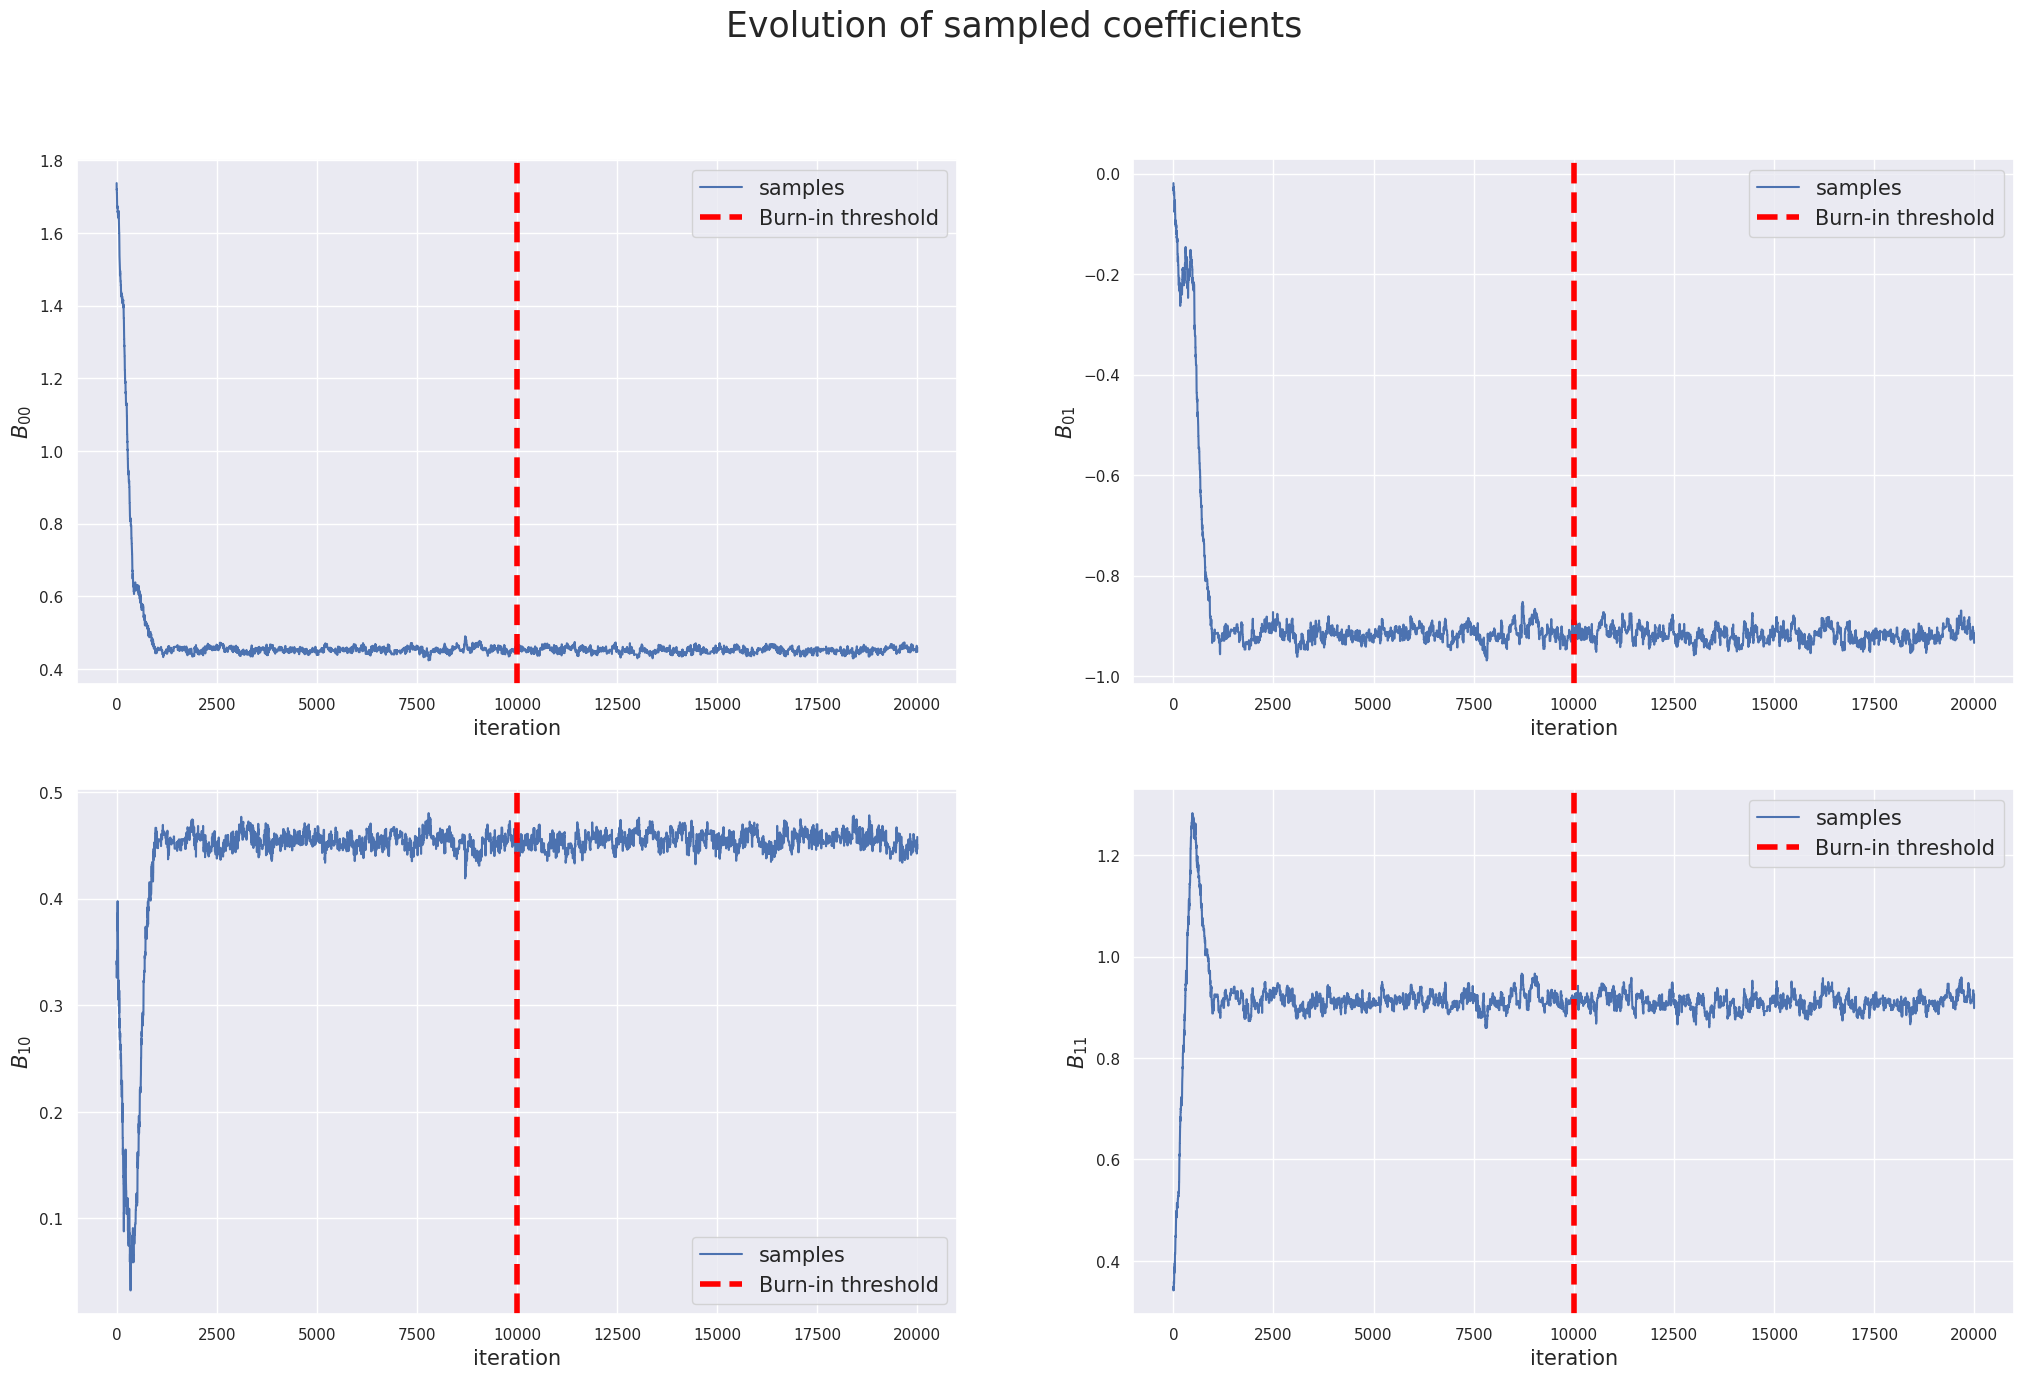

In [129]:
MCMCGraphPlotter.evolution_of_sampled_coefficients(
    samples=samples,
    estimator=estimator,
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.5.4. Plot sampled coefficients distributions - Markov Chain evolution

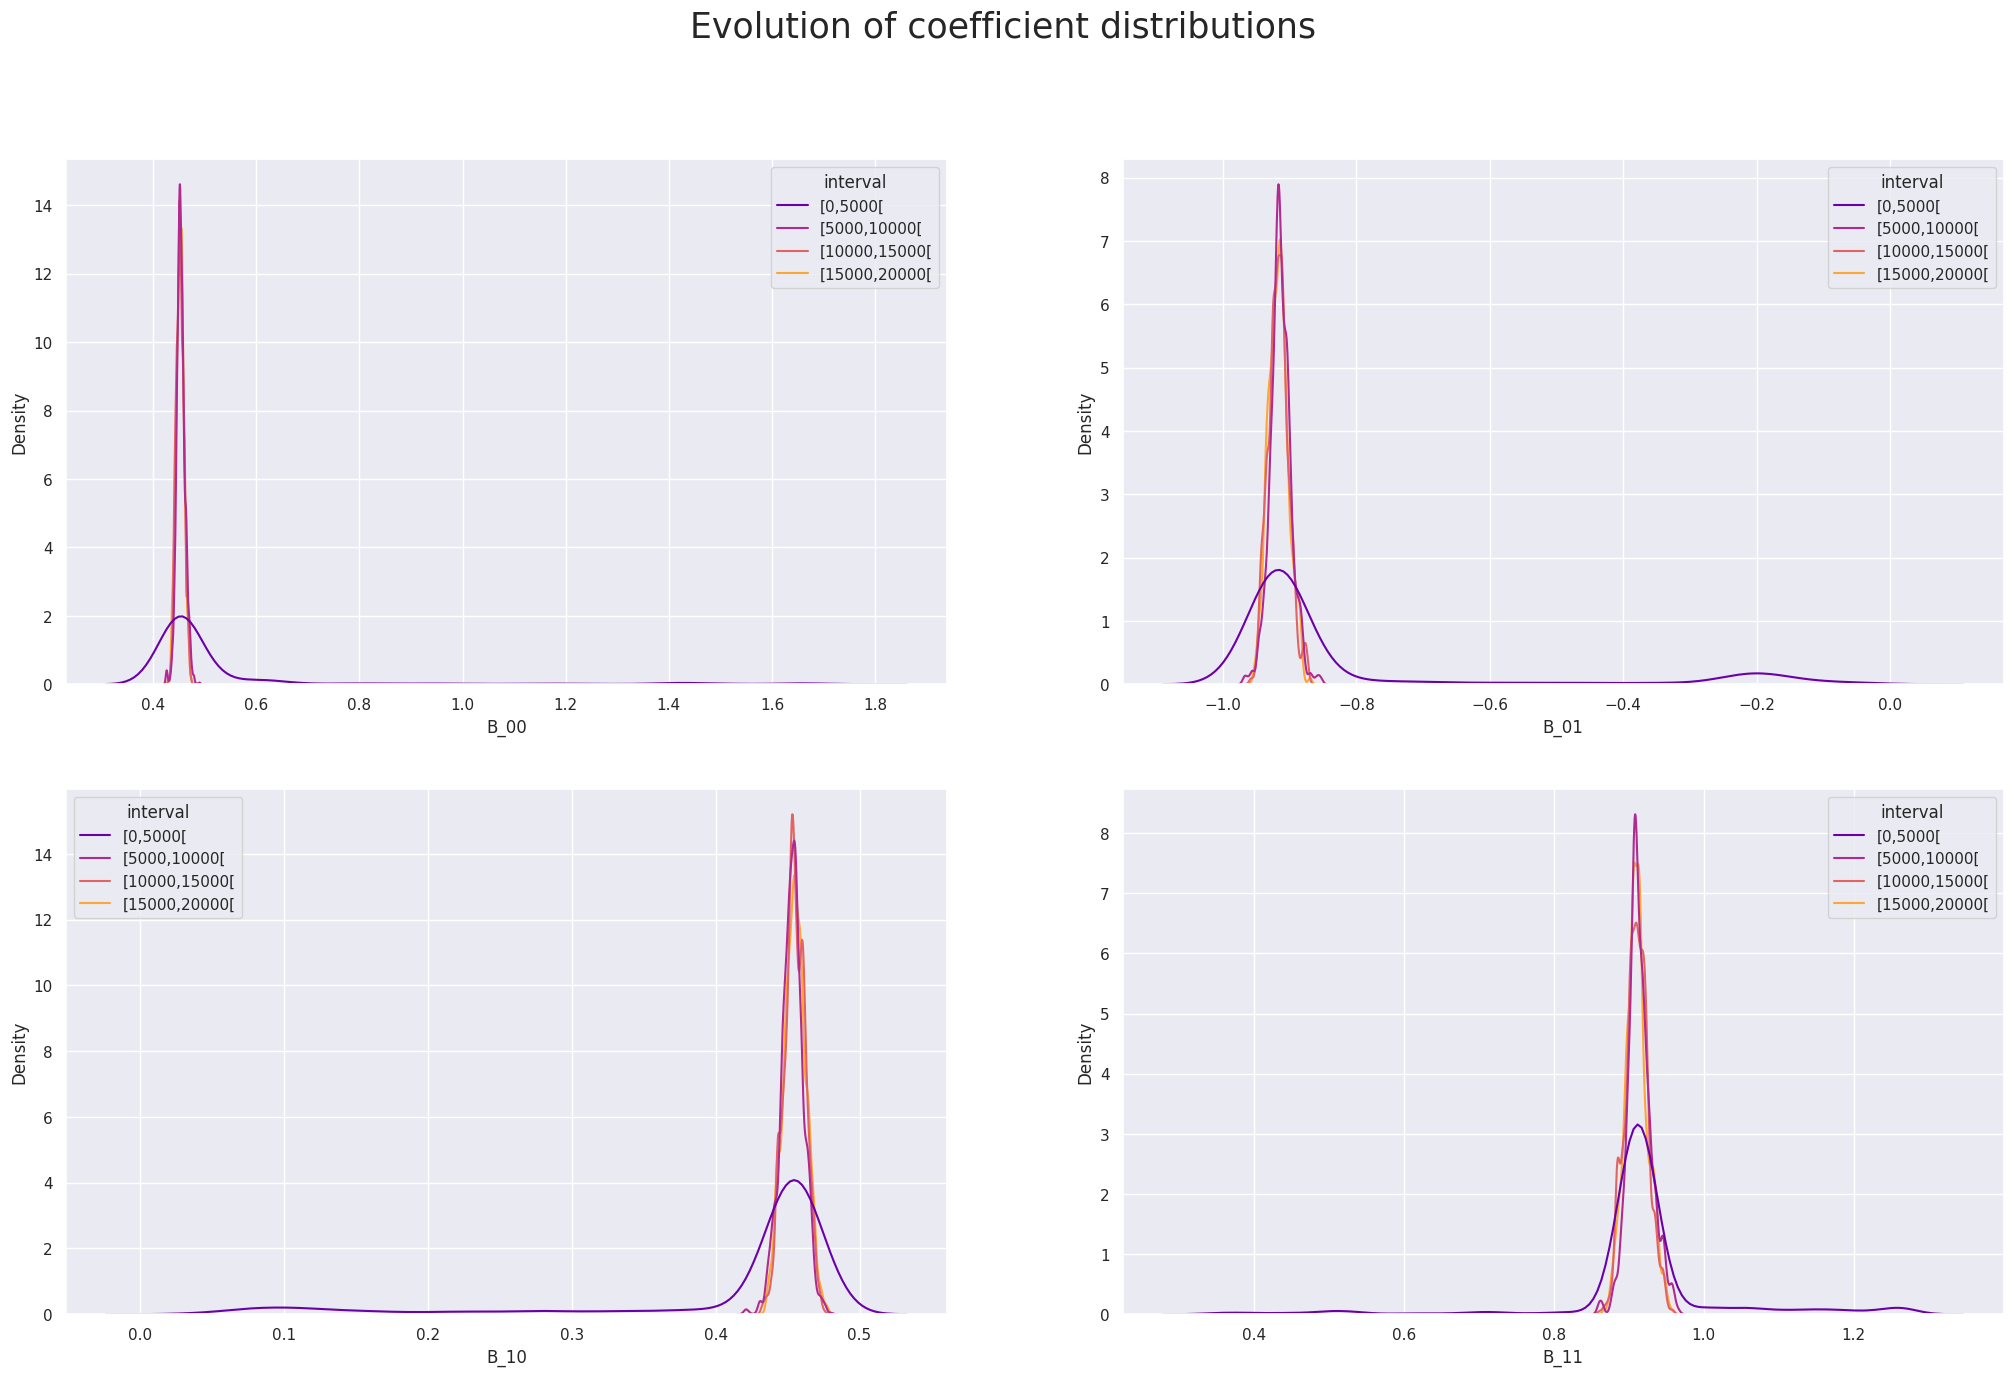

In [130]:
STEP_SIZE=5000
PALETTE='plasma'

MCMCGraphPlotter.evolution_of_samples_distribution(
    B_est=B_est,
    samples=samples,
    step_size=STEP_SIZE,
    palette=PALETTE,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.5.5. Plot Marginal Posteriors for Coefficients - Post-burn-in

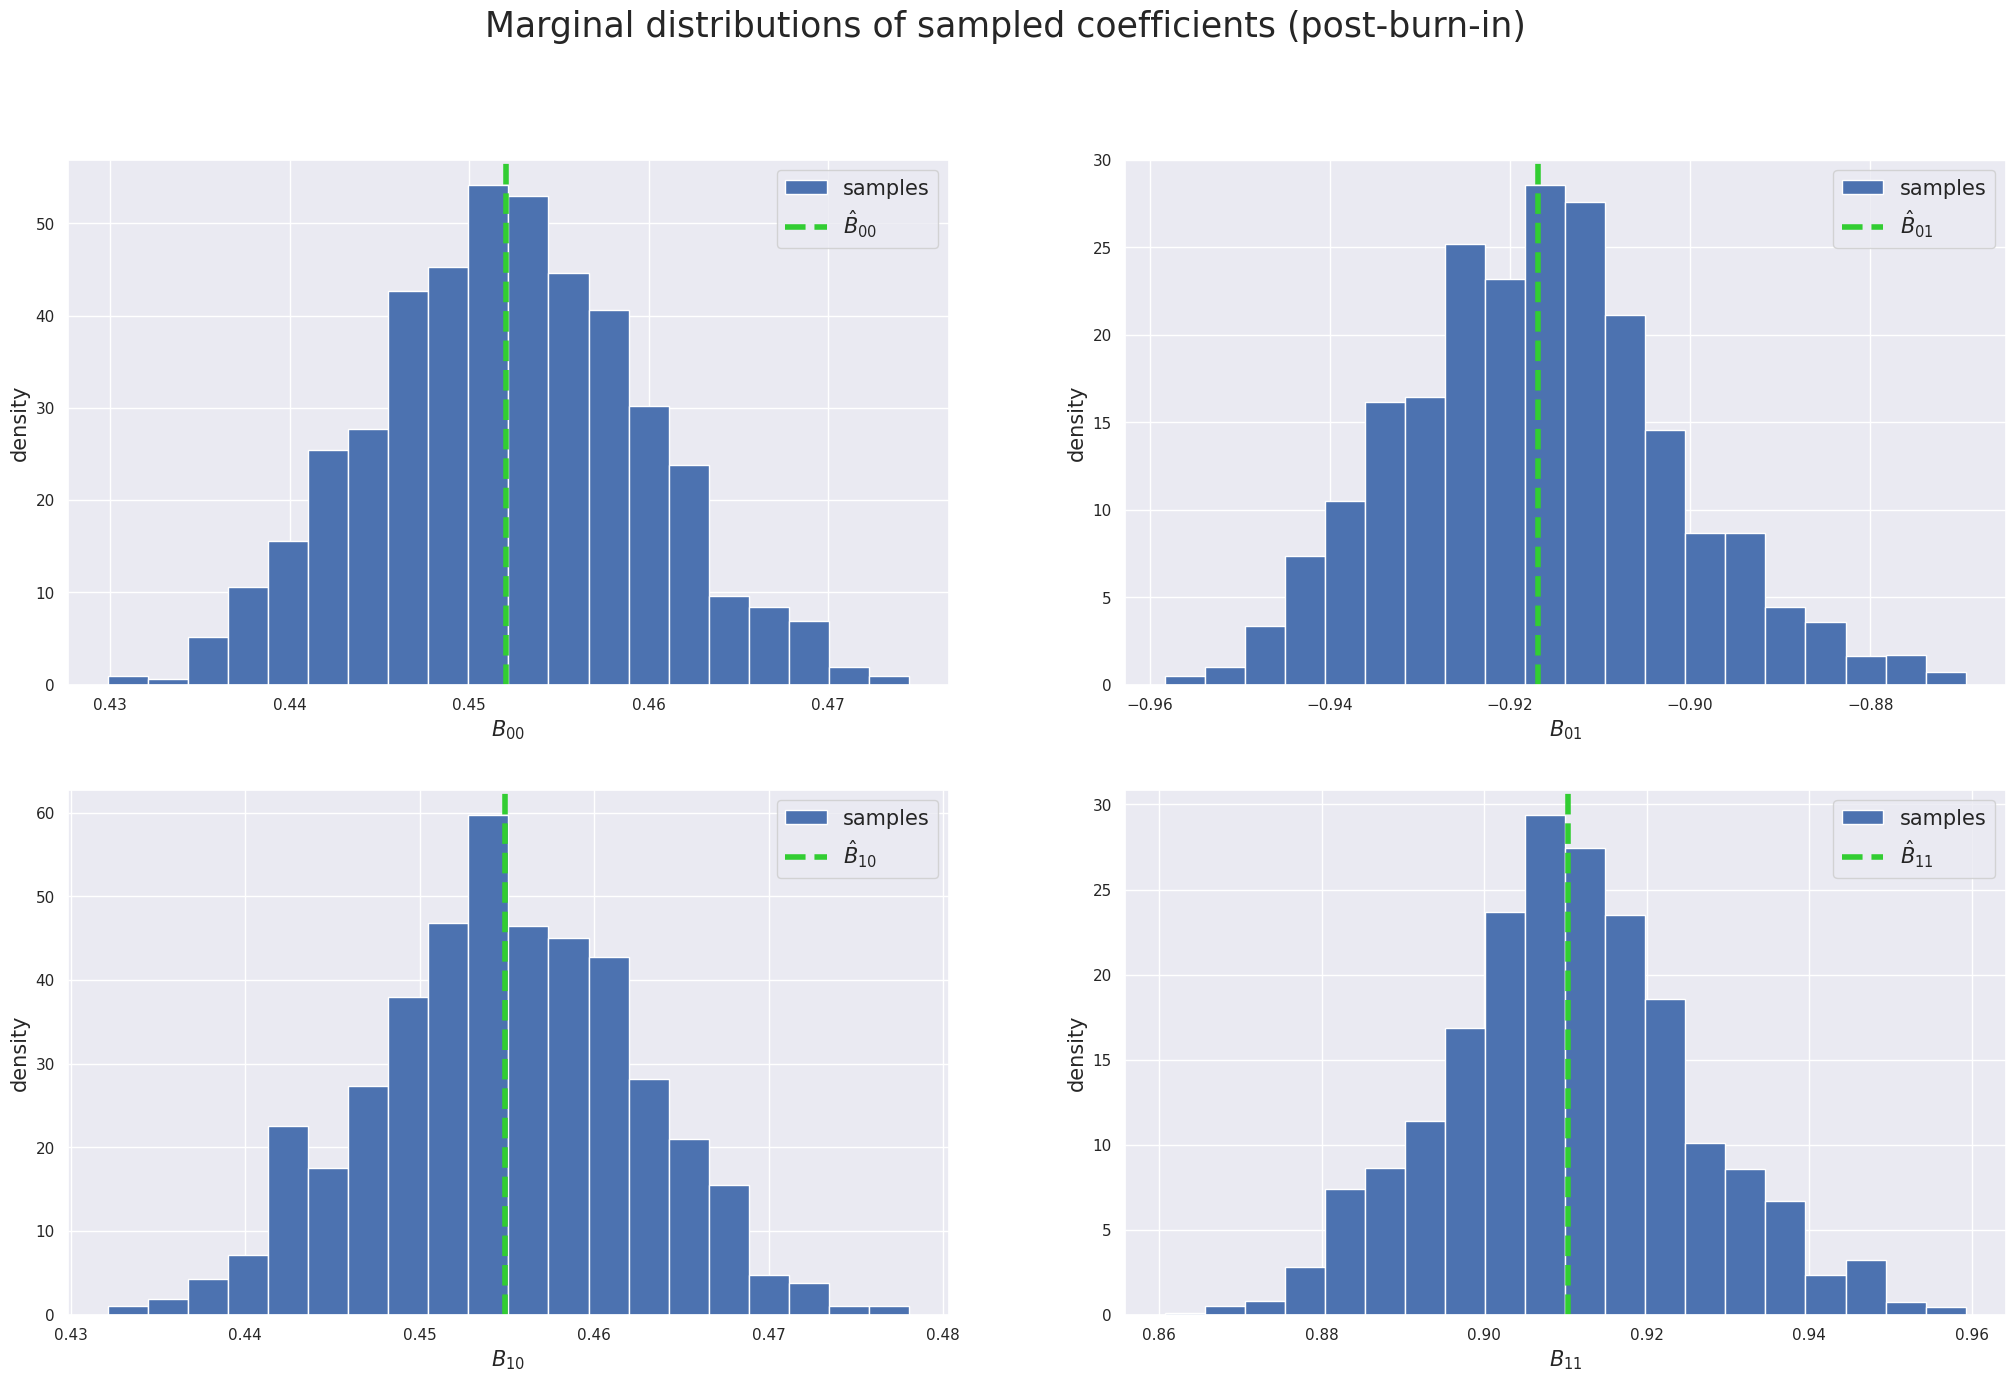

In [131]:
MCMCGraphPlotter.steady_state_marginal_distributions(
    valid_samples=valid_samples,
    nbins=NBINS,
    B_est=B_est,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

### 2.5.6. Plot evolution of log-posterior

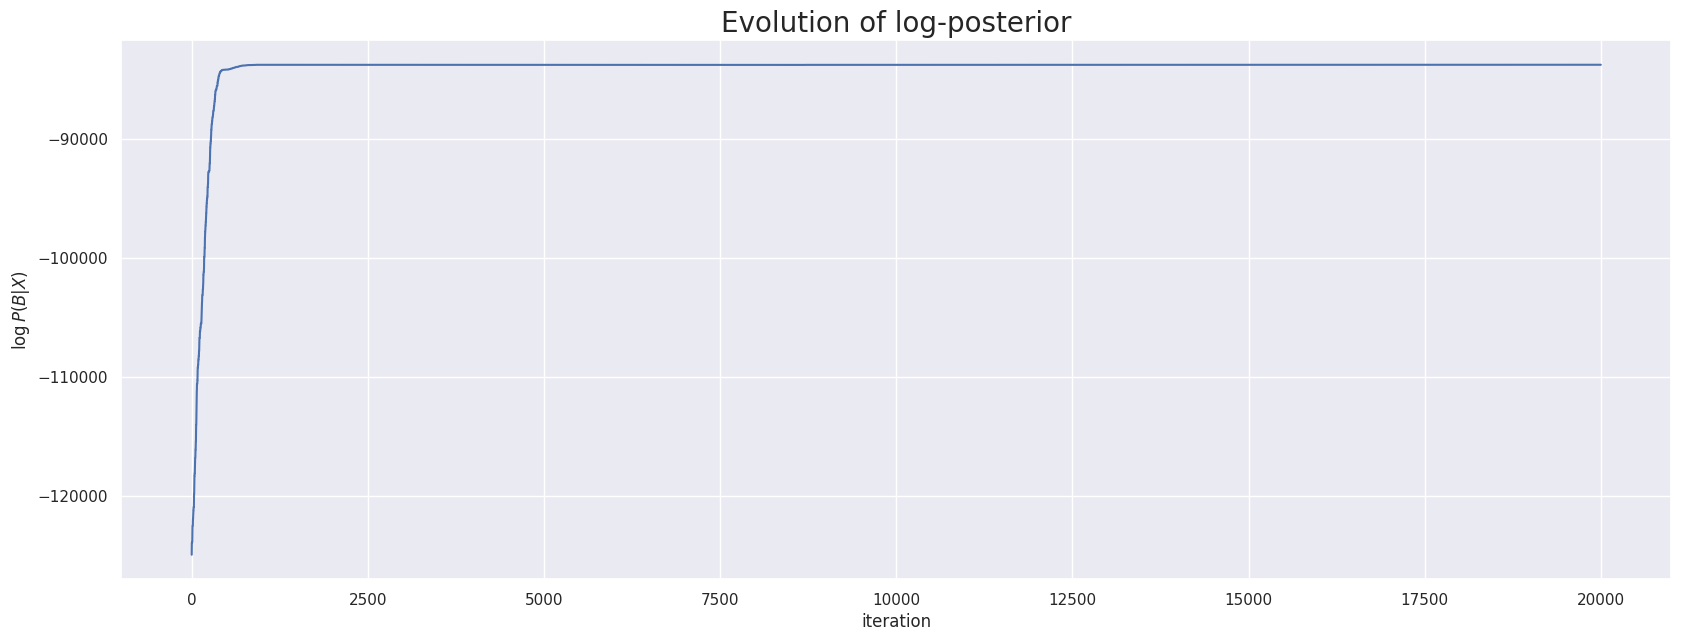

In [132]:
MCMCGraphPlotter.evolution_log_posterior(
    logs=logs,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

## 2.5.7. Plot source separation results

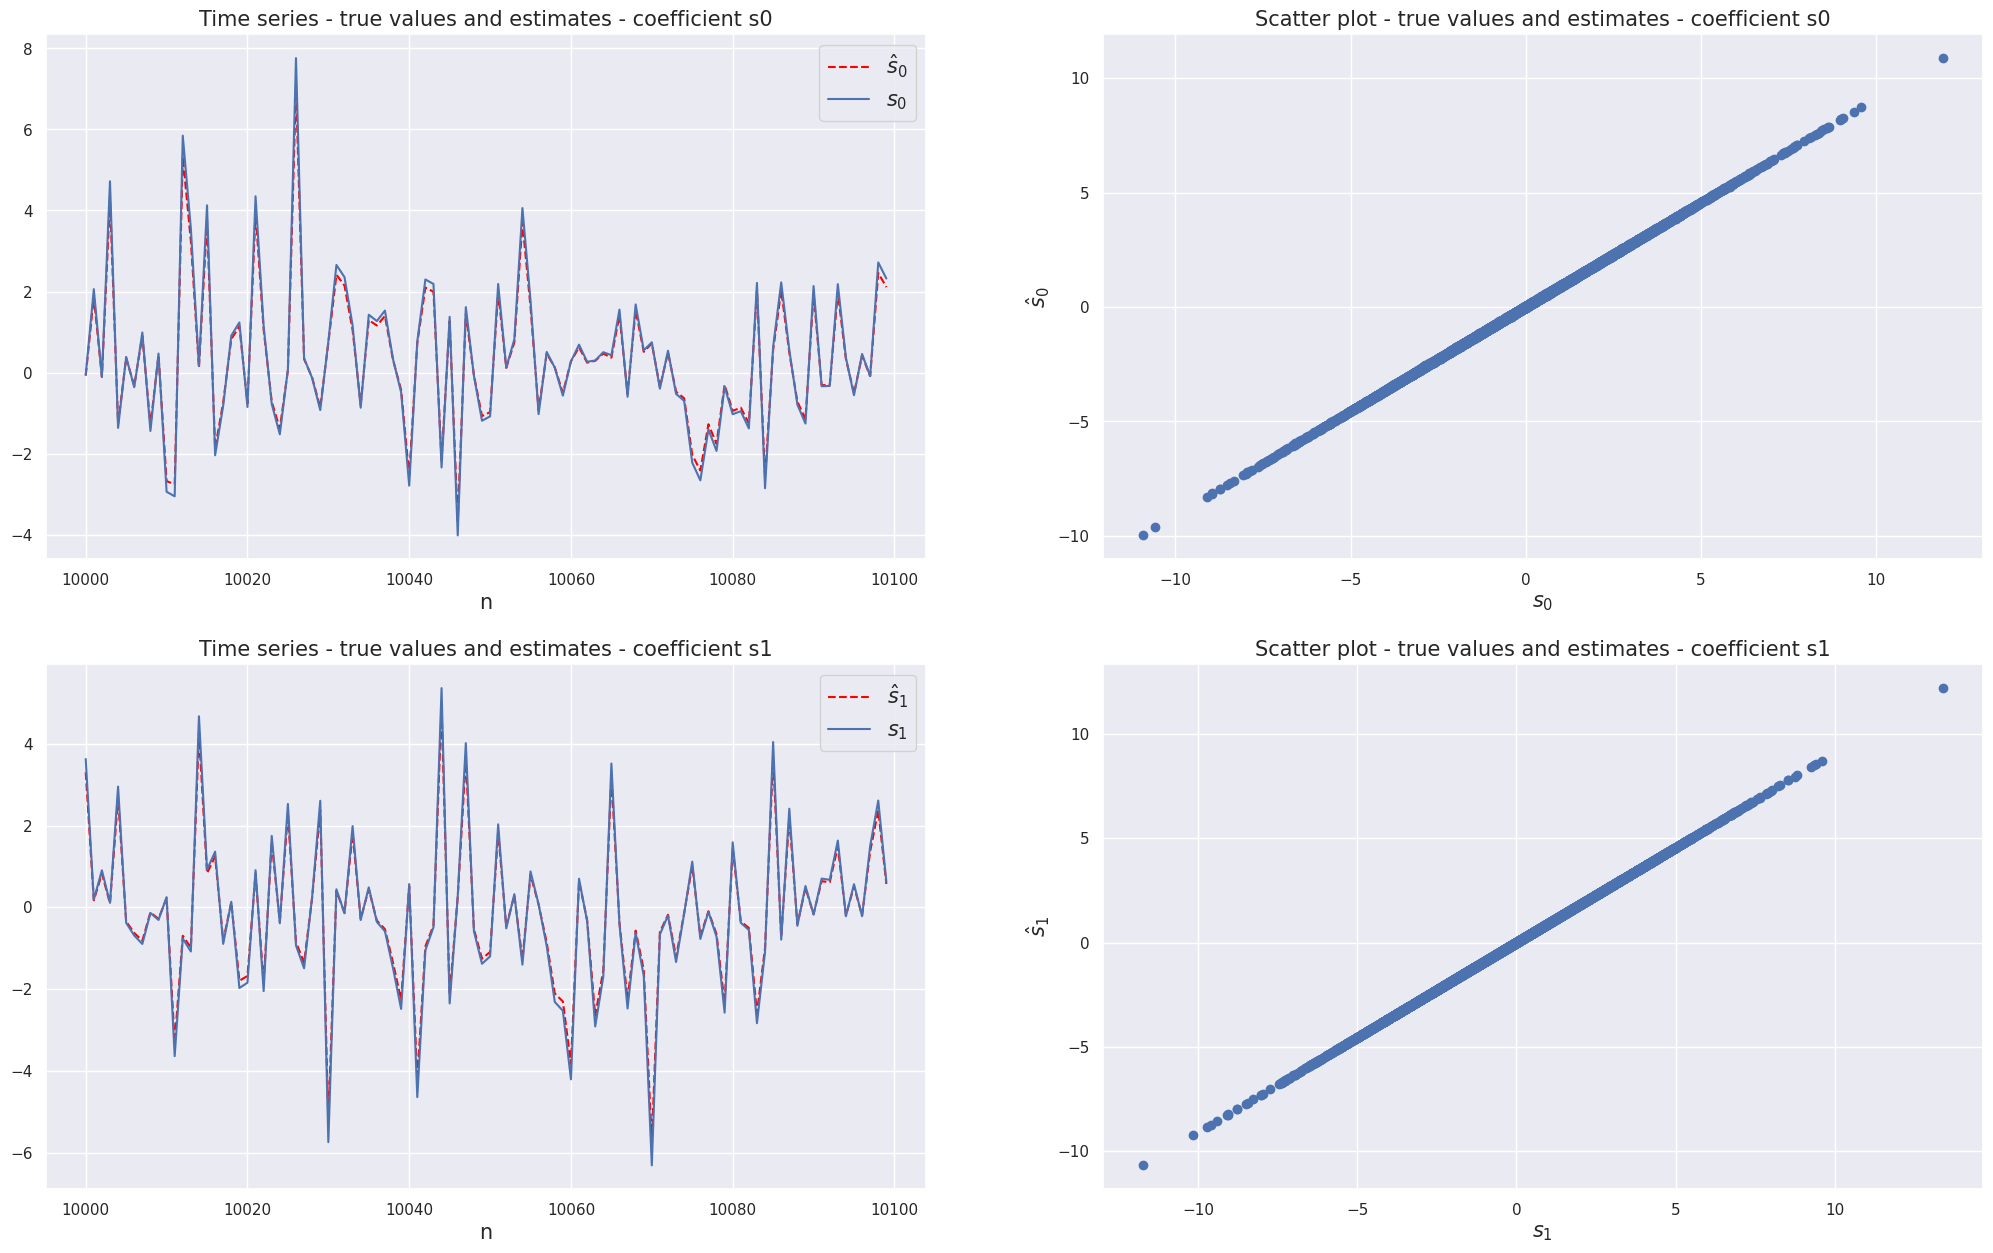

In [133]:
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

MCMCGraphPlotter.source_separation_results(
    plot_start=PLOT_START,
    plot_end=PLOT_END,
    B_est=B_est,
    s=s,
    s_est=s_est,
    x=x,
    nobs=NOBS,
    save_dir=combination_dir if SAVE_GRAPHS else None
)

In [134]:
# Error norm
err=np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)

# Log error
errors['slightly_misspecified_model']['near_identity_prior'] = err

print('Norma do erro de estimação: {}'.format(err))

Norma do erro de estimação: 0.0008940354077953767


In [135]:
# Save errors, if new execution was made
if EXECUTE_SAMPLING:
    with (experiment_dir / 'errors.pkl').open('wb') as f:
        pickle.dump(errors, f)
errors

{'perfect_model': {'likelihood': 6.443230754863028e-05,
  'determinant_prior': 6.319216406611947e-05,
  'near_identity_prior': 0.012761931151685916},
 'slightly_misspecified_model': {'likelihood': 0.0008887084177311825,
  'determinant_prior': 0.00088742115196529,
  'near_identity_prior': 0.0008940354077953767}}